In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# 数据处理

## 财务数据

财务数据处理的难点在于“报表数据所处的时间”、“报表报告的时间”、“报表修改时间”带来的复杂性。两种处理方式比较合理：
1. 预留充足的时间以便在使用报表数据的时间点上，报表数据是可用的（但不一定是最新的）
2. 无论在哪个时间点上使用报表数据，都只用最新的数据(point-in-time)

如果仔细探究，会（惊讶）发现，很多的研究，都采用了“事后修改”过的数据（例如GDP数据）。如果做的是“预测”性质的研究，那么站在 t 时刻，是不可能知道在 t+5 时刻会修改 t-1 时刻的数据，来进行 t+1 时刻的预测的。因此，很多的研究都站不住脚。

## 交易数据

### 停牌

- 停牌在某些时候是可以不处理的，比如计算动量的时候，停牌之后的价格和停牌前的价格计算收益率，可以作为动量的一种衡量
- 但在有的时候，停牌不处理可能会有问题。
    - 比如计算beta，市场收益率每个交易日都是有的，但个股停牌的时候没有，此时如果设为0，直接回归会有大的偏差
    - 另外比如计算波动率，如果设为0，也有问题
    - 从收益率的角度看，如果我们关注点是月收益率，也应当去掉，因为停牌的股票无法交易，也无法调仓
- 我们把停牌超过一个月的观测值删去

# Data

In [3]:
START = '2008-01-01'
END = '2025-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID'].unique()

In [5]:
stk_info

secID    ticker secShortName cnSpell exchangeCD assetClass  \
0        000001.XSHE    000001         平安银行    PAYH       XSHE          E   
1        000002.XSHE    000002          万科A     WKA       XSHE          E   
2        000003.XSHE    000003        PT金田A   PTJTA       XSHE          E   
3        000004.XSHE    000004         国华网安    GHWA       XSHE          E   
4        000005.XSHE    000005         ST星源    STXY       XSHE          E   
5        000006.XSHE    000006         深振业A    SZYA       XSHE          E   
6        000007.XSHE    000007          全新好     QXH       XSHE          E   
7        000008.XSHE    000008         神州高铁    SZGT       XSHE          E   
...              ...       ...          ...     ...        ...        ...   
27334    900950.XSHG    900950         新城B股    XCBG       XSHG          E   
27335    900951.XSHG    900951         退市大化    TSDH       XSHG          E   
27336    900952.XSHG    900952        ST锦港B   STJGB       XSHG          E   
27337    900953.XSHG    900953          凯马B     KMB       XSHG          E   
27338    900955.XSHG    900955         退市海B    TSHB       XSHG          E   
27339    900956.XSHG    900956         东贝B股    DBBG       XSHG          E   
27340    900957.XSHG    900957         凌云B股    LYBG       XSHG          E   
32202  DY600018.XSHG  DY600018         上港集箱    SGJX       XSHG          E   

      listStatusCD    listDate transCurrCD          ISIN  partyID  delistDate  
0                L  1991-04-03         CNY  CNE000000040      2.0         NaN  
1                L  1991-01-29         CNY  CNE0000000T2      3.0         NaN  
2               DE  1991-07-03         CNY  CNE1000031Y5      4.0  2002-06-14  
3                L  1990-12-01         CNY  CNE0000000Y2      5.0         NaN  
4               DE  1990-12-10         CNY  CNE0000001L7      6.0  2024-04-26  
5                L  1992-04-27         CNY  CNE000000164      7.0         NaN  
6                L  1992-04-13         CNY  CNE0000000P0      8.0         NaN  
7                L  1992-05-07         CNY  CNE0000001C6      9.0         NaN  
...            ...         ...         ...           ...      ...         ...  
27334           DE  1997-10-16         USD  CNE000000TH1   1429.0  2015-11-23  
27335           DE  1997-10-21         USD  CNE000000TJ7   1430.0  2020-08-27  
27336            L  1998-05-19         USD  CNE000000W88    763.0         NaN  
27337           DE  1998-06-24         USD  CNE000000WP8   1431.0  2024-07-05  
27338           DE  1999-01-18         USD  CNE000000YC2   1063.0  2022-07-13  
27339           DE  1999-07-15         USD  CNE000000ZS5   1432.0  2020-11-23  
27340            L  2000-07-28         USD  CNE0000013W9   1433.0         NaN  
32202           DE  2000-07-19         CNY           NaN    618.0  2006-10-20  

[5552 rows x 12 columns]

In [6]:
len(stk_id)

5552

## ST

In [7]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [8]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563603 entries, 0 to 563602
Data columns (total 3 columns):
secID        563603 non-null object
tradeDate    563603 non-null object
STflg        563603 non-null object
dtypes: object(3)
memory usage: 12.9+ MB


In [9]:
st_df

secID   tradeDate STflg
0       000004.XSHE  2008-01-02    ST
1       000004.XSHE  2008-01-03    ST
2       000004.XSHE  2008-01-04    ST
3       000004.XSHE  2008-01-07    ST
4       000004.XSHE  2008-01-08    ST
5       000004.XSHE  2008-01-09    ST
6       000004.XSHE  2008-01-10    ST
7       000004.XSHE  2008-01-11    ST
...             ...         ...   ...
563595  900955.XSHG  2022-06-06   *ST
563596  900955.XSHG  2022-06-07   *ST
563597  900955.XSHG  2022-06-08   *ST
563598  900955.XSHG  2022-06-09   *ST
563599  900955.XSHG  2022-06-10   *ST
563600  900955.XSHG  2022-06-13   *ST
563601  900955.XSHG  2022-06-14   *ST
563602  900955.XSHG  2022-06-15   *ST

[563603 rows x 3 columns]

In [10]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Book value

Book/Market ratio, 简称BM，也即价值因子，反映了公司的账面价值和市值的比值。Fama French (1993) 发现估值低(BM高)的股票和高的相比，预期收益为正。

BM ratio Fama-French(1993) 原文的构造方法：
- 每年的12月底的 book equity
- 每年12月最后一个交易日的mktcap
- 上述二者相除，得到 BM ratio
- 这个 BM ratio 作为下一年7月至下下一年6月的 portfolio 的 sorting variable

处理思路：
- 优矿的数据有发布日期，数据日期
- 这里book value比较简单，只取年报数据，也就是“数据日期”都是12月
- 取发布日期最晚，也就是最新的（也许年报和1季报中数据不同，或者年报发布后马上有更改），但不晚于次年6月

In [11]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,reportType="A",beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df.pkl')

In [12]:
fundmen_df = pd.read_pickle('./data/fundmen_df.pkl')

In [13]:
fundmen_df

secID publishDate     endDate  endDateRep           actPubtime  \
0       000001.XSHE  2025-03-15  2024-12-31  2024-12-31  2025-03-14 19:28:13   
1       000001.XSHE  2025-03-15  2023-12-31  2024-12-31  2025-03-14 19:28:13   
2       000001.XSHE  2024-10-19  2023-12-31  2024-09-30  2024-10-18 18:00:33   
3       000001.XSHE  2024-08-16  2023-12-31  2024-06-30  2024-08-15 19:33:28   
4       000001.XSHE  2024-04-20  2023-12-31  2024-03-31  2024-04-19 17:56:30   
5       000001.XSHE  2024-03-15  2023-12-31  2023-12-31  2024-03-14 18:46:58   
6       000001.XSHE  2024-03-15  2022-12-31  2023-12-31  2024-03-14 18:46:58   
7       000001.XSHE  2023-10-25  2022-12-31  2023-09-30  2023-10-24 17:52:46   
...             ...         ...         ...         ...                  ...   
329413  900957.XSHG  2010-08-14  2009-12-31  2010-06-30  2010-08-13 18:00:00   
329414  900957.XSHG  2010-04-21  2009-12-31  2010-03-31  2010-04-20 18:00:00   
329415  900957.XSHG  2010-03-30  2009-12-31  2009-12-31  2010-03-29 18:00:00   
329416  900957.XSHG  2010-03-30  2008-12-31  2009-12-31  2010-03-29 18:00:00   
329417  900957.XSHG  2009-10-26  2008-12-31  2009-09-30  2009-10-25 18:00:00   
329418  900957.XSHG  2009-08-01  2008-12-31  2009-06-30  2009-07-31 18:00:00   
329419  900957.XSHG  2009-04-18  2008-12-31  2009-03-31  2009-04-17 18:00:00   
329420  900957.XSHG  2009-03-26  2008-12-31  2008-12-31  2009-03-25 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                12  4.948420e+11  4.948420e+11          NaN  
1                12  4.723280e+11  4.723280e+11          NaN  
2                12  4.723280e+11  4.723280e+11          NaN  
3                12  4.723280e+11  4.723280e+11          NaN  
4                12  4.723280e+11  4.723280e+11          NaN  
5                12  4.723280e+11  4.723280e+11          NaN  
6                12  4.346800e+11  4.346800e+11          NaN  
7                12  4.346800e+11  4.346800e+11          NaN  
...             ...           ...           ...          ...  
329413           12  4.782246e+08  4.221760e+08  56048539.97  
329414           12  4.782246e+08  4.221760e+08  56048539.97  
329415           12  4.782246e+08  4.221760e+08  56048539.97  
329416           12  4.902596e+08  4.369354e+08  53324231.94  
329417           12  4.902596e+08  4.369354e+08  53324231.94  
329418           12  4.902596e+08  4.369354e+08  53324231.94  
329419           12  4.902596e+08  4.369354e+08  53324231.94  
329420           12  4.902596e+08  4.369354e+08  53324231.94  

[329421 rows x 9 columns]

In [14]:
fundmen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329421 entries, 0 to 329420
Data columns (total 9 columns):
secID           329421 non-null object
publishDate     329421 non-null object
endDate         329421 non-null object
endDateRep      329421 non-null object
actPubtime      329421 non-null object
fiscalPeriod    329421 non-null object
TShEquity       327631 non-null float64
TEquityAttrP    327628 non-null float64
minorityInt     247471 non-null float64
dtypes: float64(3), object(6)
memory usage: 22.6+ MB


In [15]:
fundmen_df['fiscalPeriod'].unique()

array(['12'], dtype=object)

In [16]:
fundmen_df[(fundmen_df['secID']=='000001.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
21  000001.XSHE  2021-02-02  2019-12-31  2020-12-31  2021-02-01 18:58:35   
22  000001.XSHE  2020-10-22  2019-12-31  2020-09-30  2020-10-21 19:21:43   
23  000001.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 17:50:41   
24  000001.XSHE  2020-04-21  2019-12-31  2020-03-31  2020-04-20 18:42:38   
25  000001.XSHE  2020-02-14  2019-12-31  2019-12-31  2020-02-13 19:02:36   

   fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
21           12  3.129830e+11  3.129830e+11          NaN  
22           12  3.129830e+11  3.129830e+11          NaN  
23           12  3.129830e+11  3.129830e+11          NaN  
24           12  3.129830e+11  3.129830e+11          NaN  
25           12  3.129830e+11  3.129830e+11          NaN

In [17]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
168698  300720.XSHE  2021-04-27  2019-12-31  2020-12-31  2021-04-26 18:40:28   
168699  300720.XSHE  2020-10-30  2019-12-31  2020-09-30  2020-10-29 19:58:45   
168700  300720.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 22:42:40   
168701  300720.XSHE  2020-04-24  2019-12-31  2020-03-31  2020-04-23 21:04:35   
168702  300720.XSHE  2020-04-24  2019-12-31  2019-12-31  2020-04-23 21:04:35   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
168698           12  4.783596e+08  4.783596e+08          NaN  
168699           12  4.783596e+08  4.783596e+08          NaN  
168700           12  4.783596e+08  4.783596e+08          NaN  
168701           12  4.783596e+08  4.783596e+08          NaN  
168702           12  4.783596e+08  4.783596e+08          NaN

In [18]:
fundmen_df[(fundmen_df['secID'] == '300720.XSHE') & (fundmen_df['endDate']=='2018-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
168703  300720.XSHE  2020-04-24  2018-12-31  2019-12-31  2020-04-23 21:04:35   
168704  300720.XSHE  2019-10-30  2018-12-31  2019-09-30  2019-10-29 19:22:34   
168705  300720.XSHE  2019-08-28  2018-12-31  2019-06-30  2019-08-27 19:42:06   
168706  300720.XSHE  2019-04-26  2018-12-31  2019-03-31  2019-04-25 23:27:06   
168707  300720.XSHE  2019-04-26  2018-12-31  2018-12-31  2019-04-25 23:27:06   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
168703           12  4.555515e+08  4.555515e+08          NaN  
168704           12  4.555515e+08  4.555515e+08          NaN  
168705           12  4.555515e+08  4.555515e+08          NaN  
168706           12  4.555515e+08  4.555515e+08          NaN  
168707           12  4.555515e+08  4.555515e+08          NaN

- `publishDate`: 实际公告日期
- `endDate`：数值所在日期
- `endDateRep`：数值所在报表日期（数值是哪个报表发布的）。03-31是一季报，06-30是半年报，09-30是三季报，12-31是年报。

后面的报表可能会对初始值做修改。

比如，300720.XSHE在2020-04-24公布了数据截止至2019-12-31的报告，里面包含了数据截止至2018-12-31的报表数据。

300720.XSHE在2019-08-28公布了数据截止至2019-06-30的报告，里面包含了数据截止至2018-12-31的报表数据。

在t年6月分组时，应当取最新更新过的t-1年12月31日的Book数值。

In [19]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [20]:
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year

In [21]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2025-03-15 2024-12-31  2024-12-31  2025-03-14 19:28:13   
1       000001.XSHE  2025-03-15 2023-12-31  2024-12-31  2025-03-14 19:28:13   
2       000001.XSHE  2024-10-19 2023-12-31  2024-09-30  2024-10-18 18:00:33   
3       000001.XSHE  2024-08-16 2023-12-31  2024-06-30  2024-08-15 19:33:28   
4       000001.XSHE  2024-04-20 2023-12-31  2024-03-31  2024-04-19 17:56:30   
5       000001.XSHE  2024-03-15 2023-12-31  2023-12-31  2024-03-14 18:46:58   
6       000001.XSHE  2024-03-15 2022-12-31  2023-12-31  2024-03-14 18:46:58   
7       000001.XSHE  2023-10-25 2022-12-31  2023-09-30  2023-10-24 17:52:46   
...             ...         ...        ...         ...                  ...   
329413  900957.XSHG  2010-08-14 2009-12-31  2010-06-30  2010-08-13 18:00:00   
329414  900957.XSHG  2010-04-21 2009-12-31  2010-03-31  2010-04-20 18:00:00   
329415  900957.XSHG  2010-03-30 2009-12-31  2009-12-31  2010-03-29 18:00:00   
329416  900957.XSHG  2010-03-30 2008-12-31  2009-12-31  2010-03-29 18:00:00   
329417  900957.XSHG  2009-10-26 2008-12-31  2009-09-30  2009-10-25 18:00:00   
329418  900957.XSHG  2009-08-01 2008-12-31  2009-06-30  2009-07-31 18:00:00   
329419  900957.XSHG  2009-04-18 2008-12-31  2009-03-31  2009-04-17 18:00:00   
329420  900957.XSHG  2009-03-26 2008-12-31  2008-12-31  2009-03-25 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  pub_month  \
0                12  4.948420e+11  4.948420e+11          NaN          3   
1                12  4.723280e+11  4.723280e+11          NaN          3   
2                12  4.723280e+11  4.723280e+11          NaN         10   
3                12  4.723280e+11  4.723280e+11          NaN          8   
4                12  4.723280e+11  4.723280e+11          NaN          4   
5                12  4.723280e+11  4.723280e+11          NaN          3   
6                12  4.346800e+11  4.346800e+11          NaN          3   
7                12  4.346800e+11  4.346800e+11          NaN         10   
...             ...           ...           ...          ...        ...   
329413           12  4.782246e+08  4.221760e+08  56048539.97          8   
329414           12  4.782246e+08  4.221760e+08  56048539.97          4   
329415           12  4.782246e+08  4.221760e+08  56048539.97          3   
329416           12  4.902596e+08  4.369354e+08  53324231.94          3   
329417           12  4.902596e+08  4.369354e+08  53324231.94         10   
329418           12  4.902596e+08  4.369354e+08  53324231.94          8   
329419           12  4.902596e+08  4.369354e+08  53324231.94          4   
329420           12  4.902596e+08  4.369354e+08  53324231.94          3   

        pub_year  data_year  
0           2025       2024  
1           2025       2023  
2           2024       2023  
3           2024       2023  
4           2024       2023  
5           2024       2023  
6           2024       2022  
7           2023       2022  
...          ...        ...  
329413      2010       2009  
329414      2010       2009  
329415      2010       2009  
329416      2010       2008  
329417      2009       2008  
329418      2009       2008  
329419      2009       2008  
329420      2009       2008  

[329421 rows x 12 columns]

In [22]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate  endDateRep           actPubtime  \
168698  300720.XSHE  2021-04-27 2019-12-31  2020-12-31  2021-04-26 18:40:28   
168699  300720.XSHE  2020-10-30 2019-12-31  2020-09-30  2020-10-29 19:58:45   
168700  300720.XSHE  2020-08-28 2019-12-31  2020-06-30  2020-08-27 22:42:40   
168701  300720.XSHE  2020-04-24 2019-12-31  2020-03-31  2020-04-23 21:04:35   
168702  300720.XSHE  2020-04-24 2019-12-31  2019-12-31  2020-04-23 21:04:35   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  pub_month  \
168698           12  4.783596e+08  4.783596e+08          NaN          4   
168699           12  4.783596e+08  4.783596e+08          NaN         10   
168700           12  4.783596e+08  4.783596e+08          NaN          8   
168701           12  4.783596e+08  4.783596e+08          NaN          4   
168702           12  4.783596e+08  4.783596e+08          NaN          4   

        pub_year  data_year  
168698      2021       2019  
168699      2020       2019  
168700      2020       2019  
168701      2020       2019  
168702      2020       2019

In [23]:
fundmen_df['pub_year'] - fundmen_df['data_year'] 

0         1
1         2
2         1
3         1
4         1
5         1
6         2
7         1
         ..
329413    1
329414    1
329415    1
329416    2
329417    1
329418    1
329419    1
329420    1
Length: 329421, dtype: int64

In [24]:
(fundmen_df['pub_year'] - fundmen_df['data_year']).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [25]:
(fundmen_df['pub_year'] - fundmen_df['data_year']).value_counts()

1     242527
2      72935
3      11273
4       1906
5        362
6        191
7         98
8         48
9         27
10        17
11        13
12        11
13         7
14         3
15         2
16         1
dtype: int64

In [26]:
fundmen_df.loc[(fundmen_df['pub_year'] - fundmen_df['data_year'])==16]

secID publishDate    endDate  endDateRep           actPubtime  \
208880  600287.XSHG  2024-04-30 2008-12-31  2009-12-31  2024-04-29 20:52:15   

       fiscalPeriod     TShEquity  TEquityAttrP   minorityInt  pub_month  \
208880           12  1.137622e+09  8.267516e+08  3.108704e+08          4   

        pub_year  data_year  
208880      2024       2008

In [27]:
fundmen_df.drop(['actPubtime','fiscalPeriod'],axis=1, inplace=True)

In [28]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
0       000001.XSHE  2025-03-15 2024-12-31  2024-12-31  4.948420e+11   
1       000001.XSHE  2025-03-15 2023-12-31  2024-12-31  4.723280e+11   
2       000001.XSHE  2024-10-19 2023-12-31  2024-09-30  4.723280e+11   
3       000001.XSHE  2024-08-16 2023-12-31  2024-06-30  4.723280e+11   
4       000001.XSHE  2024-04-20 2023-12-31  2024-03-31  4.723280e+11   
5       000001.XSHE  2024-03-15 2023-12-31  2023-12-31  4.723280e+11   
6       000001.XSHE  2024-03-15 2022-12-31  2023-12-31  4.346800e+11   
7       000001.XSHE  2023-10-25 2022-12-31  2023-09-30  4.346800e+11   
...             ...         ...        ...         ...           ...   
329413  900957.XSHG  2010-08-14 2009-12-31  2010-06-30  4.782246e+08   
329414  900957.XSHG  2010-04-21 2009-12-31  2010-03-31  4.782246e+08   
329415  900957.XSHG  2010-03-30 2009-12-31  2009-12-31  4.782246e+08   
329416  900957.XSHG  2010-03-30 2008-12-31  2009-12-31  4.902596e+08   
329417  900957.XSHG  2009-10-26 2008-12-31  2009-09-30  4.902596e+08   
329418  900957.XSHG  2009-08-01 2008-12-31  2009-06-30  4.902596e+08   
329419  900957.XSHG  2009-04-18 2008-12-31  2009-03-31  4.902596e+08   
329420  900957.XSHG  2009-03-26 2008-12-31  2008-12-31  4.902596e+08   

        TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
0       4.948420e+11          NaN          3      2025       2024  
1       4.723280e+11          NaN          3      2025       2023  
2       4.723280e+11          NaN         10      2024       2023  
3       4.723280e+11          NaN          8      2024       2023  
4       4.723280e+11          NaN          4      2024       2023  
5       4.723280e+11          NaN          3      2024       2023  
6       4.346800e+11          NaN          3      2024       2022  
7       4.346800e+11          NaN         10      2023       2022  
...              ...          ...        ...       ...        ...  
329413  4.221760e+08  56048539.97          8      2010       2009  
329414  4.221760e+08  56048539.97          4      2010       2009  
329415  4.221760e+08  56048539.97          3      2010       2009  
329416  4.369354e+08  53324231.94          3      2010       2008  
329417  4.369354e+08  53324231.94         10      2009       2008  
329418  4.369354e+08  53324231.94          8      2009       2008  
329419  4.369354e+08  53324231.94          4      2009       2008  
329420  4.369354e+08  53324231.94          3      2009       2008  

[329421 rows x 10 columns]

In [29]:
# 每年6月底计算时，只能看到publishDate在6月之前的数值。
# 取 endDate 相同时，publishDate 最晚（但小于等于6）的那个数值
# 同时pub_year - data_year 不能大于1(最近的报告)
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year
fundmen_df = fundmen_df[(fundmen_df['pub_year'] - fundmen_df['data_year']) == 1]
fundmen_df = fundmen_df[fundmen_df['pub_month'] <= 6]
fundmen_df.sort_values(['secID','endDate','publishDate','endDateRep'],inplace=True)

In [30]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate  endDateRep     TShEquity  \
168702  300720.XSHE  2020-04-24 2019-12-31  2019-12-31  4.783596e+08   
168701  300720.XSHE  2020-04-24 2019-12-31  2020-03-31  4.783596e+08   

        TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
168702  4.783596e+08          NaN          4      2020       2019  
168701  4.783596e+08          NaN          4      2020       2019

In [31]:
fundmen_df.loc[fundmen_df.duplicated(['secID','endDate'], keep=False)]

secID publishDate    endDate  endDateRep     TShEquity  \
80      000001.XSHE  2009-03-20 2008-12-31  2008-12-31  1.640079e+10   
79      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
75      000001.XSHE  2010-03-12 2009-12-31  2009-12-31  2.046961e+10   
74      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
70      000001.XSHE  2011-02-25 2010-12-31  2010-12-31  3.351288e+10   
69      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
65      000001.XSHE  2012-03-09 2011-12-31  2011-12-31  7.538058e+10   
64      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
...             ...         ...        ...         ...           ...   
329358  900957.XSHG  2021-04-09 2020-12-31  2020-12-31  4.987276e+08   
329357  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
329353  900957.XSHG  2022-04-20 2021-12-31  2021-12-31  5.263733e+08   
329352  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
329348  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  5.669258e+08   
329347  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   
329343  900957.XSHG  2024-04-12 2023-12-31  2023-12-31  6.071647e+08   
329342  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  6.071647e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  
80      1.640079e+10           NaN          3      2009       2008  
79      1.640079e+10           NaN          4      2009       2008  
75      2.046961e+10           NaN          3      2010       2009  
74      2.046961e+10           NaN          4      2010       2009  
70      3.351288e+10           NaN          2      2011       2010  
69      3.351288e+10           NaN          4      2011       2010  
65      7.331084e+10  2.069747e+09          3      2012       2011  
64      7.331084e+10  2.069747e+09          4      2012       2011  
...              ...           ...        ...       ...        ...  
329358  4.979110e+08  8.165551e+05          4      2021       2020  
329357  4.979110e+08  8.165551e+05          4      2021       2020  
329353  5.255741e+08  7.991940e+05          4      2022       2021  
329352  5.255741e+08  7.991940e+05          4      2022       2021  
329348  5.660700e+08  8.557882e+05          4      2023       2022  
329347  5.660700e+08  8.557882e+05          4      2023       2022  
329343  6.063475e+08  8.171545e+05          4      2024       2023  
329342  6.063475e+08  8.171545e+05          4      2024       2023  

[117967 rows x 10 columns]

In [32]:
fundmen_df.loc[fundmen_df['pub_month'].idxmax()] 
# 观察最晚的披露时间是否超过了6月？

secID                   000005.XSHE
publishDate     2013-06-15 00:00:00
endDate         2012-12-31 00:00:00
endDateRep               2012-12-31
TShEquity               6.82099e+08
TEquityAttrP            6.82099e+08
minorityInt                     NaN
pub_month                         6
pub_year                       2013
data_year                      2012
Name: 347, dtype: object

In [33]:
fundmen_df.shape

(120140, 10)

In [34]:
fundmen_df.drop_duplicates(['secID','endDate'],keep='last')

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
74      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
69      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
64      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
59      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
54      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
49      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
44      000001.XSHE  2016-04-21 2015-12-31  2016-03-31  1.615000e+11   
...             ...         ...        ...         ...           ...   
329377  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
329372  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
329367  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
329362  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
329357  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
329352  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
329347  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   
329342  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  6.071647e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  
79      1.640079e+10           NaN          4      2009       2008  
74      2.046961e+10           NaN          4      2010       2009  
69      3.351288e+10           NaN          4      2011       2010  
64      7.331084e+10  2.069747e+09          4      2012       2011  
59      8.479900e+10           NaN          4      2013       2012  
54      1.120810e+11           NaN          4      2014       2013  
49      1.309490e+11           NaN          4      2015       2014  
44      1.615000e+11           NaN          4      2016       2015  
...              ...           ...        ...       ...        ...  
329377  3.930721e+08  7.546643e+05          4      2017       2016  
329372  4.231040e+08  7.386715e+05          4      2018       2017  
329367  4.508051e+08  7.226781e+05          4      2019       2018  
329362  4.761021e+08  7.667705e+05          4      2020       2019  
329357  4.979110e+08  8.165551e+05          4      2021       2020  
329352  5.255741e+08  7.991940e+05          4      2022       2021  
329347  5.660700e+08  8.557882e+05          4      2023       2022  
329342  6.063475e+08  8.171545e+05          4      2024       2023  

[57446 rows x 10 columns]

In [35]:
fundmen_df.groupby(['secID','endDate'],as_index=False).last()

secID    endDate publishDate  endDateRep     TShEquity  \
0      000001.XSHE 2008-12-31  2009-04-24  2009-03-31  1.640079e+10   
1      000001.XSHE 2009-12-31  2010-04-29  2010-03-31  2.046961e+10   
2      000001.XSHE 2010-12-31  2011-04-27  2011-03-31  3.351288e+10   
3      000001.XSHE 2011-12-31  2012-04-26  2012-03-31  7.538058e+10   
4      000001.XSHE 2012-12-31  2013-04-24  2013-03-31  8.479900e+10   
5      000001.XSHE 2013-12-31  2014-04-24  2014-03-31  1.120810e+11   
6      000001.XSHE 2014-12-31  2015-04-24  2015-03-31  1.309490e+11   
7      000001.XSHE 2015-12-31  2016-04-21  2016-03-31  1.615000e+11   
...            ...        ...         ...         ...           ...   
57438  900957.XSHG 2016-12-31  2017-04-26  2017-03-31  3.938268e+08   
57439  900957.XSHG 2017-12-31  2018-04-26  2018-03-31  4.238426e+08   
57440  900957.XSHG 2018-12-31  2019-04-25  2019-03-31  4.515278e+08   
57441  900957.XSHG 2019-12-31  2020-04-29  2020-03-31  4.768689e+08   
57442  900957.XSHG 2020-12-31  2021-04-27  2021-03-31  4.987276e+08   
57443  900957.XSHG 2021-12-31  2022-04-30  2022-03-31  5.263733e+08   
57444  900957.XSHG 2022-12-31  2023-04-27  2023-03-31  5.669258e+08   
57445  900957.XSHG 2023-12-31  2024-04-26  2024-03-31  6.071647e+08   

       TEquityAttrP   minorityInt  pub_month  pub_year  data_year  
0      1.640079e+10           NaN          4      2009       2008  
1      2.046961e+10           NaN          4      2010       2009  
2      3.351288e+10           NaN          4      2011       2010  
3      7.331084e+10  2.069747e+09          4      2012       2011  
4      8.479900e+10           NaN          4      2013       2012  
5      1.120810e+11           NaN          4      2014       2013  
6      1.309490e+11           NaN          4      2015       2014  
7      1.615000e+11           NaN          4      2016       2015  
...             ...           ...        ...       ...        ...  
57438  3.930721e+08  7.546643e+05          4      2017       2016  
57439  4.231040e+08  7.386715e+05          4      2018       2017  
57440  4.508051e+08  7.226781e+05          4      2019       2018  
57441  4.761021e+08  7.667705e+05          4      2020       2019  
57442  4.979110e+08  8.165551e+05          4      2021       2020  
57443  5.255741e+08  7.991940e+05          4      2022       2021  
57444  5.660700e+08  8.557882e+05          4      2023       2022  
57445  6.063475e+08  8.171545e+05          4      2024       2023  

[57446 rows x 10 columns]

In [36]:
fundmen_df.drop_duplicates(['secID','endDate'],keep='last', inplace=True)

In [37]:
fundmen_df.shape

(57446, 10)

In [38]:
fundmen_df['bm_date'] = fundmen_df['endDate'].dt.to_period('M')

In [39]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
74      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
69      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
64      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
59      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
54      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
49      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
44      000001.XSHE  2016-04-21 2015-12-31  2016-03-31  1.615000e+11   
...             ...         ...        ...         ...           ...   
329377  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
329372  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
329367  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
329362  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
329357  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
329352  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
329347  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   
329342  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  6.071647e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  
79      1.640079e+10           NaN          4      2009       2008  2008-12  
74      2.046961e+10           NaN          4      2010       2009  2009-12  
69      3.351288e+10           NaN          4      2011       2010  2010-12  
64      7.331084e+10  2.069747e+09          4      2012       2011  2011-12  
59      8.479900e+10           NaN          4      2013       2012  2012-12  
54      1.120810e+11           NaN          4      2014       2013  2013-12  
49      1.309490e+11           NaN          4      2015       2014  2014-12  
44      1.615000e+11           NaN          4      2016       2015  2015-12  
...              ...           ...        ...       ...        ...      ...  
329377  3.930721e+08  7.546643e+05          4      2017       2016  2016-12  
329372  4.231040e+08  7.386715e+05          4      2018       2017  2017-12  
329367  4.508051e+08  7.226781e+05          4      2019       2018  2018-12  
329362  4.761021e+08  7.667705e+05          4      2020       2019  2019-12  
329357  4.979110e+08  8.165551e+05          4      2021       2020  2020-12  
329352  5.255741e+08  7.991940e+05          4      2022       2021  2021-12  
329347  5.660700e+08  8.557882e+05          4      2023       2022  2022-12  
329342  6.063475e+08  8.171545e+05          4      2024       2023  2023-12  

[57446 rows x 11 columns]

In [40]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [41]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [42]:
# np.allclose(fundmen_df['book'],fundmen_df['TEquityAttrP'])

In [43]:
# fundmen_df[fundmen_df['book']-fundmen_df['TEquityAttrP'] > 10]

In [44]:
fundmen_df.loc[fundmen_df['TShEquity']<0]

secID publishDate    endDate  endDateRep     TShEquity  \
193     000003.XSHE  2009-04-30 2008-12-31  2008-12-31 -3.063484e+09   
189     000003.XSHE  2011-04-28 2010-12-31  2010-12-31 -2.994943e+09   
186     000003.XSHE  2012-04-26 2011-12-31  2011-12-31 -3.277899e+09   
183     000003.XSHE  2013-04-26 2012-12-31  2012-12-31 -3.292266e+09   
180     000003.XSHE  2014-04-29 2013-12-31  2013-12-31 -3.286909e+09   
177     000003.XSHE  2015-04-29 2014-12-31  2014-12-31 -3.299867e+09   
550     000007.XSHE  2009-04-29 2008-12-31  2009-03-31 -7.487471e+07   
545     000007.XSHE  2010-04-27 2009-12-31  2010-03-31 -5.445400e+07   
...             ...         ...        ...         ...           ...   
327620  900931.XSHG  2017-04-26 2016-12-31  2017-03-31 -4.542747e+07   
328036  900937.XSHG  2022-04-28 2021-12-31  2022-03-31 -2.099971e+09   
328185  900938.XSHG  2009-04-30 2008-12-31  2009-03-31 -2.074566e+08   
328180  900938.XSHG  2010-04-28 2009-12-31  2010-03-31 -4.359970e+08   
328175  900938.XSHG  2011-04-27 2010-12-31  2011-03-31 -4.040346e+08   
328170  900938.XSHG  2012-04-27 2011-12-31  2012-03-31 -5.609697e+08   
328608  900945.XSHG  2021-04-30 2020-12-31  2021-03-31 -2.225391e+10   
328984  900951.XSHG  2020-04-25 2019-12-31  2020-03-31 -1.835457e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
193    -2.983208e+09 -8.027613e+07          4      2009       2008  2008-12   
189    -2.994943e+09           NaN          4      2011       2010  2010-12   
186    -3.277899e+09           NaN          4      2012       2011  2011-12   
183    -3.292266e+09           NaN          4      2013       2012  2012-12   
180    -3.286909e+09           NaN          4      2014       2013  2013-12   
177    -3.299867e+09           NaN          4      2015       2014  2014-12   
550    -8.457082e+07  9.696114e+06          4      2009       2008  2008-12   
545    -5.844145e+07  3.987457e+06          4      2010       2009  2009-12   
...              ...           ...        ...       ...        ...      ...   
327620 -4.769018e+07  2.262713e+06          4      2017       2016  2016-12   
328036 -2.108546e+09  8.574239e+06          4      2022       2021  2021-12   
328185 -2.091595e+08  1.702871e+06          4      2009       2008  2008-12   
328180 -4.376105e+08  1.613520e+06          4      2010       2009  2009-12   
328175 -3.947695e+08 -9.265102e+06          4      2011       2010  2010-12   
328170 -5.515713e+08 -9.398335e+06          4      2012       2011  2011-12   
328608 -2.837151e+10  6.117605e+09          4      2021       2020  2020-12   
328984 -1.835457e+08           NaN          4      2020       2019  2019-12   

                book  
193    -2.983208e+09  
189    -2.994943e+09  
186    -3.277899e+09  
183    -3.292266e+09  
180    -3.286909e+09  
177    -3.299867e+09  
550    -8.457082e+07  
545    -5.844145e+07  
...              ...  
327620 -4.769018e+07  
328036 -2.108546e+09  
328185 -2.091595e+08  
328180 -4.376105e+08  
328175 -3.947695e+08  
328170 -5.515713e+08  
328608 -2.837151e+10  
328984 -1.835457e+08  

[689 rows x 12 columns]

In [45]:
fundmen_df.loc[fundmen_df['book'] < 0]

secID publishDate    endDate  endDateRep     TShEquity  \
193     000003.XSHE  2009-04-30 2008-12-31  2008-12-31 -3.063484e+09   
189     000003.XSHE  2011-04-28 2010-12-31  2010-12-31 -2.994943e+09   
186     000003.XSHE  2012-04-26 2011-12-31  2011-12-31 -3.277899e+09   
183     000003.XSHE  2013-04-26 2012-12-31  2012-12-31 -3.292266e+09   
180     000003.XSHE  2014-04-29 2013-12-31  2013-12-31 -3.286909e+09   
177     000003.XSHE  2015-04-29 2014-12-31  2014-12-31 -3.299867e+09   
550     000007.XSHE  2009-04-29 2008-12-31  2009-03-31 -7.487471e+07   
545     000007.XSHE  2010-04-27 2009-12-31  2010-03-31 -5.445400e+07   
...             ...         ...        ...         ...           ...   
327620  900931.XSHG  2017-04-26 2016-12-31  2017-03-31 -4.542747e+07   
328036  900937.XSHG  2022-04-28 2021-12-31  2022-03-31 -2.099971e+09   
328185  900938.XSHG  2009-04-30 2008-12-31  2009-03-31 -2.074566e+08   
328180  900938.XSHG  2010-04-28 2009-12-31  2010-03-31 -4.359970e+08   
328175  900938.XSHG  2011-04-27 2010-12-31  2011-03-31 -4.040346e+08   
328170  900938.XSHG  2012-04-27 2011-12-31  2012-03-31 -5.609697e+08   
328608  900945.XSHG  2021-04-30 2020-12-31  2021-03-31 -2.225391e+10   
328984  900951.XSHG  2020-04-25 2019-12-31  2020-03-31 -1.835457e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
193    -2.983208e+09 -8.027613e+07          4      2009       2008  2008-12   
189    -2.994943e+09           NaN          4      2011       2010  2010-12   
186    -3.277899e+09           NaN          4      2012       2011  2011-12   
183    -3.292266e+09           NaN          4      2013       2012  2012-12   
180    -3.286909e+09           NaN          4      2014       2013  2013-12   
177    -3.299867e+09           NaN          4      2015       2014  2014-12   
550    -8.457082e+07  9.696114e+06          4      2009       2008  2008-12   
545    -5.844145e+07  3.987457e+06          4      2010       2009  2009-12   
...              ...           ...        ...       ...        ...      ...   
327620 -4.769018e+07  2.262713e+06          4      2017       2016  2016-12   
328036 -2.108546e+09  8.574239e+06          4      2022       2021  2021-12   
328185 -2.091595e+08  1.702871e+06          4      2009       2008  2008-12   
328180 -4.376105e+08  1.613520e+06          4      2010       2009  2009-12   
328175 -3.947695e+08 -9.265102e+06          4      2011       2010  2010-12   
328170 -5.515713e+08 -9.398335e+06          4      2012       2011  2011-12   
328608 -2.837151e+10  6.117605e+09          4      2021       2020  2020-12   
328984 -1.835457e+08           NaN          4      2020       2019  2019-12   

                book  
193    -2.983208e+09  
189    -2.994943e+09  
186    -3.277899e+09  
183    -3.292266e+09  
180    -3.286909e+09  
177    -3.299867e+09  
550    -8.457082e+07  
545    -5.844145e+07  
...              ...  
327620 -4.769018e+07  
328036 -2.108546e+09  
328185 -2.091595e+08  
328180 -4.376105e+08  
328175 -3.947695e+08  
328170 -5.515713e+08  
328608 -2.837151e+10  
328984 -1.835457e+08  

[695 rows x 12 columns]

In [46]:
# fundmen_df = fundmen_df[fundmen_df['book'] > 0]

In [47]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
74      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
69      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
64      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
59      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
54      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
49      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
44      000001.XSHE  2016-04-21 2015-12-31  2016-03-31  1.615000e+11   
...             ...         ...        ...         ...           ...   
329377  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
329372  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
329367  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
329362  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
329357  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
329352  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
329347  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   
329342  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  6.071647e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
79      1.640079e+10           NaN          4      2009       2008  2008-12   
74      2.046961e+10           NaN          4      2010       2009  2009-12   
69      3.351288e+10           NaN          4      2011       2010  2010-12   
64      7.331084e+10  2.069747e+09          4      2012       2011  2011-12   
59      8.479900e+10           NaN          4      2013       2012  2012-12   
54      1.120810e+11           NaN          4      2014       2013  2013-12   
49      1.309490e+11           NaN          4      2015       2014  2014-12   
44      1.615000e+11           NaN          4      2016       2015  2015-12   
...              ...           ...        ...       ...        ...      ...   
329377  3.930721e+08  7.546643e+05          4      2017       2016  2016-12   
329372  4.231040e+08  7.386715e+05          4      2018       2017  2017-12   
329367  4.508051e+08  7.226781e+05          4      2019       2018  2018-12   
329362  4.761021e+08  7.667705e+05          4      2020       2019  2019-12   
329357  4.979110e+08  8.165551e+05          4      2021       2020  2020-12   
329352  5.255741e+08  7.991940e+05          4      2022       2021  2021-12   
329347  5.660700e+08  8.557882e+05          4      2023       2022  2022-12   
329342  6.063475e+08  8.171545e+05          4      2024       2023  2023-12   

                book  
79      1.640079e+10  
74      2.046961e+10  
69      3.351288e+10  
64      7.331084e+10  
59      8.479900e+10  
54      1.120810e+11  
49      1.309490e+11  
44      1.615000e+11  
...              ...  
329377  3.930721e+08  
329372  4.231040e+08  
329367  4.508051e+08  
329362  4.761021e+08  
329357  4.979110e+08  
329352  5.255741e+08  
329347  5.660700e+08  
329342  6.063475e+08  

[57446 rows x 12 columns]

## Risk free rate

In [48]:
pd.read_csv("./data/rf-monthly-2025.csv", encoding='UTF')

日期_Date  年份()_Year  月份_Month  月无风险收益率_MonRFRet
0    1989-02-01       1989         2          0.006300
1    1989-03-01       1989         3          0.006300
2    1989-04-01       1989         4          0.006300
3    1989-05-01       1989         5          0.006300
4    1989-06-01       1989         6          0.006300
5    1989-07-01       1989         7          0.006300
6    1989-08-01       1989         8          0.006300
7    1989-09-01       1989         9          0.006300
..          ...        ...       ...               ...
425  2024-07-01       2024         7          0.002068
426  2024-08-01       2024         8          0.002068
427  2024-09-01       2024         9          0.002068
428  2024-10-01       2024        10          0.002068
429  2024-11-01       2024        11          0.002068
430  2024-12-01       2024        12          0.002068
431  2025-01-01       2025         1          0.002068
432  2025-02-01       2025         2          0.002068

[433 rows x 4 columns]

In [49]:
rf = pd.read_csv("./data/rf-monthly-2025.csv", encoding='UTF').drop(["年份()_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [50]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
..       ...       ...
425  2024-07  0.002068
426  2024-08  0.002068
427  2024-09  0.002068
428  2024-10  0.002068
429  2024-11  0.002068
430  2024-12  0.002068
431  2025-01  0.002068
432  2025-02  0.002068

[433 rows x 2 columns]

## Beta

In [51]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

beta_df

beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

In [52]:
beta_df

secID  tradeDate  Beta60  Beta120  Beta252       ym
0         000001.XSHE 2008-01-02  1.2063   1.2399   0.9433  2008-01
1         000002.XSHE 2008-01-02  0.9363   1.0889   1.0912  2008-01
2         000004.XSHE 2008-01-02  0.2562   0.5505   0.5230  2008-01
3         000005.XSHE 2008-01-02  0.7417   0.8581   0.6239  2008-01
4         000008.XSHE 2008-01-02  0.6072   0.7102   0.6607  2008-01
5         000009.XSHE 2008-01-02  0.9292   0.9433   0.8962  2008-01
6         000010.XSHE 2008-01-02     NaN      NaN      NaN  2008-01
7         000006.XSHE 2008-01-02  1.0481   0.9951   1.0443  2008-01
...               ...        ...     ...      ...      ...      ...
13402798  688819.XSHG 2025-04-07  1.7317   1.4183   1.5710  2025-04
13402799  688981.XSHG 2025-04-07  1.0047   1.6887   1.2703  2025-04
13402800  689009.XSHG 2025-04-07  2.0522   1.4627   1.5641  2025-04
13402801  688767.XSHG 2025-04-07  1.4858   1.1818   1.2730  2025-04
13402802  688768.XSHG 2025-04-07  1.7751   1.3747   1.4736  2025-04
13402803  688772.XSHG 2025-04-07  2.1156   1.6763   1.8134  2025-04
13402804  688798.XSHG 2025-04-07  2.1213   1.7583   1.8164  2025-04
13402805  688799.XSHG 2025-04-07  1.4320   1.1009   1.2800  2025-04

[13402806 rows x 6 columns]

In [53]:
# # Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(lower_q),upper=beta_df['Beta60'].quantile(up_q))
# beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(lower_q),upper=beta_df['Beta120'].quantile(up_q))

### Monthly beta

In [54]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

beta_m_df.rename(columns={'Beta252':'beta'},inplace=True)

beta_m_df

secID       ym    beta
0       000001.XSHE  2008-01  0.9654
1       000001.XSHE  2008-02  1.0292
2       000001.XSHE  2008-03  1.0238
3       000001.XSHE  2008-04  1.0212
4       000001.XSHE  2008-05  1.0697
5       000001.XSHE  2008-06  1.0672
6       000001.XSHE  2008-07  1.0966
7       000001.XSHE  2008-08  1.0386
...             ...      ...     ...
668784  689009.XSHG  2024-09  1.0361
668785  689009.XSHG  2024-10  1.3022
668786  689009.XSHG  2024-11  1.2585
668787  689009.XSHG  2024-12  1.2255
668788  689009.XSHG  2025-01  1.1695
668789  689009.XSHG  2025-02  1.2526
668790  689009.XSHG  2025-03  1.3115
668791  689009.XSHG  2025-04  1.5641

[668792 rows x 3 columns]

## Trading data

In [55]:
# %%time
# # About 10 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','closePrice','negMarketValue'],pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','closePrice','negMarketValue'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=['secID','tradeDate','closePrice','negMarketValue'])
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [56]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['closePrice'] = pd.to_numeric(stk_df['closePrice'])
stk_df['negMarketValue'] = pd.to_numeric(stk_df['negMarketValue'])
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)

In [57]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13411003 entries, 0 to 13411002
Data columns (total 8 columns):
secID             object
tradeDate         datetime64[ns]
preClosePrice     object
closePrice        float64
negMarketValue    float64
turnoverValue     object
turnoverRate      object
ym                period[M]
dtypes: datetime64[ns](1), float64(2), object(4), period[M](1)
memory usage: 920.9+ MB


### Exclude ST

In [58]:
stk_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...               ...        ...           ...         ...             ...   
13410995  689009.XSHG 2025-03-26        62.447      62.437    3.408568e+10   
13410996  689009.XSHG 2025-03-27        62.437      65.760    3.589992e+10   
13410997  689009.XSHG 2025-03-28         65.76      65.609    3.581745e+10   
13410998  689009.XSHG 2025-03-31        65.609      65.659    3.584494e+10   
13410999  689009.XSHG 2025-04-01        65.659      64.411    3.516323e+10   
13411000  689009.XSHG 2025-04-02        64.411      64.149    3.502029e+10   
13411001  689009.XSHG 2025-04-03        64.149      63.444    3.463545e+10   
13411002  689009.XSHG 2025-04-07        63.444      53.665    2.929719e+10   

         turnoverValue turnoverRate       ym  
0          7.63466e+08       0.0114  2008-01  
1          1.02342e+09       0.0157  2008-01  
2          7.62161e+08       0.0113  2008-01  
3          1.23691e+09       0.0179  2008-01  
4          2.02925e+09       0.0285  2008-01  
5          7.86313e+08        0.011  2008-01  
6          1.01674e+09       0.0139  2008-01  
7          1.55517e+09       0.0204  2008-01  
...                ...          ...      ...  
13410995   2.83488e+08       0.0083  2025-03  
13410996   6.97534e+08       0.0197  2025-03  
13410997    3.7249e+08       0.0104  2025-03  
13410998   5.16772e+08       0.0144  2025-03  
13410999   4.67128e+08       0.0133  2025-04  
13411000   2.61806e+08       0.0075  2025-04  
13411001   1.10041e+09       0.0334  2025-04  
13411002   1.00633e+09       0.0336  2025-04  

[13411003 rows x 8 columns]

In [59]:
stk_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...               ...        ...           ...         ...             ...   
13410995  689009.XSHG 2025-03-26        62.447      62.437    3.408568e+10   
13410996  689009.XSHG 2025-03-27        62.437      65.760    3.589992e+10   
13410997  689009.XSHG 2025-03-28         65.76      65.609    3.581745e+10   
13410998  689009.XSHG 2025-03-31        65.609      65.659    3.584494e+10   
13410999  689009.XSHG 2025-04-01        65.659      64.411    3.516323e+10   
13411000  689009.XSHG 2025-04-02        64.411      64.149    3.502029e+10   
13411001  689009.XSHG 2025-04-03        64.149      63.444    3.463545e+10   
13411002  689009.XSHG 2025-04-07        63.444      53.665    2.929719e+10   

         turnoverValue turnoverRate       ym  
0          7.63466e+08       0.0114  2008-01  
1          1.02342e+09       0.0157  2008-01  
2          7.62161e+08       0.0113  2008-01  
3          1.23691e+09       0.0179  2008-01  
4          2.02925e+09       0.0285  2008-01  
5          7.86313e+08        0.011  2008-01  
6          1.01674e+09       0.0139  2008-01  
7          1.55517e+09       0.0204  2008-01  
...                ...          ...      ...  
13410995   2.83488e+08       0.0083  2025-03  
13410996   6.97534e+08       0.0197  2025-03  
13410997    3.7249e+08       0.0104  2025-03  
13410998   5.16772e+08       0.0144  2025-03  
13410999   4.67128e+08       0.0133  2025-04  
13411000   2.61806e+08       0.0075  2025-04  
13411001   1.10041e+09       0.0334  2025-04  
13411002   1.00633e+09       0.0336  2025-04  

[13411003 rows x 8 columns]

In [60]:
stk_df.dropna().shape

(13411003, 8)

In [61]:
stk_df.shape

(13411003, 8)

In [62]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [63]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [64]:
stk_df.drop('STflg',axis=1,inplace=True)

In [65]:
stk_df.shape

(12878935, 8)

### Monthly trading df

In [66]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).tail(1)

In [67]:
stk_df_m

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
21        000001.XSHE 2008-01-31       1074.35    1053.778    5.850212e+10   
37        000001.XSHE 2008-02-29       1037.96    1049.032    5.823860e+10   
58        000001.XSHE 2008-03-31       918.971     892.389    4.954234e+10   
79        000001.XSHE 2008-04-30       884.478     937.325    5.203702e+10   
99        000001.XSHE 2008-05-30       789.543     798.403    4.432458e+10   
119       000001.XSHE 2008-06-30       615.179     611.698    4.140495e+10   
142       000001.XSHE 2008-07-31       681.317     658.216    4.455369e+10   
163       000001.XSHE 2008-08-29       635.115     639.229    4.326849e+10   
...               ...        ...           ...         ...             ...   
13410880  689009.XSHG 2024-09-30        43.333      48.540    2.633272e+10   
13410898  689009.XSHG 2024-10-31        44.904      44.612    2.420206e+10   
13410919  689009.XSHG 2024-11-29        43.434      44.813    2.431436e+10   
13410941  689009.XSHG 2024-12-31        48.469      47.835    2.610548e+10   
13410959  689009.XSHG 2025-01-27        53.514      51.702    2.822514e+10   
13410977  689009.XSHG 2025-02-28        58.409      57.553    3.141930e+10   
13410998  689009.XSHG 2025-03-31        65.609      65.659    3.584494e+10   
13411002  689009.XSHG 2025-04-07        63.444      53.665    2.929719e+10   

         turnoverValue turnoverRate       ym  
21         5.32843e+08       0.0089  2008-01  
37          2.2679e+08       0.0039  2008-02  
58         6.15586e+08       0.0123  2008-03  
79         9.02970e+08       0.0176  2008-04  
99         2.04995e+08       0.0046  2008-05  
119         3.6184e+08       0.0088  2008-06  
142         2.1886e+08       0.0048  2008-07  
163        3.09626e+08       0.0071  2008-08  
...                ...          ...      ...  
13410880   1.24864e+09        0.049  2024-09  
13410898   3.70938e+08       0.0153  2024-10  
13410919   4.11734e+08        0.017  2024-11  
13410941   3.72799e+08       0.0142  2024-12  
13410959   6.54568e+08       0.0236  2025-01  
13410977   5.97834e+08        0.019  2025-02  
13410998   5.16772e+08       0.0144  2025-03  
13411002   1.00633e+09       0.0336  2025-04  

[643539 rows x 8 columns]

#### 新股上市

In [68]:
list_date = stk_info[['secID','listDate']].copy()
list_date['listDate'] = pd.to_datetime(list_date['listDate'],format="%Y-%m-%d")
list_date['listMonth'] = list_date['listDate'].dt.to_period('M')
# list_date

stk_df_m = pd.merge(stk_df_m,list_date[['secID','listMonth']],on='secID')
# stk_df_m

stk_listMonth = stk_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 1]

newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 1].index
newlist_secID

# 每只股票丢掉第一个观测值
temp = stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

stk_df_m = pd.concat([stk_df_m.loc[~stk_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# stk_df_m.drop('listMonth',axis=1,inplace=True)
stk_df_m = stk_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)
stk_df_m

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0       000001.XSHE 2008-01-31       1074.35    1053.778    5.850212e+10   
1       000001.XSHE 2008-02-29       1037.96    1049.032    5.823860e+10   
2       000001.XSHE 2008-03-31       918.971     892.389    4.954234e+10   
3       000001.XSHE 2008-04-30       884.478     937.325    5.203702e+10   
4       000001.XSHE 2008-05-30       789.543     798.403    4.432458e+10   
5       000001.XSHE 2008-06-30       615.179     611.698    4.140495e+10   
6       000001.XSHE 2008-07-31       681.317     658.216    4.455369e+10   
7       000001.XSHE 2008-08-29       635.115     639.229    4.326849e+10   
...             ...        ...           ...         ...             ...   
639685  689009.XSHG 2024-09-30        43.333      48.540    2.633272e+10   
639686  689009.XSHG 2024-10-31        44.904      44.612    2.420206e+10   
639687  689009.XSHG 2024-11-29        43.434      44.813    2.431436e+10   
639688  689009.XSHG 2024-12-31        48.469      47.835    2.610548e+10   
639689  689009.XSHG 2025-01-27        53.514      51.702    2.822514e+10   
639690  689009.XSHG 2025-02-28        58.409      57.553    3.141930e+10   
639691  689009.XSHG 2025-03-31        65.609      65.659    3.584494e+10   
639692  689009.XSHG 2025-04-07        63.444      53.665    2.929719e+10   

       turnoverValue turnoverRate       ym listMonth  
0        5.32843e+08       0.0089  2008-01   1991-04  
1         2.2679e+08       0.0039  2008-02   1991-04  
2        6.15586e+08       0.0123  2008-03   1991-04  
3        9.02970e+08       0.0176  2008-04   1991-04  
4        2.04995e+08       0.0046  2008-05   1991-04  
5         3.6184e+08       0.0088  2008-06   1991-04  
6         2.1886e+08       0.0048  2008-07   1991-04  
7        3.09626e+08       0.0071  2008-08   1991-04  
...              ...          ...      ...       ...  
639685   1.24864e+09        0.049  2024-09   2020-10  
639686   3.70938e+08       0.0153  2024-10   2020-10  
639687   4.11734e+08        0.017  2024-11   2020-10  
639688   3.72799e+08       0.0142  2024-12   2020-10  
639689   6.54568e+08       0.0236  2025-01   2020-10  
639690   5.97834e+08        0.019  2025-02   2020-10  
639691   5.16772e+08       0.0144  2025-03   2020-10  
639692   1.00633e+09       0.0336  2025-04   2020-10  

[639693 rows x 9 columns]

#### Fill na months

In [69]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [70]:
full_dates = np.sort(stk_df['ym'].unique())

In [71]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 1min 3s, sys: 624 ms, total: 1min 4s
Wall time: 1min 4s


In [72]:
stk_df_m.reset_index(drop=True, inplace=True)

In [73]:
stk_df_m

secID       ym  tradeDate preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.35    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.96    1049.032   
2       000001.XSHE  2008-03 2008-03-31       918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30       884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30       789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30       615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31       681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29       635.115     639.229   
...             ...      ...        ...           ...         ...   
657108  689009.XSHG  2024-09 2024-09-30        43.333      48.540   
657109  689009.XSHG  2024-10 2024-10-31        44.904      44.612   
657110  689009.XSHG  2024-11 2024-11-29        43.434      44.813   
657111  689009.XSHG  2024-12 2024-12-31        48.469      47.835   
657112  689009.XSHG  2025-01 2025-01-27        53.514      51.702   
657113  689009.XSHG  2025-02 2025-02-28        58.409      57.553   
657114  689009.XSHG  2025-03 2025-03-31        65.609      65.659   
657115  689009.XSHG  2025-04 2025-04-07        63.444      53.665   

        negMarketValue turnoverValue turnoverRate listMonth  
0         5.850212e+10   5.32843e+08       0.0089   1991-04  
1         5.823860e+10    2.2679e+08       0.0039   1991-04  
2         4.954234e+10   6.15586e+08       0.0123   1991-04  
3         5.203702e+10   9.02970e+08       0.0176   1991-04  
4         4.432458e+10   2.04995e+08       0.0046   1991-04  
5         4.140495e+10    3.6184e+08       0.0088   1991-04  
6         4.455369e+10    2.1886e+08       0.0048   1991-04  
7         4.326849e+10   3.09626e+08       0.0071   1991-04  
...                ...           ...          ...       ...  
657108    2.633272e+10   1.24864e+09        0.049   2020-10  
657109    2.420206e+10   3.70938e+08       0.0153   2020-10  
657110    2.431436e+10   4.11734e+08        0.017   2020-10  
657111    2.610548e+10   3.72799e+08       0.0142   2020-10  
657112    2.822514e+10   6.54568e+08       0.0236   2020-10  
657113    3.141930e+10   5.97834e+08        0.019   2020-10  
657114    3.584494e+10   5.16772e+08       0.0144   2020-10  
657115    2.929719e+10   1.00633e+09       0.0336   2020-10  

[657116 rows x 9 columns]

In [74]:
stk_df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657116 entries, 0 to 657115
Data columns (total 9 columns):
secID             657116 non-null object
ym                657116 non-null period[M]
tradeDate         639693 non-null datetime64[ns]
preClosePrice     639693 non-null object
closePrice        639693 non-null float64
negMarketValue    639693 non-null float64
turnoverValue     639693 non-null object
turnoverRate      639693 non-null object
listMonth         639693 non-null period[M]
dtypes: datetime64[ns](1), float64(2), object(4), period[M](2)
memory usage: 45.1+ MB


In [75]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [76]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

# # Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_date'] = stk_df_m.groupby('secID')['ym'].shift()

stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

stk_df_m

secID       ym preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-01       1074.35   5.32843e+08       0.0089   
1       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
2       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
3       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
4       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
5       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
6       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
7       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
...             ...      ...           ...           ...          ...   
657108  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
657109  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
657110  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
657111  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
657112  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
657113  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   
657114  689009.XSHG  2025-03        65.609   5.16772e+08       0.0144   
657115  689009.XSHG  2025-04        63.444   1.00633e+09       0.0336   

       listMonth       ret       mkt_cap mkt_cap_date  
0        1991-04       NaN           NaN          NaT  
1        1991-04 -0.004504  5.850212e+10      2008-01  
2        1991-04 -0.149321  5.823860e+10      2008-02  
3        1991-04  0.050355  4.954234e+10      2008-03  
4        1991-04 -0.148211  5.203702e+10      2008-04  
5        1991-04 -0.233848  4.432458e+10      2008-05  
6        1991-04  0.076047  4.140495e+10      2008-06  
7        1991-04 -0.028846  4.455369e+10      2008-07  
...          ...       ...           ...          ...  
657108   2020-10  0.078307  2.442059e+10      2024-08  
657109   2020-10 -0.080923  2.633272e+10      2024-09  
657110   2020-10  0.004506  2.420206e+10      2024-10  
657111   2020-10  0.067436  2.431436e+10      2024-11  
657112   2020-10  0.080840  2.610548e+10      2024-12  
657113   2020-10  0.113168  2.822514e+10      2025-01  
657114   2020-10  0.140844  3.141930e+10      2025-02  
657115   2020-10 -0.182671  3.584494e+10      2025-03  

[657116 rows x 9 columns]

In [77]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE') & (stk_df_m['ym']>='2021-03') & (stk_df_m['ym']<='2022-08')]

secID       ym preClosePrice turnoverValue turnoverRate listMonth  \
1052  000007.XSHE  2021-03        42.348   1.23684e+08       0.1049   1992-04   
1053  000007.XSHE  2021-04        47.401             0            0   1992-04   
1054  000007.XSHE  2021-05           NaN           NaN          NaN       NaT   
1055  000007.XSHE  2021-06           NaN           NaN          NaN       NaT   
1056  000007.XSHE  2021-07           NaN           NaN          NaN       NaT   
1057  000007.XSHE  2021-08           NaN           NaN          NaN       NaT   
1058  000007.XSHE  2021-09           NaN           NaN          NaN       NaT   
1059  000007.XSHE  2021-10           NaN           NaN          NaN       NaT   
...           ...      ...           ...           ...          ...       ...   
1062  000007.XSHE  2022-01           NaN           NaN          NaN       NaT   
1063  000007.XSHE  2022-02           NaN           NaN          NaN       NaT   
1064  000007.XSHE  2022-03           NaN           NaN          NaN       NaT   
1065  000007.XSHE  2022-04           NaN           NaN          NaN       NaT   
1066  000007.XSHE  2022-05           NaN           NaN          NaN       NaT   
1067  000007.XSHE  2022-06           NaN           NaN          NaN       NaT   
1068  000007.XSHE  2022-07        85.779   1.03727e+08       0.0461   1992-04   
1069  000007.XSHE  2022-08        96.727   9.63728e+07        0.039   1992-04   

           ret       mkt_cap mkt_cap_date  
1052 -0.046801  1.254329e+09      2021-02  
1053  0.018085  1.195629e+09      2021-03  
1054       NaN  1.217255e+09      2021-04  
1055       NaN           NaN      2021-05  
1056       NaN           NaN      2021-06  
1057       NaN           NaN      2021-07  
1058       NaN           NaN      2021-08  
1059       NaN           NaN      2021-09  
...        ...           ...          ...  
1062       NaN           NaN      2021-12  
1063       NaN           NaN      2022-01  
1064       NaN           NaN      2022-02  
1065       NaN           NaN      2022-03  
1066       NaN           NaN      2022-04  
1067       NaN           NaN      2022-05  
1068       NaN           NaN      2022-06  
1069  0.090902  2.276947e+09      2022-07  

[18 rows x 9 columns]

In [78]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-01       1074.35   5.32843e+08       0.0089   
208     000002.XSHE  2008-01       1604.06   1.54539e+09         0.01   
416     000004.XSHE  2011-06        83.101   5.86593e+07        0.058   
548     000004.XSHE  2022-06           NaN           NaN          NaN   
549     000004.XSHE  2022-07           NaN           NaN          NaN   
550     000004.XSHE  2022-08           NaN           NaN          NaN   
551     000004.XSHE  2022-09           NaN           NaN          NaN   
552     000004.XSHE  2022-10           NaN           NaN          NaN   
...             ...      ...           ...           ...          ...   
656730  688789.XSHG  2021-08        265.39   7.16759e+07        0.018   
656775  688793.XSHG  2021-08         99.84   5.10522e+07       0.0401   
656820  688798.XSHG  2021-09        228.28    6.3973e+07       0.0087   
656864  688799.XSHG  2021-08          39.3   3.13908e+07       0.0423   
656909  688800.XSHG  2021-08         95.87   9.11439e+07       0.0439   
656954  688819.XSHG  2021-02         45.04   2.83866e+08       0.0639   
657005  688981.XSHG  2020-08         66.78   2.18377e+09       0.0313   
657062  689009.XSHG  2020-11         70.99   8.65675e+08       0.2135   

       listMonth  ret       mkt_cap mkt_cap_date  
0        1991-04  NaN           NaN          NaT  
208      1991-01  NaN           NaN          NaT  
416      1990-12  NaN           NaN          NaT  
548          NaT  NaN  1.463441e+09      2022-05  
549          NaT  NaN           NaN      2022-06  
550          NaT  NaN           NaN      2022-07  
551          NaT  NaN           NaN      2022-08  
552          NaT  NaN           NaN      2022-09  
...          ...  ...           ...          ...  
656730   2021-07  NaN           NaN          NaT  
656775   2021-07  NaN           NaN          NaT  
656820   2021-08  NaN           NaN          NaT  
656864   2021-07  NaN           NaN          NaT  
656909   2021-07  NaN           NaN          NaT  
656954   2021-01  NaN           NaN          NaT  
657005   2020-07  NaN           NaN          NaT  
657062   2020-10  NaN           NaN          NaT  

[23602 rows x 9 columns]

In [79]:
stk_df_m[stk_df_m['mkt_cap'].isna()]

secID       ym preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-01       1074.35   5.32843e+08       0.0089   
208     000002.XSHE  2008-01       1604.06   1.54539e+09         0.01   
416     000004.XSHE  2011-06        83.101   5.86593e+07        0.058   
549     000004.XSHE  2022-07           NaN           NaN          NaN   
550     000004.XSHE  2022-08           NaN           NaN          NaN   
551     000004.XSHE  2022-09           NaN           NaN          NaN   
552     000004.XSHE  2022-10           NaN           NaN          NaN   
553     000004.XSHE  2022-11           NaN           NaN          NaN   
...             ...      ...           ...           ...          ...   
656730  688789.XSHG  2021-08        265.39   7.16759e+07        0.018   
656775  688793.XSHG  2021-08         99.84   5.10522e+07       0.0401   
656820  688798.XSHG  2021-09        228.28    6.3973e+07       0.0087   
656864  688799.XSHG  2021-08          39.3   3.13908e+07       0.0423   
656909  688800.XSHG  2021-08         95.87   9.11439e+07       0.0439   
656954  688819.XSHG  2021-02         45.04   2.83866e+08       0.0639   
657005  688981.XSHG  2020-08         66.78   2.18377e+09       0.0313   
657062  689009.XSHG  2020-11         70.99   8.65675e+08       0.2135   

       listMonth  ret  mkt_cap mkt_cap_date  
0        1991-04  NaN      NaN          NaT  
208      1991-01  NaN      NaN          NaT  
416      1990-12  NaN      NaN          NaT  
549          NaT  NaN      NaN      2022-06  
550          NaT  NaN      NaN      2022-07  
551          NaT  NaN      NaN      2022-08  
552          NaT  NaN      NaN      2022-09  
553          NaT  NaN      NaN      2022-10  
...          ...  ...      ...          ...  
656730   2021-07  NaN      NaN          NaT  
656775   2021-07  NaN      NaN          NaT  
656820   2021-08  NaN      NaN          NaT  
656864   2021-07  NaN      NaN          NaT  
656909   2021-07  NaN      NaN          NaT  
656954   2021-01  NaN      NaN          NaT  
657005   2020-07  NaN      NaN          NaT  
657062   2020-10  NaN      NaN          NaT  

[22796 rows x 9 columns]

In [80]:
stk_df_m.dropna(inplace=True)

In [81]:
stk_df_m

secID       ym preClosePrice turnoverValue turnoverRate  \
1       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
2       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
3       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
4       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
5       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
6       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
7       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
8       000001.XSHE  2008-09       484.485   3.76995e+08       0.0118   
...             ...      ...           ...           ...          ...   
657108  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
657109  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
657110  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
657111  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
657112  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
657113  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   
657114  689009.XSHG  2025-03        65.609   5.16772e+08       0.0144   
657115  689009.XSHG  2025-04        63.444   1.00633e+09       0.0336   

       listMonth       ret       mkt_cap mkt_cap_date  
1        1991-04 -0.004504  5.850212e+10      2008-01  
2        1991-04 -0.149321  5.823860e+10      2008-02  
3        1991-04  0.050355  4.954234e+10      2008-03  
4        1991-04 -0.148211  5.203702e+10      2008-04  
5        1991-04 -0.233848  4.432458e+10      2008-05  
6        1991-04  0.076047  4.140495e+10      2008-06  
7        1991-04 -0.028846  4.455369e+10      2008-07  
8        1991-04 -0.257922  4.326849e+10      2008-08  
...          ...       ...           ...          ...  
657108   2020-10  0.078307  2.442059e+10      2024-08  
657109   2020-10 -0.080923  2.633272e+10      2024-09  
657110   2020-10  0.004506  2.420206e+10      2024-10  
657111   2020-10  0.067436  2.431436e+10      2024-11  
657112   2020-10  0.080840  2.610548e+10      2024-12  
657113   2020-10  0.113168  2.822514e+10      2025-01  
657114   2020-10  0.140844  3.141930e+10      2025-02  
657115   2020-10 -0.182671  3.584494e+10      2025-03  

[633514 rows x 9 columns]

In [82]:
# #### 新股上市后首月交易不考虑

# 需要考虑2008年后上市的股票。因为数据从2008开始，有一些在此之前上市的股票无需处理。

# 思路：找到每只股票的上市日期。用最早的数据时间跟其比较

# stk_info

# list_date = stk_info[['secID','listDate']].copy()
# list_date['listDate'] = pd.to_datetime(list_date['listDate'],format="%Y-%m-%d")
# list_date['listMonth'] = list_date['listDate'].dt.to_period('M')
# # list_date

# stk_df_m = pd.merge(stk_df_m,list_date[['secID','listMonth']],on='secID')
# # stk_df_m

# stk_listMonth = stk_df_m.groupby('secID')[['ym','listMonth']].first()
# stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']

# # stk_listMonth

# # pandas 版本太久
# stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# # stk_listMonth

# # 上市日期在样本内的新上市股票
# stk_listMonth.loc[stk_listMonth['listm_dist'] < 2]

# newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 2].index
# newlist_secID

# stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)]

# # 每只股票丢掉第一个观测值
# temp = stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

# stk_df_m = pd.concat([stk_df_m.loc[~stk_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# # stk_df_m.drop('listMonth',axis=1,inplace=True)
# stk_df_m = stk_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)

# stk_df_m

# stk_df_m[stk_df_m['secID']==np.random.choice(stk_df_m['secID'],1)[0]]

### Merge Book and Market Cap data

In [83]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
74      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
69      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
64      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
59      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
54      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
49      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
44      000001.XSHE  2016-04-21 2015-12-31  2016-03-31  1.615000e+11   
...             ...         ...        ...         ...           ...   
329377  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
329372  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
329367  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
329362  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
329357  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
329352  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
329347  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   
329342  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  6.071647e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
79      1.640079e+10           NaN          4      2009       2008  2008-12   
74      2.046961e+10           NaN          4      2010       2009  2009-12   
69      3.351288e+10           NaN          4      2011       2010  2010-12   
64      7.331084e+10  2.069747e+09          4      2012       2011  2011-12   
59      8.479900e+10           NaN          4      2013       2012  2012-12   
54      1.120810e+11           NaN          4      2014       2013  2013-12   
49      1.309490e+11           NaN          4      2015       2014  2014-12   
44      1.615000e+11           NaN          4      2016       2015  2015-12   
...              ...           ...        ...       ...        ...      ...   
329377  3.930721e+08  7.546643e+05          4      2017       2016  2016-12   
329372  4.231040e+08  7.386715e+05          4      2018       2017  2017-12   
329367  4.508051e+08  7.226781e+05          4      2019       2018  2018-12   
329362  4.761021e+08  7.667705e+05          4      2020       2019  2019-12   
329357  4.979110e+08  8.165551e+05          4      2021       2020  2020-12   
329352  5.255741e+08  7.991940e+05          4      2022       2021  2021-12   
329347  5.660700e+08  8.557882e+05          4      2023       2022  2022-12   
329342  6.063475e+08  8.171545e+05          4      2024       2023  2023-12   

                book  
79      1.640079e+10  
74      2.046961e+10  
69      3.351288e+10  
64      7.331084e+10  
59      8.479900e+10  
54      1.120810e+11  
49      1.309490e+11  
44      1.615000e+11  
...              ...  
329377  3.930721e+08  
329372  4.231040e+08  
329367  4.508051e+08  
329362  4.761021e+08  
329357  4.979110e+08  
329352  5.255741e+08  
329347  5.660700e+08  
329342  6.063475e+08  

[57446 rows x 12 columns]

In [84]:
stk_df_m

secID       ym preClosePrice turnoverValue turnoverRate  \
1       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
2       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
3       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
4       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
5       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
6       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
7       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
8       000001.XSHE  2008-09       484.485   3.76995e+08       0.0118   
...             ...      ...           ...           ...          ...   
657108  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
657109  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
657110  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
657111  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
657112  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
657113  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   
657114  689009.XSHG  2025-03        65.609   5.16772e+08       0.0144   
657115  689009.XSHG  2025-04        63.444   1.00633e+09       0.0336   

       listMonth       ret       mkt_cap mkt_cap_date  
1        1991-04 -0.004504  5.850212e+10      2008-01  
2        1991-04 -0.149321  5.823860e+10      2008-02  
3        1991-04  0.050355  4.954234e+10      2008-03  
4        1991-04 -0.148211  5.203702e+10      2008-04  
5        1991-04 -0.233848  4.432458e+10      2008-05  
6        1991-04  0.076047  4.140495e+10      2008-06  
7        1991-04 -0.028846  4.455369e+10      2008-07  
8        1991-04 -0.257922  4.326849e+10      2008-08  
...          ...       ...           ...          ...  
657108   2020-10  0.078307  2.442059e+10      2024-08  
657109   2020-10 -0.080923  2.633272e+10      2024-09  
657110   2020-10  0.004506  2.420206e+10      2024-10  
657111   2020-10  0.067436  2.431436e+10      2024-11  
657112   2020-10  0.080840  2.610548e+10      2024-12  
657113   2020-10  0.113168  2.822514e+10      2025-01  
657114   2020-10  0.140844  3.141930e+10      2025-02  
657115   2020-10 -0.182671  3.584494e+10      2025-03  

[633514 rows x 9 columns]

In [85]:
pd.merge(stk_df_m[['secID','mkt_cap','mkt_cap_date']], fundmen_df[['secID','book','bm_date']],
                 left_on=['secID','mkt_cap_date'],right_on=['secID','bm_date'])

secID       mkt_cap mkt_cap_date          book  bm_date
0      000001.XSHE  2.634237e+10      2008-12  1.640079e+10  2008-12
1      000001.XSHE  7.126066e+10      2009-12  2.046961e+10  2009-12
2      000001.XSHE  4.903361e+10      2010-12  3.351288e+10  2010-12
3      000001.XSHE  4.841254e+10      2011-12  7.331084e+10  2011-12
4      000001.XSHE  4.974784e+10      2012-12  8.479900e+10  2012-12
5      000001.XSHE  6.830480e+10      2013-12  1.120810e+11  2013-12
6      000001.XSHE  1.558135e+11      2014-12  1.309490e+11  2014-12
7      000001.XSHE  1.415306e+11      2015-12  1.615000e+11  2015-12
...            ...           ...          ...           ...      ...
48372  688981.XSHG  6.007335e+10      2020-12  9.912804e+10  2020-12
48373  688981.XSHG  9.914631e+10      2021-12  1.091988e+11  2021-12
48374  688981.XSHG  8.052755e+10      2022-12  1.333719e+11  2022-12
48375  688981.XSHG  1.046408e+11      2023-12  1.424758e+11  2023-12
48376  689009.XSHG  4.948724e+09      2020-12  3.696778e+09  2020-12
48377  689009.XSHG  3.104066e+10      2021-12  4.274780e+09  2021-12
48378  689009.XSHG  1.560173e+10      2022-12  4.896933e+09  2022-12
48379  689009.XSHG  1.552630e+10      2023-12  5.456715e+09  2023-12

[48380 rows x 5 columns]

In [86]:
bm_df = pd.merge(stk_df_m[['secID','mkt_cap','mkt_cap_date']], fundmen_df[['secID','book','bm_date']],
                 left_on=['secID','mkt_cap_date'],right_on=['secID','bm_date'])
bm_df['bm'] = bm_df['book'] / bm_df['mkt_cap']
bm_df.drop(['mkt_cap_date','mkt_cap','book'],axis=1,inplace=True)

In [87]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2008-12  0.622601
1      000001.XSHE  2009-12  0.287250
2      000001.XSHE  2010-12  0.683467
3      000001.XSHE  2011-12  1.514294
4      000001.XSHE  2012-12  1.704577
5      000001.XSHE  2013-12  1.640895
6      000001.XSHE  2014-12  0.840421
7      000001.XSHE  2015-12  1.141096
...            ...      ...       ...
48372  688981.XSHG  2020-12  1.650117
48373  688981.XSHG  2021-12  1.101390
48374  688981.XSHG  2022-12  1.656227
48375  688981.XSHG  2023-12  1.361571
48376  689009.XSHG  2020-12  0.747016
48377  689009.XSHG  2021-12  0.137716
48378  689009.XSHG  2022-12  0.313871
48379  689009.XSHG  2023-12  0.351450

[48380 rows x 3 columns]

## Merge data

### Merge rf, ret, mktcap, beta

In [88]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

ret_df['exret'] = ret_df['ret'] - ret_df['rf']

ret_df.sort_values(['secID','ym'],inplace=True)

ret_df.reset_index(drop=True,inplace=True)

display(ret_df)

secID       ym preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
1       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
2       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
3       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
4       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
5       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
6       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
7       000001.XSHE  2008-09       484.485   3.76995e+08       0.0118   
...             ...      ...           ...           ...          ...   
623505  689009.XSHG  2024-07        39.678   3.72119e+08       0.0166   
623506  689009.XSHG  2024-08        48.358   6.62868e+08       0.0262   
623507  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
623508  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
623509  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
623510  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
623511  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
623512  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   

       listMonth       ret       mkt_cap mkt_cap_date        rf     exret  
0        1991-04 -0.004504  5.850212e+10      2008-01  0.003753 -0.008257  
1        1991-04 -0.149321  5.823860e+10      2008-02  0.003751 -0.153072  
2        1991-04  0.050355  4.954234e+10      2008-03  0.003745  0.046610  
3        1991-04 -0.148211  5.203702e+10      2008-04  0.003743 -0.151954  
4        1991-04 -0.233848  4.432458e+10      2008-05  0.003732 -0.237580  
5        1991-04  0.076047  4.140495e+10      2008-06  0.003682  0.072365  
6        1991-04 -0.028846  4.455369e+10      2008-07  0.003604 -0.032450  
7        1991-04 -0.257922  4.326849e+10      2008-08  0.003591 -0.261513  
...          ...       ...           ...          ...       ...       ...  
623505   2020-10  0.113302  2.008689e+10      2024-06  0.002068  0.111234  
623506   2020-10  0.090770  2.238688e+10      2024-07  0.002068  0.088702  
623507   2020-10  0.078307  2.442059e+10      2024-08  0.002068  0.076239  
623508   2020-10 -0.080923  2.633272e+10      2024-09  0.002068 -0.082991  
623509   2020-10  0.004506  2.420206e+10      2024-10  0.002068  0.002438  
623510   2020-10  0.067436  2.431436e+10      2024-11  0.002068  0.065368  
623511   2020-10  0.080840  2.610548e+10      2024-12  0.002068  0.078772  
623512   2020-10  0.113168  2.822514e+10      2025-01  0.002068  0.111100  

[623513 rows x 11 columns]

In [89]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_date'],right_on=['secID','ym'])
display(ret_df)

secID     ym_x preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
1       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
2       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
3       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
4       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
5       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
6       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
7       000001.XSHE  2008-09       484.485   3.76995e+08       0.0118   
...             ...      ...           ...           ...          ...   
623103  689009.XSHG  2024-07        39.678   3.72119e+08       0.0166   
623104  689009.XSHG  2024-08        48.358   6.62868e+08       0.0262   
623105  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
623106  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
623107  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
623108  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
623109  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
623110  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   

       listMonth       ret       mkt_cap mkt_cap_date        rf     exret  \
0        1991-04 -0.004504  5.850212e+10      2008-01  0.003753 -0.008257   
1        1991-04 -0.149321  5.823860e+10      2008-02  0.003751 -0.153072   
2        1991-04  0.050355  4.954234e+10      2008-03  0.003745  0.046610   
3        1991-04 -0.148211  5.203702e+10      2008-04  0.003743 -0.151954   
4        1991-04 -0.233848  4.432458e+10      2008-05  0.003732 -0.237580   
5        1991-04  0.076047  4.140495e+10      2008-06  0.003682  0.072365   
6        1991-04 -0.028846  4.455369e+10      2008-07  0.003604 -0.032450   
7        1991-04 -0.257922  4.326849e+10      2008-08  0.003591 -0.261513   
...          ...       ...           ...          ...       ...       ...   
623103   2020-10  0.113302  2.008689e+10      2024-06  0.002068  0.111234   
623104   2020-10  0.090770  2.238688e+10      2024-07  0.002068  0.088702   
623105   2020-10  0.078307  2.442059e+10      2024-08  0.002068  0.076239   
623106   2020-10 -0.080923  2.633272e+10      2024-09  0.002068 -0.082991   
623107   2020-10  0.004506  2.420206e+10      2024-10  0.002068  0.002438   
623108   2020-10  0.067436  2.431436e+10      2024-11  0.002068  0.065368   
623109   2020-10  0.080840  2.610548e+10      2024-12  0.002068  0.078772   
623110   2020-10  0.113168  2.822514e+10      2025-01  0.002068  0.111100   

           ym_y    beta  
0       2008-01  0.9654  
1       2008-02  1.0292  
2       2008-03  1.0238  
3       2008-04  1.0212  
4       2008-05  1.0697  
5       2008-06  1.0672  
6       2008-07  1.0966  
7       2008-08  1.0386  
...         ...     ...  
623103  2024-06  1.5890  
623104  2024-07  1.5046  
623105  2024-08  1.1651  
623106  2024-09  1.0361  
623107  2024-10  1.3022  
623108  2024-11  1.2585  
623109  2024-12  1.2255  
623110  2025-01  1.1695  

[623111 rows x 13 columns]

In [90]:
ret_df.drop(['ym_y'],axis=1,inplace=True)

In [91]:
ret_df.rename(columns={'ym_x':'ret_date',
                       'mkt_cap_date':'mktcap_beta_date'},inplace=True)

In [92]:
ret_df

secID ret_date preClosePrice turnoverValue turnoverRate  \
0       000001.XSHE  2008-02       1037.96    2.2679e+08       0.0039   
1       000001.XSHE  2008-03       918.971   6.15586e+08       0.0123   
2       000001.XSHE  2008-04       884.478   9.02970e+08       0.0176   
3       000001.XSHE  2008-05       789.543   2.04995e+08       0.0046   
4       000001.XSHE  2008-06       615.179    3.6184e+08       0.0088   
5       000001.XSHE  2008-07       681.317    2.1886e+08       0.0048   
6       000001.XSHE  2008-08       635.115   3.09626e+08       0.0071   
7       000001.XSHE  2008-09       484.485   3.76995e+08       0.0118   
...             ...      ...           ...           ...          ...   
623103  689009.XSHG  2024-07        39.678   3.72119e+08       0.0166   
623104  689009.XSHG  2024-08        48.358   6.62868e+08       0.0262   
623105  689009.XSHG  2024-09        43.333   1.24864e+09        0.049   
623106  689009.XSHG  2024-10        44.904   3.70938e+08       0.0153   
623107  689009.XSHG  2024-11        43.434   4.11734e+08        0.017   
623108  689009.XSHG  2024-12        48.469   3.72799e+08       0.0142   
623109  689009.XSHG  2025-01        53.514   6.54568e+08       0.0236   
623110  689009.XSHG  2025-02        58.409   5.97834e+08        0.019   

       listMonth       ret       mkt_cap mktcap_beta_date        rf     exret  \
0        1991-04 -0.004504  5.850212e+10          2008-01  0.003753 -0.008257   
1        1991-04 -0.149321  5.823860e+10          2008-02  0.003751 -0.153072   
2        1991-04  0.050355  4.954234e+10          2008-03  0.003745  0.046610   
3        1991-04 -0.148211  5.203702e+10          2008-04  0.003743 -0.151954   
4        1991-04 -0.233848  4.432458e+10          2008-05  0.003732 -0.237580   
5        1991-04  0.076047  4.140495e+10          2008-06  0.003682  0.072365   
6        1991-04 -0.028846  4.455369e+10          2008-07  0.003604 -0.032450   
7        1991-04 -0.257922  4.326849e+10          2008-08  0.003591 -0.261513   
...          ...       ...           ...              ...       ...       ...   
623103   2020-10  0.113302  2.008689e+10          2024-06  0.002068  0.111234   
623104   2020-10  0.090770  2.238688e+10          2024-07  0.002068  0.088702   
623105   2020-10  0.078307  2.442059e+10          2024-08  0.002068  0.076239   
623106   2020-10 -0.080923  2.633272e+10          2024-09  0.002068 -0.082991   
623107   2020-10  0.004506  2.420206e+10          2024-10  0.002068  0.002438   
623108   2020-10  0.067436  2.431436e+10          2024-11  0.002068  0.065368   
623109   2020-10  0.080840  2.610548e+10          2024-12  0.002068  0.078772   
623110   2020-10  0.113168  2.822514e+10          2025-01  0.002068  0.111100   

          beta  
0       0.9654  
1       1.0292  
2       1.0238  
3       1.0212  
4       1.0697  
5       1.0672  
6       1.0966  
7       1.0386  
...        ...  
623103  1.5890  
623104  1.5046  
623105  1.1651  
623106  1.0361  
623107  1.3022  
623108  1.2585  
623109  1.2255  
623110  1.1695  

[623111 rows x 12 columns]

In [93]:
ret_df = ret_df[['secID','ret_date','ret','rf','exret','mktcap_beta_date','mkt_cap','beta']]

In [94]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
1       000001.XSHE  2008-03 -0.149321  0.003751 -0.153072          2008-02   
2       000001.XSHE  2008-04  0.050355  0.003745  0.046610          2008-03   
3       000001.XSHE  2008-05 -0.148211  0.003743 -0.151954          2008-04   
4       000001.XSHE  2008-06 -0.233848  0.003732 -0.237580          2008-05   
5       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
6       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
7       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
...             ...      ...       ...       ...       ...              ...   
623103  689009.XSHG  2024-07  0.113302  0.002068  0.111234          2024-06   
623104  689009.XSHG  2024-08  0.090770  0.002068  0.088702          2024-07   
623105  689009.XSHG  2024-09  0.078307  0.002068  0.076239          2024-08   
623106  689009.XSHG  2024-10 -0.080923  0.002068 -0.082991          2024-09   
623107  689009.XSHG  2024-11  0.004506  0.002068  0.002438          2024-10   
623108  689009.XSHG  2024-12  0.067436  0.002068  0.065368          2024-11   
623109  689009.XSHG  2025-01  0.080840  0.002068  0.078772          2024-12   
623110  689009.XSHG  2025-02  0.113168  0.002068  0.111100          2025-01   

             mkt_cap    beta  
0       5.850212e+10  0.9654  
1       5.823860e+10  1.0292  
2       4.954234e+10  1.0238  
3       5.203702e+10  1.0212  
4       4.432458e+10  1.0697  
5       4.140495e+10  1.0672  
6       4.455369e+10  1.0966  
7       4.326849e+10  1.0386  
...              ...     ...  
623103  2.008689e+10  1.5890  
623104  2.238688e+10  1.5046  
623105  2.442059e+10  1.1651  
623106  2.633272e+10  1.0361  
623107  2.420206e+10  1.3022  
623108  2.431436e+10  1.2585  
623109  2.610548e+10  1.2255  
623110  2.822514e+10  1.1695  

[623111 rows x 8 columns]

### Merge all data with bm

调整return月份对应的bm月份

例：2007:12月的bm分组，对应的是 2008:07 -- 2009:06 的return

调整步骤：
1. ret_year - 1, and set this variable as bm_date
2. if ret_month is in [1,2,3,4,5,6], ret_year - 1 again
3. convert bm_date to year-Dec format

In [95]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

In [96]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
1       000001.XSHE  2008-03 -0.149321  0.003751 -0.153072          2008-02   
2       000001.XSHE  2008-04  0.050355  0.003745  0.046610          2008-03   
3       000001.XSHE  2008-05 -0.148211  0.003743 -0.151954          2008-04   
4       000001.XSHE  2008-06 -0.233848  0.003732 -0.237580          2008-05   
5       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
6       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
7       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
...             ...      ...       ...       ...       ...              ...   
623103  689009.XSHG  2024-07  0.113302  0.002068  0.111234          2024-06   
623104  689009.XSHG  2024-08  0.090770  0.002068  0.088702          2024-07   
623105  689009.XSHG  2024-09  0.078307  0.002068  0.076239          2024-08   
623106  689009.XSHG  2024-10 -0.080923  0.002068 -0.082991          2024-09   
623107  689009.XSHG  2024-11  0.004506  0.002068  0.002438          2024-10   
623108  689009.XSHG  2024-12  0.067436  0.002068  0.065368          2024-11   
623109  689009.XSHG  2025-01  0.080840  0.002068  0.078772          2024-12   
623110  689009.XSHG  2025-02  0.113168  0.002068  0.111100          2025-01   

             mkt_cap    beta  year  month  bm_date  
0       5.850212e+10  0.9654  2008      2     2006  
1       5.823860e+10  1.0292  2008      3     2006  
2       4.954234e+10  1.0238  2008      4     2006  
3       5.203702e+10  1.0212  2008      5     2006  
4       4.432458e+10  1.0697  2008      6     2006  
5       4.140495e+10  1.0672  2008      7     2007  
6       4.455369e+10  1.0966  2008      8     2007  
7       4.326849e+10  1.0386  2008      9     2007  
...              ...     ...   ...    ...      ...  
623103  2.008689e+10  1.5890  2024      7     2023  
623104  2.238688e+10  1.5046  2024      8     2023  
623105  2.442059e+10  1.1651  2024      9     2023  
623106  2.633272e+10  1.0361  2024     10     2023  
623107  2.420206e+10  1.3022  2024     11     2023  
623108  2.431436e+10  1.2585  2024     12     2023  
623109  2.610548e+10  1.2255  2025      1     2023  
623110  2.822514e+10  1.1695  2025      2     2023  

[623111 rows x 11 columns]

In [97]:
ret_df.loc[(ret_df['secID']=='300349.XSHE')&(ret_df['ret_date']>='2013-01')&(ret_df['ret_date']<='2013-12')]

secID ret_date       ret        rf     exret mktcap_beta_date  \
295708  300349.XSHE  2013-01 -0.035197  0.003246 -0.038443          2012-12   
295709  300349.XSHE  2013-02  0.025751  0.003240  0.022511          2013-01   
295710  300349.XSHE  2013-03 -0.073640  0.003236 -0.076876          2013-02   
295711  300349.XSHE  2013-04  0.025519  0.003235  0.022284          2013-03   
295712  300349.XSHE  2013-05  0.351575  0.003235  0.348340          2013-04   
295713  300349.XSHE  2013-06  0.000244  0.004241 -0.003997          2013-05   
295714  300349.XSHE  2013-07  0.172520  0.003972  0.168548          2013-06   
295715  300349.XSHE  2013-08  0.028202  0.003880  0.024322          2013-07   
295716  300349.XSHE  2013-09 -0.087392  0.003884 -0.091276          2013-08   
295717  300349.XSHE  2013-10 -0.002221  0.003897 -0.006118          2013-09   
295718  300349.XSHE  2013-11  0.166738  0.003920  0.162818          2013-10   
295719  300349.XSHE  2013-12 -0.054534  0.004417 -0.058951          2013-11   

             mkt_cap    beta  year  month  bm_date  
295708  7.245000e+08  0.6363  2013      1     2011  
295709  6.990000e+08  0.5292  2013      2     2011  
295710  7.170000e+08  0.6351  2013      3     2011  
295711  6.642000e+08  0.7784  2013      4     2011  
295712  6.811500e+08  0.8078  2013      5     2011  
295713  9.180000e+08  0.7089  2013      6     2011  
295714  9.182250e+08  0.5040  2013      7     2012  
295715  1.076625e+09  0.5452  2013      8     2012  
295716  1.107000e+09  0.5464  2013      9     2012  
295717  1.010250e+09  0.4669  2013     10     2012  
295718  1.008000e+09  0.6522  2013     11     2012  
295719  1.176075e+09  0.6451  2013     12     2012

In [98]:
pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

0        2006-12-31
1        2006-12-31
2        2006-12-31
3        2006-12-31
4        2006-12-31
5        2007-12-31
6        2007-12-31
7        2007-12-31
            ...    
623103   2023-12-31
623104   2023-12-31
623105   2023-12-31
623106   2023-12-31
623107   2023-12-31
623108   2023-12-31
623109   2023-12-31
623110   2023-12-31
Name: bm_date, Length: 623111, dtype: datetime64[ns]

In [99]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

ret_df['bm_date'] = pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

ret_df['bm_date'] = ret_df['bm_date'].dt.to_period('M')

ret_df.drop(['month','year'], axis=1, inplace=True)

In [100]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
1       000001.XSHE  2008-03 -0.149321  0.003751 -0.153072          2008-02   
2       000001.XSHE  2008-04  0.050355  0.003745  0.046610          2008-03   
3       000001.XSHE  2008-05 -0.148211  0.003743 -0.151954          2008-04   
4       000001.XSHE  2008-06 -0.233848  0.003732 -0.237580          2008-05   
5       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
6       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
7       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
...             ...      ...       ...       ...       ...              ...   
623103  689009.XSHG  2024-07  0.113302  0.002068  0.111234          2024-06   
623104  689009.XSHG  2024-08  0.090770  0.002068  0.088702          2024-07   
623105  689009.XSHG  2024-09  0.078307  0.002068  0.076239          2024-08   
623106  689009.XSHG  2024-10 -0.080923  0.002068 -0.082991          2024-09   
623107  689009.XSHG  2024-11  0.004506  0.002068  0.002438          2024-10   
623108  689009.XSHG  2024-12  0.067436  0.002068  0.065368          2024-11   
623109  689009.XSHG  2025-01  0.080840  0.002068  0.078772          2024-12   
623110  689009.XSHG  2025-02  0.113168  0.002068  0.111100          2025-01   

             mkt_cap    beta  bm_date  
0       5.850212e+10  0.9654  2006-12  
1       5.823860e+10  1.0292  2006-12  
2       4.954234e+10  1.0238  2006-12  
3       5.203702e+10  1.0212  2006-12  
4       4.432458e+10  1.0697  2006-12  
5       4.140495e+10  1.0672  2007-12  
6       4.455369e+10  1.0966  2007-12  
7       4.326849e+10  1.0386  2007-12  
...              ...     ...      ...  
623103  2.008689e+10  1.5890  2023-12  
623104  2.238688e+10  1.5046  2023-12  
623105  2.442059e+10  1.1651  2023-12  
623106  2.633272e+10  1.0361  2023-12  
623107  2.420206e+10  1.3022  2023-12  
623108  2.431436e+10  1.2585  2023-12  
623109  2.610548e+10  1.2255  2023-12  
623110  2.822514e+10  1.1695  2023-12  

[623111 rows x 9 columns]

In [101]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2008-12  0.622601
1      000001.XSHE  2009-12  0.287250
2      000001.XSHE  2010-12  0.683467
3      000001.XSHE  2011-12  1.514294
4      000001.XSHE  2012-12  1.704577
5      000001.XSHE  2013-12  1.640895
6      000001.XSHE  2014-12  0.840421
7      000001.XSHE  2015-12  1.141096
...            ...      ...       ...
48372  688981.XSHG  2020-12  1.650117
48373  688981.XSHG  2021-12  1.101390
48374  688981.XSHG  2022-12  1.656227
48375  688981.XSHG  2023-12  1.361571
48376  689009.XSHG  2020-12  0.747016
48377  689009.XSHG  2021-12  0.137716
48378  689009.XSHG  2022-12  0.313871
48379  689009.XSHG  2023-12  0.351450

[48380 rows x 3 columns]

In [102]:
ret_df = pd.merge(ret_df,bm_df,on=['secID','bm_date'])

In [103]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2009-07  0.199816  0.001227  0.198589          2009-06   
1       000001.XSHE  2009-08 -0.305195  0.001435 -0.306630          2009-07   
2       000001.XSHE  2009-09  0.100056  0.001459  0.098597          2009-08   
3       000001.XSHE  2009-10  0.123438  0.001481  0.121957          2009-09   
4       000001.XSHE  2009-11  0.079181  0.001499  0.077682          2009-10   
5       000001.XSHE  2009-12  0.004534  0.001516  0.003018          2009-11   
6       000001.XSHE  2010-01 -0.109561  0.001553 -0.111114          2009-12   
7       000001.XSHE  2010-02  0.034563  0.001604  0.032959          2010-01   
...             ...      ...       ...       ...       ...              ...   
548056  689009.XSHG  2024-07  0.113302  0.002068  0.111234          2024-06   
548057  689009.XSHG  2024-08  0.090770  0.002068  0.088702          2024-07   
548058  689009.XSHG  2024-09  0.078307  0.002068  0.076239          2024-08   
548059  689009.XSHG  2024-10 -0.080923  0.002068 -0.082991          2024-09   
548060  689009.XSHG  2024-11  0.004506  0.002068  0.002438          2024-10   
548061  689009.XSHG  2024-12  0.067436  0.002068  0.065368          2024-11   
548062  689009.XSHG  2025-01  0.080840  0.002068  0.078772          2024-12   
548063  689009.XSHG  2025-02  0.113168  0.002068  0.111100          2025-01   

             mkt_cap    beta  bm_date        bm  
0       6.379637e+10  1.1618  2008-12  0.622601  
1       7.654395e+10  1.0652  2008-12  0.622601  
2       5.318314e+10  1.0146  2008-12  0.622601  
3       5.850437e+10  1.0209  2008-12  0.622601  
4       6.573409e+10  0.9892  2008-12  0.622601  
5       7.093901e+10  1.0081  2008-12  0.622601  
6       7.126066e+10  1.0052  2008-12  0.622601  
7       6.345328e+10  1.0097  2008-12  0.622601  
...              ...     ...      ...       ...  
548056  2.008689e+10  1.5890  2023-12  0.351450  
548057  2.238688e+10  1.5046  2023-12  0.351450  
548058  2.442059e+10  1.1651  2023-12  0.351450  
548059  2.633272e+10  1.0361  2023-12  0.351450  
548060  2.420206e+10  1.3022  2023-12  0.351450  
548061  2.431436e+10  1.2585  2023-12  0.351450  
548062  2.610548e+10  1.2255  2023-12  0.351450  
548063  2.822514e+10  1.1695  2023-12  0.351450  

[548064 rows x 10 columns]

In [104]:
gc.collect()

22

# Sorting on BM

In [105]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [106]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['bm_date'])['bm'].quantile(value)

In [107]:
quantile_df

q1        q2        q3        q4        q5        q6        q7  \
bm_date                                                                         
2008-12  0.407372  0.531445  0.642522  0.759532  0.904136  1.076160  1.273804   
2009-12  0.153349  0.207738  0.250571  0.304024  0.358534  0.409447  0.504132   
2010-12  0.144937  0.208690  0.262338  0.318854  0.399822  0.506119  0.648749   
2011-12  0.246439  0.343578  0.444011  0.546351  0.678472  0.838870  1.075257   
2012-12  0.267248  0.369360  0.467971  0.570465  0.693980  0.860729  1.076622   
2013-12  0.209953  0.300281  0.391943  0.469116  0.561372  0.663863  0.795765   
2014-12  0.176162  0.245337  0.306915  0.368283  0.425874  0.495094  0.586881   
2015-12  0.114290  0.162872  0.202825  0.248851  0.295394  0.350959  0.412877   
2016-12  0.163482  0.225193  0.284278  0.336331  0.389822  0.457543  0.535321   
2017-12  0.219394  0.302661  0.385532  0.459889  0.536581  0.627518  0.742034   
2018-12  0.316369  0.437954  0.543479  0.644450  0.761737  0.867746  1.030129   
2019-12  0.233027  0.338262  0.429298  0.520926  0.613987  0.726117  0.869132   
2020-12  0.188354  0.283266  0.366484  0.451673  0.549952  0.657634  0.802114   
2021-12  0.166658  0.248605  0.325486  0.398606  0.491999  0.598281  0.739960   
2022-12  0.212085  0.311705  0.404527  0.497167  0.594951  0.718764  0.901001   
2023-12  0.213122  0.306827  0.383825  0.465522  0.558105  0.671787  0.830842   

               q8        q9  
bm_date                      
2008-12  1.555919  2.029908  
2009-12  0.670160  0.878141  
2010-12  0.883376  1.223348  
2011-12  1.391082  1.899948  
2012-12  1.383808  1.828361  
2013-12  0.989655  1.327860  
2014-12  0.703513  0.891120  
2015-12  0.512192  0.695365  
2016-12  0.650701  0.864097  
2017-12  0.870825  1.135484  
2018-12  1.224285  1.566768  
2019-12  1.068601  1.389387  
2020-12  0.997374  1.353172  
2021-12  0.955527  1.307447  
2022-12  1.150651  1.591106  
2023-12  1.058015  1.480413

In [108]:
ret_df_q = pd.merge(ret_df, quantile_df, on='bm_date')

In [109]:
ret_df_q

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2009-07  0.199816  0.001227  0.198589          2009-06   
1       000001.XSHE  2009-08 -0.305195  0.001435 -0.306630          2009-07   
2       000001.XSHE  2009-09  0.100056  0.001459  0.098597          2009-08   
3       000001.XSHE  2009-10  0.123438  0.001481  0.121957          2009-09   
4       000001.XSHE  2009-11  0.079181  0.001499  0.077682          2009-10   
5       000001.XSHE  2009-12  0.004534  0.001516  0.003018          2009-11   
6       000001.XSHE  2010-01 -0.109561  0.001553 -0.111114          2009-12   
7       000001.XSHE  2010-02  0.034563  0.001604  0.032959          2010-01   
...             ...      ...       ...       ...       ...              ...   
548056  689009.XSHG  2024-07  0.113302  0.002068  0.111234          2024-06   
548057  689009.XSHG  2024-08  0.090770  0.002068  0.088702          2024-07   
548058  689009.XSHG  2024-09  0.078307  0.002068  0.076239          2024-08   
548059  689009.XSHG  2024-10 -0.080923  0.002068 -0.082991          2024-09   
548060  689009.XSHG  2024-11  0.004506  0.002068  0.002438          2024-10   
548061  689009.XSHG  2024-12  0.067436  0.002068  0.065368          2024-11   
548062  689009.XSHG  2025-01  0.080840  0.002068  0.078772          2024-12   
548063  689009.XSHG  2025-02  0.113168  0.002068  0.111100          2025-01   

             mkt_cap    beta  bm_date        bm        q1        q2        q3  \
0       6.379637e+10  1.1618  2008-12  0.622601  0.407372  0.531445  0.642522   
1       7.654395e+10  1.0652  2008-12  0.622601  0.407372  0.531445  0.642522   
2       5.318314e+10  1.0146  2008-12  0.622601  0.407372  0.531445  0.642522   
3       5.850437e+10  1.0209  2008-12  0.622601  0.407372  0.531445  0.642522   
4       6.573409e+10  0.9892  2008-12  0.622601  0.407372  0.531445  0.642522   
5       7.093901e+10  1.0081  2008-12  0.622601  0.407372  0.531445  0.642522   
6       7.126066e+10  1.0052  2008-12  0.622601  0.407372  0.531445  0.642522   
7       6.345328e+10  1.0097  2008-12  0.622601  0.407372  0.531445  0.642522   
...              ...     ...      ...       ...       ...       ...       ...   
548056  2.008689e+10  1.5890  2023-12  0.351450  0.213122  0.306827  0.383825   
548057  2.238688e+10  1.5046  2023-12  0.351450  0.213122  0.306827  0.383825   
548058  2.442059e+10  1.1651  2023-12  0.351450  0.213122  0.306827  0.383825   
548059  2.633272e+10  1.0361  2023-12  0.351450  0.213122  0.306827  0.383825   
548060  2.420206e+10  1.3022  2023-12  0.351450  0.213122  0.306827  0.383825   
548061  2.431436e+10  1.2585  2023-12  0.351450  0.213122  0.306827  0.383825   
548062  2.610548e+10  1.2255  2023-12  0.351450  0.213122  0.306827  0.383825   
548063  2.822514e+10  1.1695  2023-12  0.351450  0.213122  0.306827  0.383825   

              q4        q5        q6        q7        q8        q9  
0       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
1       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
2       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
3       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
4       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
5       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
6       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
7       0.759532  0.904136  1.076160  1.273804  1.555919  2.029908  
...          ...       ...       ...       ...       ...       ...  
548056  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548057  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548058  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548059  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548060  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548061  0.465522  0.558105  0.671787  0.830842  1.058015  1.480413  
548062  0.465522  0.558105  

In [110]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

In [111]:
portfolios['p2']

secID ret_date       ret        rf     exret mktcap_beta_date  \
12      000002.XSHE  2009-07  0.047843  0.001227  0.046616          2009-06   
13      000002.XSHE  2009-08 -0.296407  0.001435 -0.297842          2009-07   
14      000002.XSHE  2009-09  0.108511  0.001459  0.107052          2009-08   
15      000002.XSHE  2009-10  0.104607  0.001481  0.103126          2009-09   
16      000002.XSHE  2009-11  0.001737  0.001499  0.000238          2009-10   
17      000002.XSHE  2009-12 -0.062446  0.001516 -0.063962          2009-11   
18      000002.XSHE  2010-01 -0.135985  0.001553 -0.137538          2009-12   
19      000002.XSHE  2010-02  0.009635  0.001604  0.008031          2010-01   
...             ...      ...       ...       ...       ...              ...   
547984  688787.XSHG  2024-07 -0.050479  0.002068 -0.052547          2024-06   
547985  688787.XSHG  2024-08 -0.167138  0.002068 -0.169206          2024-07   
547986  688787.XSHG  2024-09  0.384327  0.002068  0.382259          2024-08   
547987  688787.XSHG  2024-10  0.100198  0.002068  0.098130          2024-09   
547988  688787.XSHG  2024-11  0.278820  0.002068  0.276752          2024-10   
547989  688787.XSHG  2024-12  0.165498  0.002068  0.163430          2024-11   
547990  688787.XSHG  2025-01  0.359932  0.002068  0.357864          2024-12   
547991  688787.XSHG  2025-02 -0.260637  0.002068 -0.262705          2025-01   

             mkt_cap    beta  bm_date        bm  
12      1.197492e+11  1.0946  2008-12  0.526557  
13      1.254784e+11  1.0656  2008-12  0.526557  
14      8.828569e+10  1.0563  2008-12  0.526557  
15      9.786563e+10  1.0992  2008-12  0.526557  
16      1.081030e+11  1.1257  2008-12  0.526557  
17      1.082909e+11  1.0625  2008-12  0.526557  
18      1.043824e+11  1.0717  2008-12  0.526557  
19      9.018793e+10  1.0262  2008-12  0.526557  
...              ...     ...      ...       ...  
547984  2.263899e+09  2.1706  2023-12  0.258352  
547985  2.149631e+09  2.1062  2023-12  0.258352  
547986  2.618114e+09  2.2239  2023-12  0.258352  
547987  3.624338e+09  1.9278  2023-12  0.258352  
547988  3.987496e+09  2.0546  2023-12  0.258352  
547989  5.099289e+09  1.9667  2023-12  0.258352  
547990  5.943239e+09  1.9381  2023-12  0.258352  
547991  8.082370e+09  1.9190  2023-12  0.258352  

[54988 rows x 10 columns]

## return by portfolios

In [112]:
portfolios['p2'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54988 entries, 12 to 547991
Data columns (total 10 columns):
secID               54988 non-null object
ret_date            54988 non-null period[M]
ret                 54988 non-null float64
rf                  54988 non-null float64
exret               54988 non-null float64
mktcap_beta_date    54988 non-null period[M]
mkt_cap             54988 non-null float64
beta                53915 non-null float64
bm_date             54988 non-null period[M]
bm                  54988 non-null float64
dtypes: float64(6), object(1), period[M](3)
memory usage: 4.6+ MB


In [113]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_date'])['exret'].mean().mean())

0.004510643630688633
0.0066368923106826065
0.008113699277954344
0.008768146599630147
0.009371341392898573
0.0094312214013735
0.009655770644449313
0.009650154493371397
0.009477718851978928
0.00735552612501565


In [114]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

In [115]:
portfolios_crs_mean['p1']

ret_date
2009-07    0.107734
2009-08   -0.123265
2009-09    0.044444
2009-10    0.102250
2009-11    0.136572
2009-12    0.009681
2010-01   -0.010283
2010-02    0.051705
             ...   
2024-07    0.014740
2024-08   -0.038136
2024-09    0.289537
2024-10    0.142061
2024-11    0.033280
2024-12   -0.068850
2025-01   -0.035031
2025-02    0.108273
Freq: M, Name: exret, Length: 188, dtype: float64

### More robust by adjusting Newey-West Errors

In [116]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [117]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.004511  0.006637  0.008114  0.008768  0.009371  0.009431  0.009656   
t-value  0.830134  1.233923  1.574315  1.652492  1.804599  1.756166  1.841231   

               p8        p9       p10    p10-p1  
mean     0.009650  0.009478  0.007356  0.002845  
t-value  1.823293  1.822553  1.432717  1.022295

#### 既然一年调一次仓，年收益率呢？

In [118]:
portfolios['p1']

secID ret_date       ret        rf     exret mktcap_beta_date  \
72      000014.XSHE  2009-07  0.183851  0.001227  0.182624          2009-06   
73      000014.XSHE  2009-08 -0.200000  0.001435 -0.201435          2009-07   
74      000014.XSHE  2009-09 -0.042858  0.001459 -0.044317          2009-08   
75      000014.XSHE  2009-10  0.164173  0.001481  0.162692          2009-09   
76      000014.XSHE  2009-11  0.181413  0.001499  0.179914          2009-10   
77      000014.XSHE  2009-12 -0.158979  0.001516 -0.160495          2009-11   
78      000014.XSHE  2010-01 -0.159355  0.001553 -0.160908          2009-12   
79      000014.XSHE  2010-02  0.029165  0.001604  0.027561          2010-01   
...             ...      ...       ...       ...       ...              ...   
547808  688700.XSHG  2024-07 -0.035094  0.002068 -0.037162          2024-06   
547809  688700.XSHG  2024-08 -0.195338  0.002068 -0.197406          2024-07   
547810  688700.XSHG  2024-09  0.222122  0.002068  0.220054          2024-08   
547811  688700.XSHG  2024-10  0.123439  0.002068  0.121371          2024-09   
547812  688700.XSHG  2024-11  0.102716  0.002068  0.100648          2024-10   
547813  688700.XSHG  2024-12 -0.043815  0.002068 -0.045883          2024-11   
547814  688700.XSHG  2025-01 -0.116095  0.002068 -0.118163          2024-12   
547815  688700.XSHG  2025-02  0.240793  0.002068  0.238725          2025-01   

             mkt_cap    beta  bm_date        bm  
72      2.987235e+09  1.0526  2008-12  0.360541  
73      3.529819e+09  1.0720  2008-12  0.360541  
74      2.823855e+09  1.1185  2008-12  0.360541  
75      2.702833e+09  1.1010  2008-12  0.360541  
76      3.146581e+09  1.1338  2008-12  0.360541  
77      3.717403e+09  1.0180  2008-12  0.360541  
78      3.126411e+09  1.0471  2008-12  0.360541  
79      2.628202e+09  1.0838  2008-12  0.360541  
...              ...     ...      ...       ...  
547808  7.821101e+09  1.8836  2023-12  0.193922  
547809  7.546571e+09  2.1171  2023-12  0.193922  
547810  6.072468e+09  2.3065  2023-12  0.193922  
547811  7.421243e+09  2.1054  2023-12  0.193922  
547812  8.337335e+09  2.1818  2023-12  0.193922  
547813  9.193747e+09  2.2430  2023-12  0.193922  
547814  8.790905e+09  2.2065  2023-12  0.193922  
547815  7.770372e+09  2.1005  2023-12  0.193922  

[54877 rows x 10 columns]

In [119]:
portfolios[k]['1+ret'] = portfolios[k]['ret']+1
portfolios[k]['1+rf'] = portfolios[k]['rf']+1

In [120]:
portfolios[k]

secID ret_date       ret        rf     exret mktcap_beta_date  \
108     000021.XSHE  2009-07  0.117859  0.001227  0.116632          2009-06   
109     000021.XSHE  2009-08 -0.165337  0.001435 -0.166772          2009-07   
110     000021.XSHE  2009-09  0.073689  0.001459  0.072230          2009-08   
111     000021.XSHE  2009-10  0.089130  0.001481  0.087649          2009-09   
112     000021.XSHE  2009-11  0.101467  0.001499  0.099968          2009-10   
113     000021.XSHE  2009-12 -0.042349  0.001516 -0.043865          2009-11   
114     000021.XSHE  2010-01  0.011639  0.001553  0.010086          2009-12   
115     000021.XSHE  2010-02  0.000769  0.001604 -0.000835          2010-01   
...             ...      ...       ...       ...       ...              ...   
548040  688819.XSHG  2024-07 -0.054507  0.002068 -0.056575          2024-06   
548041  688819.XSHG  2024-08  0.093103  0.002068  0.091035          2024-07   
548042  688819.XSHG  2024-09  0.374670  0.002068  0.372602          2024-08   
548043  688819.XSHG  2024-10 -0.130659  0.002068 -0.132727          2024-09   
548044  688819.XSHG  2024-11 -0.019354  0.002068 -0.021422          2024-10   
548045  688819.XSHG  2024-12 -0.058116  0.002068 -0.060184          2024-11   
548046  688819.XSHG  2025-01 -0.026483  0.002068 -0.028551          2024-12   
548047  688819.XSHG  2025-02  0.080032  0.002068  0.077964          2025-01   

             mkt_cap    beta  bm_date        bm     1+ret      1+rf  
108     9.840280e+09  1.1005  2008-12  2.270029  1.117859  1.001227  
109     1.100003e+10  0.9318  2008-12  2.270029  0.834663  1.001435  
110     9.181333e+09  0.9785  2008-12  2.270029  1.073689  1.001459  
111     9.857852e+09  1.0156  2008-12  2.270029  1.089130  1.001481  
112     1.073645e+10  0.9419  2008-12  2.270029  1.101467  1.001499  
113     1.182591e+10  0.9184  2008-12  2.270029  0.957651  1.001516  
114     1.132511e+10  0.8867  2008-12  2.270029  1.011639  1.001553  
115     1.145690e+10  0.8967  2008-12  2.270029  1.000769  1.001604  
...              ...     ...      ...       ...       ...       ...  
548040  2.319431e+10  1.6092  2023-12  4.219591  0.945493  1.002068  
548041  2.193058e+10  1.6297  2023-12  4.219591  1.093103  1.002068  
548042  2.397199e+10  1.5742  2023-12  4.219591  1.374670  1.002068  
548043  3.295419e+10  1.2118  2023-12  4.219591  0.869341  1.002068  
548044  2.864779e+10  1.5119  2023-12  4.219591  0.980646  1.002068  
548045  2.809369e+10  1.4465  2023-12  4.219591  0.941884  1.002068  
548046  2.646056e+10  1.4207  2023-12  4.219591  0.973517  1.002068  
548047  2.576065e+10  1.3536  2023-12  4.219591  1.080032  1.002068  

[54889 rows x 12 columns]

In [121]:
portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()

secID  bm_date     1+ret
0     000001.XSHE  2013-12  1.776255
1     000001.XSHE  2015-12  1.079310
2     000001.XSHE  2016-12  0.982198
3     000001.XSHE  2022-12  0.968292
4     000001.XSHE  2023-12  1.160400
5     000002.XSHE  2023-12  1.118327
6     000011.XSHE  2014-12  0.904518
7     000011.XSHE  2015-12  1.508421
...           ...      ...       ...
4745  688767.XSHG  2023-12  1.438224
4746  688778.XSHG  2023-12  1.734965
4747  688799.XSHG  2021-12  1.263452
4748  688819.XSHG  2021-12  1.083487
4749  688819.XSHG  2022-12  0.664141
4750  688819.XSHG  2023-12  1.199494
4751  688981.XSHG  2020-12  0.730670
4752  688981.XSHG  2022-12  0.912510

[4753 rows x 3 columns]

In [122]:
pf_year_ret = {}
for k in portfolios.keys():
    portfolios[k]['1+ret'] = portfolios[k]['ret']+1
    portfolios[k]['1+rf'] = portfolios[k]['rf']+1
    pf_year_ret[k] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()
    pf_year_ret[k]['1+rf'] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+rf'].prod()['1+rf']
    pf_year_ret[k]['ret'] = pf_year_ret[k]['1+ret'] - 1
    pf_year_ret[k]['rf'] = pf_year_ret[k]['1+rf'] - 1
    pf_year_ret[k]['exret'] = pf_year_ret[k]['ret'] - pf_year_ret[k]['rf']

In [123]:
pf_year_ret['p1']

secID  bm_date     1+ret      1+rf       ret        rf     exret
0     000004.XSHE  2011-12  1.180620  1.039890  0.180620  0.039890  0.140730
1     000004.XSHE  2012-12  1.388007  1.052017  0.388007  0.052017  0.335990
2     000004.XSHE  2013-12  2.773781  1.045296  1.773781  0.045296  1.728485
3     000004.XSHE  2014-12  0.956622  1.030621 -0.043378  0.030621 -0.073999
4     000004.XSHE  2015-12  0.696445  1.036393 -0.303555  0.036393 -0.339948
5     000004.XSHE  2016-12  0.764129  1.045471 -0.235871  0.045471 -0.281341
6     000004.XSHE  2017-12  1.082653  1.030115  0.082653  0.030115  0.052539
7     000004.XSHE  2018-12  1.406224  1.024673  0.406224  0.024673  0.381552
...           ...      ...       ...       ...       ...       ...       ...
4877  688677.XSHG  2022-12  0.701338  1.024004 -0.298662  0.024004 -0.322666
4878  688690.XSHG  2022-12  0.448332  1.024004 -0.551668  0.024004 -0.575672
4879  688700.XSHG  2022-12  0.343769  1.024004 -0.656231  0.024004 -0.680235
4880  688700.XSHG  2023-12  1.232744  1.016664  0.232744  0.016664  0.216080
4881  688711.XSHG  2022-12  0.386785  1.024004 -0.613215  0.024004 -0.637219
4882  688768.XSHG  2022-12  0.294512  1.024004 -0.705488  0.024004 -0.729492
4883  688777.XSHG  2022-12  0.610677  1.024004 -0.389323  0.024004 -0.413327
4884  689009.XSHG  2021-12  0.828090  1.021321 -0.171910  0.021321 -0.193231

[4885 rows x 7 columns]

In [124]:
portfolios_crs_mean = dict()
for k in pf_year_ret.keys():
    portfolios_crs_mean[k] = pf_year_ret[k].groupby(['bm_date'])['exret'].mean()

In [125]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [126]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.052068  0.078005  0.094152  0.106622  0.114082  0.124243  0.123450   
t-value  0.950304  1.491052  1.903178  2.012514  2.457102  1.933808  2.040027   

               p8        p9       p10    p10-p1  
mean     0.125792  0.124091  0.099119  0.047050  
t-value  1.871975  1.786847  1.466770  1.270679

## Portfolio characteristics other than return

In [127]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('bm_date')['bm'].mean().mean())  

0.1443215862765014
0.2596918481337941
0.34171210372356237
0.42024300830614564
0.5048602557450186
0.6031670596203419
0.7262336125792587
0.896256346913194
1.154773305679097
2.209371794746659


In [128]:
portfolios['p1'].groupby('bm_date')['secID'].nunique()

bm_date
2008-12    144
2009-12    150
2010-12    185
2011-12    220
2012-12    238
2013-12    245
2014-12    264
2015-12    290
2016-12    298
2017-12    338
2018-12    346
2019-12    370
2020-12    392
2021-12    439
2022-12    475
2023-12    491
Freq: M, Name: secID, dtype: int64

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
bm_date                                                  
2008-12  144  142  143  144  142  142  141  142  142  141
2009-12  150  148  149  149  148  148  147  149  148  147
2010-12  185  183  182  183  183  182  181  182  182  181
2011-12  220  217  214  214  213  213  214  213  213  212
2012-12  238  241  233  236  236  236  236  234  234  235
2013-12  245  242  243  240  241  239  240  240  239  240
2014-12  264  253  251  250  251  250  252  251  250  249
2015-12  290  272  270  270  270  269  271  270  271  268
2016-12  298  290  290  288  292  290  289  289  289  287
2017-12  338  336  337  335  335  333  332  334  333  332
2018-12  346  344  341  339  343  342  341  340  341  341
2019-12  370  356  356  352  353  353  352  352  351  351
2020-12  392  383  383  382  382  384  382  381  381  381
2021-12  439  436  433  436  433  434  433  434  433  432
2022-12  475  469  468  470  468  468  469  468  468  468
2023-12  491  488  489  488  489  489  489  491  488  488

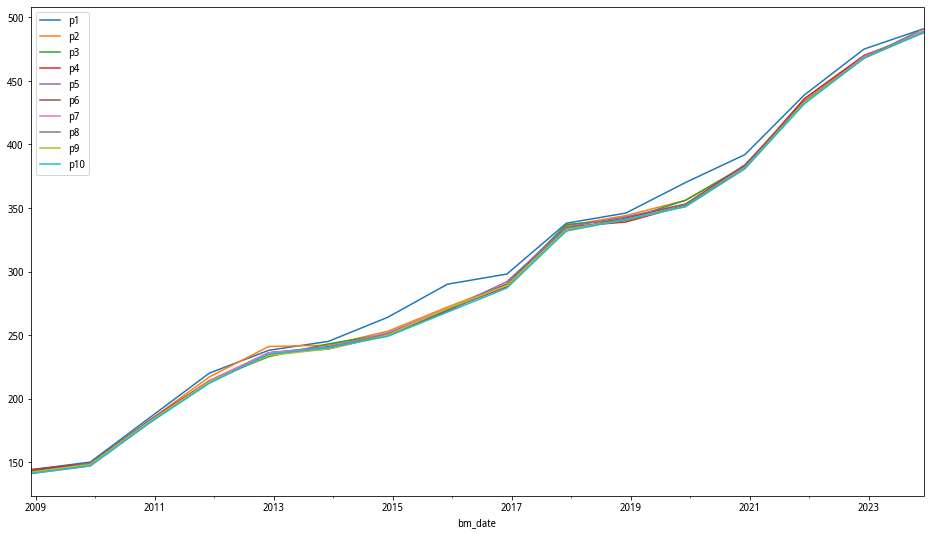

In [129]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('bm_date')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [130]:
portfolios['p10'].groupby('bm_date')['mkt_cap'].mean()/1e9

bm_date
2008-12    24.809703
2009-12    24.776515
2010-12     7.609529
2011-12     4.429930
2012-12     6.856646
2013-12    24.809051
2014-12    30.583072
2015-12    48.396112
2016-12    52.408349
2017-12    25.692625
2018-12    23.570998
2019-12    25.605492
2020-12    28.209597
2021-12    25.285104
2022-12    26.822755
2023-12    31.160605
Freq: M, Name: mkt_cap, dtype: float64

p1            p2            p3            p4            p5  \
bm_date                                                                         
2008-12  8.178973e+09  9.146321e+09  7.169733e+09  6.792753e+09  7.133477e+09   
2009-12  1.086000e+10  8.434011e+09  7.168742e+09  9.046941e+09  9.436160e+09   
2010-12  9.894483e+09  6.872961e+09  5.115607e+09  6.050936e+09  5.913509e+09   
2011-12  8.679166e+09  5.203752e+09  5.832281e+09  8.101809e+09  1.352585e+10   
2012-12  7.933644e+09  7.124045e+09  5.767185e+09  6.531256e+09  8.280338e+09   
2013-12  1.040011e+10  9.919660e+09  8.817553e+09  9.078055e+09  8.530569e+09   
2014-12  1.112403e+10  1.257988e+10  1.256844e+10  1.088796e+10  1.273958e+10   
2015-12  9.314497e+09  9.112856e+09  9.981568e+09  1.014135e+10  9.342858e+09   
2016-12  8.715027e+09  1.307421e+10  8.205977e+09  9.324338e+09  1.049927e+10   
2017-12  1.792234e+10  9.148023e+09  7.195643e+09  9.058651e+09  9.097544e+09   
2018-12  2.195517e+10  1.315840e+10  8.365672e+09  8.507789e+09  1.024115e+10   
2019-12  4.080461e+10  1.924495e+10  1.235015e+10  8.707788e+09  1.382985e+10   
2020-12  5.099567e+10  1.613472e+10  1.336371e+10  1.052788e+10  8.391447e+09   
2021-12  3.754853e+10  1.534978e+10  1.264296e+10  1.072759e+10  1.002252e+10   
2022-12  2.674813e+10  1.460591e+10  1.147212e+10  1.128342e+10  1.104140e+10   
2023-12  1.982568e+10  1.235110e+10  1.498992e+10  1.218862e+10  1.136949e+10   

                   p6            p7            p8            p9           p10  
bm_date                                                                        
2008-12  5.638368e+09  6.113149e+09  5.203166e+09  7.719806e+09  2.480970e+10  
2009-12  1.319322e+10  1.462286e+10  1.163539e+10  3.963020e+09  2.477652e+10  
2010-12  1.177430e+10  1.982726e+10  1.530054e+10  7.867258e+09  7.609529e+09  
2011-12  8.386892e+09  1.470455e+10  7.589739e+09  3.736540e+09  4.429930e+09  
2012-12  1.419138e+10  1.341193e+10  4.797786e+09  6.157433e+09  6.856646e+09  
2013-12  7.203076e+09  1.403315e+10  1.693147e+10  1.861945e+10  2.480905e+10  
2014-12  1.071537e+10  1.053461e+10  1.917828e+10  1.393947e+10  3.058307e+10  
2015-12  1.074729e+10  9.961342e+09  1.031605e+10  1.505106e+10  4.839611e+10  
2016-12  8.515916e+09  1.140932e+10  1.189586e+10  1.531117e+10  5.240835e+10  
2017-12  8.441077e+09  7.968389e+09  1.164186e+10  1.192391e+10  2.569262e+10  
2018-12  9.084155e+09  1.217223e+10  1.472566e+10  1.137340e+10  2.357100e+10  
2019-12  1.314332e+10  1.589170e+10  1.114371e+10  1.191487e+10  2.560549e+10  
2020-12  1.192074e+10  1.180157e+10  1.307650e+10  1.198211e+10  2.820960e+10  
2021-12  7.712885e+09  9.780267e+09  1.306829e+10  1.279645e+10  2.528510e+10  
2022-12  8.854922e+09  9.776261e+09  1.066437e+10  1.341447e+10  2.682276e+10  
2023-12  1.040794e+10  1.053602e+10  9.183234e+09  1.450266e+10  3.116060e+10

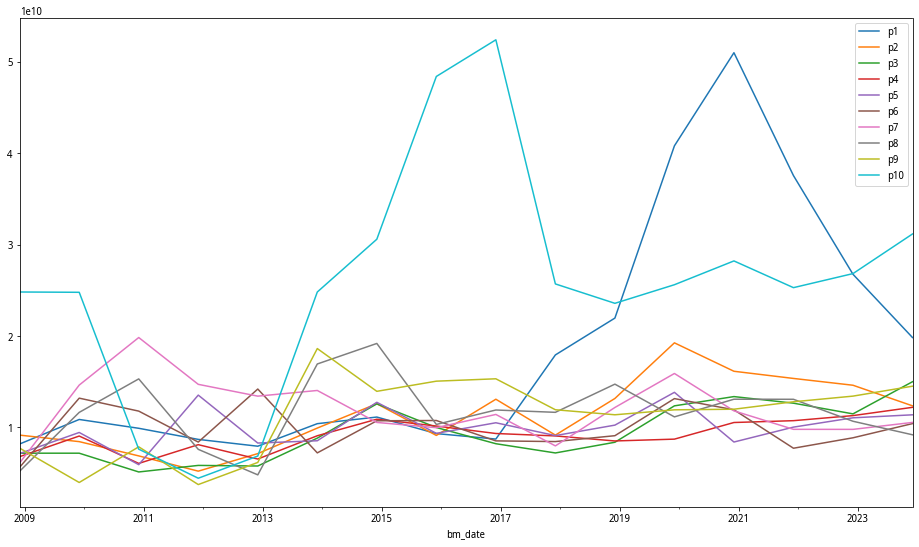

In [131]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('bm_date')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

In [132]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

1.8806254216473737
1.1341285902142255
0.9437953430402802
0.9184820736456951
0.9962188274748356
0.9995677772724555
1.203403856023537
1.1646993971124433
1.1267068246488174
2.5689130236794204


## BM 1年调仓单排结论

排序方法：t年7月至t+1年6月，按照t-1年12月的BM排序，考察区间内每月平均收益率以及区间年平均收益率

结论：
- 月、年平均收益率呈现微弱递增，但p10的收益率较差。
- 最大BM组（也即估值最低组）的market cap起伏很大
- 最小BM组（也即估值最高组）的market cap在样本后期显著增大
- BM的效应可能和market cap有关系

## BM Point-in-Time

In [133]:
del portfolios, portfolios_crs_mean

In [134]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df_pit.pkl')

In [135]:
fundmen_df = pd.read_pickle('./data/fundmen_df_pit.pkl')

In [136]:
fundmen_df

secID publishDate     endDate  endDateRep           actPubtime  \
0       000001.XSHE  2025-03-15  2024-12-31  2024-12-31  2025-03-14 19:28:13   
1       000001.XSHE  2024-10-19  2024-09-30  2024-09-30  2024-10-18 18:00:33   
2       000001.XSHE  2024-08-16  2024-06-30  2024-06-30  2024-08-15 19:33:28   
3       000001.XSHE  2024-04-20  2024-03-31  2024-03-31  2024-04-19 17:56:30   
4       000001.XSHE  2025-03-15  2023-12-31  2024-12-31  2025-03-14 19:28:13   
5       000001.XSHE  2024-10-19  2023-12-31  2024-09-30  2024-10-18 18:00:33   
6       000001.XSHE  2024-08-16  2023-12-31  2024-06-30  2024-08-15 19:33:28   
7       000001.XSHE  2024-04-20  2023-12-31  2024-03-31  2024-04-19 17:56:30   
...             ...         ...         ...         ...                  ...   
516386  900957.XSHG  2010-03-30  2008-12-31  2009-12-31  2010-03-29 18:00:00   
516387  900957.XSHG  2009-10-26  2008-12-31  2009-09-30  2009-10-25 18:00:00   
516388  900957.XSHG  2009-08-01  2008-12-31  2009-06-30  2009-07-31 18:00:00   
516389  900957.XSHG  2009-04-18  2008-12-31  2009-03-31  2009-04-17 18:00:00   
516390  900957.XSHG  2009-03-26  2008-12-31  2008-12-31  2009-03-25 18:00:00   
516391  900957.XSHG  2008-10-24  2008-09-30  2008-09-30  2008-10-23 18:00:00   
516392  900957.XSHG  2008-08-25  2008-06-30  2008-06-30  2008-08-24 18:00:00   
516393  900957.XSHG  2008-04-24  2008-03-31  2008-03-31  2008-04-23 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                12  4.948420e+11  4.948420e+11          NaN  
1                 9  4.904690e+11  4.904690e+11          NaN  
2                 6  4.818690e+11  4.818690e+11          NaN  
3                 3  4.855760e+11  4.855760e+11          NaN  
4                12  4.723280e+11  4.723280e+11          NaN  
5                12  4.723280e+11  4.723280e+11          NaN  
6                12  4.723280e+11  4.723280e+11          NaN  
7                12  4.723280e+11  4.723280e+11          NaN  
...             ...           ...           ...          ...  
516386           12  4.902596e+08  4.369354e+08  53324231.94  
516387           12  4.902596e+08  4.369354e+08  53324231.94  
516388           12  4.902596e+08  4.369354e+08  53324231.94  
516389           12  4.902596e+08  4.369354e+08  53324231.94  
516390           12  4.902596e+08  4.369354e+08  53324231.94  
516391            9  4.324493e+08  3.737685e+08  58680833.72  
516392            6  4.394184e+08  3.780434e+08  61375035.95  
516393            3  4.389698e+08  3.777832e+08  61186603.43  

[516394 rows x 9 columns]

In [137]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [138]:
fundmen_df.sort_values(['secID','publishDate','endDate'],inplace=True)

In [139]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
131     000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
130     000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
129     000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
128     000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
127     000001.XSHE  2009-04-24 2008-12-31  2009-03-31  2009-04-23 18:00:00   
123     000001.XSHE  2009-04-24 2009-03-31  2009-03-31  2009-04-23 18:00:00   
126     000001.XSHE  2009-08-21 2008-12-31  2009-06-30  2009-08-20 18:00:00   
122     000001.XSHE  2009-08-21 2009-06-30  2009-06-30  2009-08-20 18:00:00   
...             ...         ...        ...         ...                  ...   
516270  900957.XSHG  2024-04-12 2022-12-31  2023-12-31  2024-04-11 15:45:08   
516266  900957.XSHG  2024-04-12 2023-12-31  2023-12-31  2024-04-11 15:45:08   
516265  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  2024-04-25 15:32:41   
516262  900957.XSHG  2024-04-26 2024-03-31  2024-03-31  2024-04-25 15:32:41   
516264  900957.XSHG  2024-08-26 2023-12-31  2024-06-30  2024-08-25 15:31:32   
516261  900957.XSHG  2024-08-26 2024-06-30  2024-06-30  2024-08-25 15:31:32   
516263  900957.XSHG  2024-10-29 2023-12-31  2024-09-30  2024-10-28 15:32:41   
516260  900957.XSHG  2024-10-29 2024-09-30  2024-09-30  2024-10-28 15:32:41   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
131               3  1.404138e+10  1.404138e+10          NaN  
130               6  1.694330e+10  1.694330e+10          NaN  
129               9  1.837466e+10  1.837466e+10          NaN  
128              12  1.640079e+10  1.640079e+10          NaN  
127              12  1.640079e+10  1.640079e+10          NaN  
123               3  1.707213e+10  1.707213e+10          NaN  
126              12  1.640079e+10  1.640079e+10          NaN  
122               6  1.798739e+10  1.798739e+10          NaN  
...             ...           ...           ...          ...  
516270           12  5.669258e+08  5.660700e+08    855788.18  
516266           12  6.071647e+08  6.063475e+08    817154.47  
516265           12  6.071647e+08  6.063475e+08    817154.47  
516262            3  6.072715e+08  6.064550e+08    816561.17  
516264           12  6.071647e+08  6.063475e+08    817154.47  
516261            6  6.127041e+08  6.118875e+08    816562.93  
516263           12  6.071647e+08  6.063475e+08    817154.47  
516260            9  6.156863e+08  6.148702e+08    816129.15  

[516394 rows x 9 columns]

In [140]:
fundmen_df.loc[fundmen_df.duplicated(['secID','publishDate'], keep=False)] # 同一报表中包含往期信息

secID publishDate    endDate  endDateRep           actPubtime  \
127     000001.XSHE  2009-04-24 2008-12-31  2009-03-31  2009-04-23 18:00:00   
123     000001.XSHE  2009-04-24 2009-03-31  2009-03-31  2009-04-23 18:00:00   
126     000001.XSHE  2009-08-21 2008-12-31  2009-06-30  2009-08-20 18:00:00   
122     000001.XSHE  2009-08-21 2009-06-30  2009-06-30  2009-08-20 18:00:00   
125     000001.XSHE  2009-10-29 2008-12-31  2009-09-30  2009-10-28 18:00:00   
121     000001.XSHE  2009-10-29 2009-09-30  2009-09-30  2009-10-28 18:00:00   
124     000001.XSHE  2010-03-12 2008-12-31  2009-12-31  2010-03-11 18:00:00   
120     000001.XSHE  2010-03-12 2009-12-31  2009-12-31  2010-03-11 18:00:00   
...             ...         ...        ...         ...                  ...   
516270  900957.XSHG  2024-04-12 2022-12-31  2023-12-31  2024-04-11 15:45:08   
516266  900957.XSHG  2024-04-12 2023-12-31  2023-12-31  2024-04-11 15:45:08   
516265  900957.XSHG  2024-04-26 2023-12-31  2024-03-31  2024-04-25 15:32:41   
516262  900957.XSHG  2024-04-26 2024-03-31  2024-03-31  2024-04-25 15:32:41   
516264  900957.XSHG  2024-08-26 2023-12-31  2024-06-30  2024-08-25 15:31:32   
516261  900957.XSHG  2024-08-26 2024-06-30  2024-06-30  2024-08-25 15:31:32   
516263  900957.XSHG  2024-10-29 2023-12-31  2024-09-30  2024-10-28 15:32:41   
516260  900957.XSHG  2024-10-29 2024-09-30  2024-09-30  2024-10-28 15:32:41   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
127              12  1.640079e+10  1.640079e+10          NaN  
123               3  1.707213e+10  1.707213e+10          NaN  
126              12  1.640079e+10  1.640079e+10          NaN  
122               6  1.798739e+10  1.798739e+10          NaN  
125              12  1.640079e+10  1.640079e+10          NaN  
121               9  1.908844e+10  1.908844e+10          NaN  
124              12  1.640079e+10  1.640079e+10          NaN  
120              12  2.046961e+10  2.046961e+10          NaN  
...             ...           ...           ...          ...  
516270           12  5.669258e+08  5.660700e+08    855788.18  
516266           12  6.071647e+08  6.063475e+08    817154.47  
516265           12  6.071647e+08  6.063475e+08    817154.47  
516262            3  6.072715e+08  6.064550e+08    816561.17  
516264           12  6.071647e+08  6.063475e+08    817154.47  
516261            6  6.127041e+08  6.118875e+08    816562.93  
516263           12  6.071647e+08  6.063475e+08    817154.47  
516260            9  6.156863e+08  6.148702e+08    816129.15  

[508542 rows x 9 columns]

In [141]:
fundmen_df.loc[~fundmen_df.duplicated(['secID','publishDate'], keep=False)] # 只有当期信息

secID publishDate    endDate  endDateRep           actPubtime  \
131     000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
130     000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
129     000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
128     000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
265     000002.XSHE  2008-04-25 2008-03-31  2008-03-31  2008-04-24 18:00:00   
264     000002.XSHE  2008-08-05 2008-06-30  2008-06-30  2008-08-04 18:00:00   
263     000002.XSHE  2008-10-28 2008-09-30  2008-09-30  2008-10-27 18:00:00   
262     000002.XSHE  2009-03-10 2008-12-31  2008-12-31  2009-03-09 18:00:00   
...             ...         ...        ...         ...                  ...   
516259  900956.XSHG  2008-04-26 2008-03-31  2008-03-31  2008-04-25 18:00:00   
516258  900956.XSHG  2008-08-30 2008-06-30  2008-06-30  2008-08-29 18:00:00   
516257  900956.XSHG  2008-10-25 2008-09-30  2008-09-30  2008-10-24 18:00:00   
516256  900956.XSHG  2009-04-11 2008-12-31  2008-12-31  2009-04-10 18:00:00   
516393  900957.XSHG  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
516392  900957.XSHG  2008-08-25 2008-06-30  2008-06-30  2008-08-24 18:00:00   
516391  900957.XSHG  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
516390  900957.XSHG  2009-03-26 2008-12-31  2008-12-31  2009-03-25 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP   minorityInt  
131               3  1.404138e+10  1.404138e+10           NaN  
130               6  1.694330e+10  1.694330e+10           NaN  
129               9  1.837466e+10  1.837466e+10           NaN  
128              12  1.640079e+10  1.640079e+10           NaN  
265               3  3.547986e+10  3.020373e+10  5.276124e+09  
264               6  3.582300e+10  3.001995e+10  5.803053e+09  
263               9  3.685165e+10  3.008923e+10  6.762425e+09  
262              12  3.881855e+10  3.189193e+10  6.926624e+09  
...             ...           ...           ...           ...  
516259            3  5.439410e+08  4.738823e+08  7.005878e+07  
516258            6  5.500809e+08  4.765419e+08  7.353901e+07  
516257            9  5.370822e+08  4.594925e+08  7.758972e+07  
516256           12  5.743349e+08  4.774409e+08  9.689399e+07  
516393            3  4.389698e+08  3.777832e+08  6.118660e+07  
516392            6  4.394184e+08  3.780434e+08  6.137504e+07  
516391            9  4.324493e+08  3.737685e+08  5.868083e+07  
516390           12  4.902596e+08  4.369354e+08  5.332423e+07  

[7852 rows x 9 columns]

In [142]:
fundmen_df = fundmen_df.groupby(['secID','publishDate'],as_index=False).last() #不涉及上上个报表的信息

In [143]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
1       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
2       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
3       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
4       000001.XSHE  2009-04-24 2009-03-31  2009-03-31  2009-04-23 18:00:00   
5       000001.XSHE  2009-08-21 2009-06-30  2009-06-30  2009-08-20 18:00:00   
6       000001.XSHE  2009-10-29 2009-09-30  2009-09-30  2009-10-28 18:00:00   
7       000001.XSHE  2010-03-12 2009-12-31  2009-12-31  2010-03-11 18:00:00   
...             ...         ...        ...         ...                  ...   
229420  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
229421  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
229422  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
229423  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   
229424  900957.XSHG  2024-04-12 2023-12-31  2023-12-31  2024-04-11 15:45:08   
229425  900957.XSHG  2024-04-26 2024-03-31  2024-03-31  2024-04-25 15:32:41   
229426  900957.XSHG  2024-08-26 2024-06-30  2024-06-30  2024-08-25 15:31:32   
229427  900957.XSHG  2024-10-29 2024-09-30  2024-09-30  2024-10-28 15:32:41   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                 3  1.404138e+10  1.404138e+10          NaN  
1                 6  1.694330e+10  1.694330e+10          NaN  
2                 9  1.837466e+10  1.837466e+10          NaN  
3                12  1.640079e+10  1.640079e+10          NaN  
4                 3  1.707213e+10  1.707213e+10          NaN  
5                 6  1.798739e+10  1.798739e+10          NaN  
6                 9  1.908844e+10  1.908844e+10          NaN  
7                12  2.046961e+10  2.046961e+10          NaN  
...             ...           ...           ...          ...  
229420           12  5.669258e+08  5.660700e+08    855788.18  
229421            3  5.756460e+08  5.747912e+08    854765.57  
229422            6  5.862225e+08  5.853687e+08    853798.86  
229423            9  5.983664e+08  5.975140e+08    852427.19  
229424           12  6.071647e+08  6.063475e+08    817154.47  
229425            3  6.072715e+08  6.064550e+08    816561.17  
229426            6  6.127041e+08  6.118875e+08    816562.93  
229427            9  6.156863e+08  6.148702e+08    816129.15  

[229428 rows x 9 columns]

In [144]:
fundmen_df['secID'].str[-4:].unique()

array(['XSHE', 'SHE2', 'XSHG'], dtype=object)

In [145]:
fundmen_df.loc[fundmen_df['secID'].str.endswith('SHE2')]

secID publishDate    endDate  endDateRep           actPubtime  \
2527  000043.XSHE2  2008-04-22 2008-03-31  2008-03-31  2008-04-21 18:00:00   
2528  000043.XSHE2  2008-08-19 2008-06-30  2008-06-30  2008-08-18 18:00:00   
2529  000043.XSHE2  2008-10-27 2008-09-30  2008-09-30  2008-10-26 18:00:00   
2530  000043.XSHE2  2009-04-10 2008-12-31  2008-12-31  2009-04-09 18:00:00   
2531  000043.XSHE2  2009-04-28 2009-03-31  2009-03-31  2009-04-27 18:00:00   
2532  000043.XSHE2  2009-07-23 2009-06-30  2009-06-30  2009-07-22 18:00:00   
2533  000043.XSHE2  2009-10-27 2009-09-30  2009-09-30  2009-10-26 18:00:00   
2534  000043.XSHE2  2010-03-16 2009-12-31  2009-12-31  2010-03-15 18:00:00   
...            ...         ...        ...         ...                  ...   
2587  000043.XSHE2  2023-04-22 2023-03-31  2023-03-31  2023-04-21 18:09:31   
2588  000043.XSHE2  2023-08-25 2023-06-30  2023-06-30  2023-08-24 16:04:57   
2589  000043.XSHE2  2023-10-27 2023-09-30  2023-09-30  2023-10-26 18:24:59   
2590  000043.XSHE2  2024-03-16 2023-12-31  2023-12-31  2024-03-15 20:29:31   
2591  000043.XSHE2  2024-04-26 2024-03-31  2024-03-31  2024-04-25 19:42:48   
2592  000043.XSHE2  2024-08-30 2024-06-30  2024-06-30  2024-08-29 19:28:21   
2593  000043.XSHE2  2024-10-31 2024-09-30  2024-09-30  2024-10-30 19:42:35   
2594  000043.XSHE2  2025-03-17 2024-12-31  2024-12-31  2025-03-16 15:32:30   

     fiscalPeriod     TShEquity  TEquityAttrP   minorityInt  
2527            3  1.754624e+09  1.497749e+09  2.568750e+08  
2528            6  1.660061e+09  1.441032e+09  2.190291e+08  
2529            9  1.797560e+09  1.429033e+09  3.685271e+08  
2530           12  1.743831e+09  1.446562e+09  2.972697e+08  
2531            3  2.031279e+09  1.673443e+09  3.578353e+08  
2532            6  2.048404e+09  1.679233e+09  3.691707e+08  
2533            9  2.041002e+09  1.669816e+09  3.711865e+08  
2534           12  2.077269e+09  1.716617e+09  3.606526e+08  
...           ...           ...           ...           ...  
2587            3  9.503130e+09  9.334366e+09  1.687640e+08  
2588            6  9.746350e+09  9.569769e+09  1.765801e+08  
2589            9  9.809555e+09  9.618211e+09  1.913436e+08  
2590           12  9.910374e+09  9.759359e+09  1.510153e+08  
2591            3  1.011193e+10  9.950632e+09  1.612996e+08  
2592            6  1.018513e+10  1.001503e+10  1.701023e+08  
2593            9  1.036198e+10  1.020686e+10  1.551216e+08  
2594           12  1.057032e+10  1.041897e+10  1.513532e+08  

[68 rows x 9 columns]

In [146]:
DataAPI.FdmtBSGet(secID='000043.XSHE2',beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","secShortName","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

secID secShortName publishDate     endDate  endDateRep  \
0    000043.XSHE2         中航善达  2025-03-17  2024-12-31  2024-12-31   
1    000043.XSHE2         中航善达  2024-10-31  2024-09-30  2024-09-30   
2    000043.XSHE2         中航善达  2024-08-30  2024-06-30  2024-06-30   
3    000043.XSHE2         中航善达  2024-04-26  2024-03-31  2024-03-31   
4    000043.XSHE2         中航善达  2025-03-17  2023-12-31  2024-12-31   
5    000043.XSHE2         中航善达  2024-10-31  2023-12-31  2024-09-30   
6    000043.XSHE2         中航善达  2024-08-30  2023-12-31  2024-06-30   
7    000043.XSHE2         中航善达  2024-04-26  2023-12-31  2024-03-31   
..            ...          ...         ...         ...         ...   
124  000043.XSHE2         中航善达  2010-03-16  2008-12-31  2009-12-31   
125  000043.XSHE2         中航善达  2009-10-27  2008-12-31  2009-09-30   
126  000043.XSHE2         中航善达  2009-07-23  2008-12-31  2009-06-30   
127  000043.XSHE2         中航善达  2009-04-28  2008-12-31  2009-03-31   
128  000043.XSHE2         中航善达  2009-04-10  2008-12-31  2008-12-31   
129  000043.XSHE2         中航善达  2008-10-27  2008-09-30  2008-09-30   
130  000043.XSHE2         中航善达  2008-08-19  2008-06-30  2008-06-30   
131  000043.XSHE2         中航善达  2008-04-22  2008-03-31  2008-03-31   

              actPubtime fiscalPeriod     TShEquity  TEquityAttrP  \
0    2025-03-16 15:32:30           12  1.057032e+10  1.041897e+10   
1    2024-10-30 19:42:35            9  1.036198e+10  1.020686e+10   
2    2024-08-29 19:28:21            6  1.018513e+10  1.001503e+10   
3    2024-04-25 19:42:48            3  1.011193e+10  9.950632e+09   
4    2025-03-16 15:32:30           12  9.910374e+09  9.759359e+09   
5    2024-10-30 19:42:35           12  9.910374e+09  9.759359e+09   
6    2024-08-29 19:28:21           12  9.910374e+09  9.759359e+09   
7    2024-04-25 19:42:48           12  9.910374e+09  9.759359e+09   
..                   ...          ...           ...           ...   
124  2010-03-15 18:00:00           12  2.014681e+09  1.697758e+09   
125  2009-10-26 18:00:00           12  2.014681e+09  1.697758e+09   
126  2009-07-22 18:00:00           12  2.014681e+09  1.697758e+09   
127  2009-04-27 18:00:00           12  2.014681e+09  1.697758e+09   
128  2009-04-09 18:00:00           12  1.743831e+09  1.446562e+09   
129  2008-10-26 18:00:00            9  1.797560e+09  1.429033e+09   
130  2008-08-18 18:00:00            6  1.660061e+09  1.441032e+09   
131  2008-04-21 18:00:00            3  1.754624e+09  1.497749e+09   

      minorityInt  
0    1.513532e+08  
1    1.551216e+08  
2    1.701023e+08  
3    1.612996e+08  
4    1.510153e+08  
5    1.510153e+08  
6    1.510153e+08  
7    1.510153e+08  
..            ...  
124  3.169230e+08  
125  3.169230e+08  
126  3.169230e+08  
127  3.169230e+08  
128  2.972697e+08  
129  3.685271e+08  
130  2.190291e+08  
131  2.568750e+08  

[132 rows x 10 columns]

In [147]:
fundmen_df = fundmen_df[(fundmen_df['secID'].str.endswith('XSHE')) | (fundmen_df['secID'].str.endswith('XSHG'))]

In [148]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [149]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [150]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
1       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
2       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
3       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
4       000001.XSHE  2009-04-24 2009-03-31  2009-03-31  2009-04-23 18:00:00   
5       000001.XSHE  2009-08-21 2009-06-30  2009-06-30  2009-08-20 18:00:00   
6       000001.XSHE  2009-10-29 2009-09-30  2009-09-30  2009-10-28 18:00:00   
7       000001.XSHE  2010-03-12 2009-12-31  2009-12-31  2010-03-11 18:00:00   
...             ...         ...        ...         ...                  ...   
229420  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
229421  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
229422  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
229423  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   
229424  900957.XSHG  2024-04-12 2023-12-31  2023-12-31  2024-04-11 15:45:08   
229425  900957.XSHG  2024-04-26 2024-03-31  2024-03-31  2024-04-25 15:32:41   
229426  900957.XSHG  2024-08-26 2024-06-30  2024-06-30  2024-08-25 15:31:32   
229427  900957.XSHG  2024-10-29 2024-09-30  2024-09-30  2024-10-28 15:32:41   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt          book  
0                 3  1.404138e+10  1.404138e+10          NaN  1.404138e+10  
1                 6  1.694330e+10  1.694330e+10          NaN  1.694330e+10  
2                 9  1.837466e+10  1.837466e+10          NaN  1.837466e+10  
3                12  1.640079e+10  1.640079e+10          NaN  1.640079e+10  
4                 3  1.707213e+10  1.707213e+10          NaN  1.707213e+10  
5                 6  1.798739e+10  1.798739e+10          NaN  1.798739e+10  
6                 9  1.908844e+10  1.908844e+10          NaN  1.908844e+10  
7                12  2.046961e+10  2.046961e+10          NaN  2.046961e+10  
...             ...           ...           ...          ...           ...  
229420           12  5.669258e+08  5.660700e+08    855788.18  5.660700e+08  
229421            3  5.756460e+08  5.747912e+08    854765.57  5.747912e+08  
229422            6  5.862225e+08  5.853687e+08    853798.86  5.853687e+08  
229423            9  5.983664e+08  5.975140e+08    852427.19  5.975140e+08  
229424           12  6.071647e+08  6.063475e+08    817154.47  6.063475e+08  
229425            3  6.072715e+08  6.064550e+08    816561.17  6.064550e+08  
229426            6  6.127041e+08  6.118875e+08    816562.93  6.118875e+08  
229427            9  6.156863e+08  6.148702e+08    816129.15  6.148702e+08  

[229360 rows x 10 columns]

- ~~考虑到报表公布时间可能在当天收市以后，以及报表解读可能需要时间，把publishDate往后加1~~
- publishDate和 tradeDate merge, 
- publishDate可能是非交易日，所以merge时要outer，左右表格都不丢观测值。
- 接着要把tradeDate为空值的设置为publishDate，便于排序，方便下面填充
- 然后按照secID和tradeDate sort，因为publishDate非交易日的被放到merge表格的最后了。
- 接着 book 空值由上面第一个非空值填充（当时已知的最新的book value）
- 再把 na 都丢弃即可

In [151]:
# fundmen_df['publishDate+1'] = fundmen_df['publishDate'] + dt.timedelta(days=1)

In [152]:
stk_fundmen_df = pd.merge(stk_df, fundmen_df[['secID','publishDate','endDate','book']], 
                          left_on=['secID','tradeDate'], right_on=['secID','publishDate'],
                          how='outer')

In [153]:
stk_fundmen_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...               ...        ...           ...         ...             ...   
12950139  900957.XSHG        NaT           NaN         NaN             NaN   
12950140  900957.XSHG        NaT           NaN         NaN             NaN   
12950141  900957.XSHG        NaT           NaN         NaN             NaN   
12950142  900957.XSHG        NaT           NaN         NaN             NaN   
12950143  900957.XSHG        NaT           NaN         NaN             NaN   
12950144  900957.XSHG        NaT           NaN         NaN             NaN   
12950145  900957.XSHG        NaT           NaN         NaN             NaN   
12950146  900957.XSHG        NaT           NaN         NaN             NaN   

         turnoverValue turnoverRate       ym publishDate    endDate  \
0          7.63466e+08       0.0114  2008-01         NaT        NaT   
1          1.02342e+09       0.0157  2008-01         NaT        NaT   
2          7.62161e+08       0.0113  2008-01         NaT        NaT   
3          1.23691e+09       0.0179  2008-01         NaT        NaT   
4          2.02925e+09       0.0285  2008-01         NaT        NaT   
5          7.86313e+08        0.011  2008-01         NaT        NaT   
6          1.01674e+09       0.0139  2008-01         NaT        NaT   
7          1.55517e+09       0.0204  2008-01         NaT        NaT   
...                ...          ...      ...         ...        ...   
12950139           NaN          NaN      NaT  2023-04-08 2022-12-31   
12950140           NaN          NaN      NaT  2023-04-27 2023-03-31   
12950141           NaN          NaN      NaT  2023-08-08 2023-06-30   
12950142           NaN          NaN      NaT  2023-10-28 2023-09-30   
12950143           NaN          NaN      NaT  2024-04-12 2023-12-31   
12950144           NaN          NaN      NaT  2024-04-26 2024-03-31   
12950145           NaN          NaN      NaT  2024-08-26 2024-06-30   
12950146           NaN          NaN      NaT  2024-10-29 2024-09-30   

                  book  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
12950139  5.660700e+08  
12950140  5.747912e+08  
12950141  5.853687e+08  
12950142  5.975140e+08  
12950143  6.063475e+08  
12950144  6.064550e+08  
12950145  6.118875e+08  
12950146  6.148702e+08  

[12950147 rows x 11 columns]

In [154]:
stk_fundmen_df.loc[(stk_fundmen_df['secID']=='900957.XSHG')&(stk_fundmen_df['tradeDate']<='2016-08-10')&(stk_fundmen_df['tradeDate']>='2016-08-03')]

Empty DataFrame
Columns: [secID, tradeDate, preClosePrice, closePrice, negMarketValue, turnoverValue, turnoverRate, ym, publishDate, endDate, book]
Index: []

In [155]:
stk_fundmen_df.loc[(stk_fundmen_df['secID']=='000001.XSHE')&(stk_fundmen_df['tradeDate']<='2009')&(stk_fundmen_df['tradeDate']>='2008-08-10')]

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
149  000001.XSHE 2008-08-11         632.9     610.748    4.134069e+10   
150  000001.XSHE 2008-08-12       610.748     610.748    4.134069e+10   
151  000001.XSHE 2008-08-13       610.748     610.432    4.131927e+10   
152  000001.XSHE 2008-08-14       610.432     610.432    4.131927e+10   
153  000001.XSHE 2008-08-15       610.432     620.242    4.198329e+10   
154  000001.XSHE 2008-08-18       620.242     602.204    4.076234e+10   
155  000001.XSHE 2008-08-19       602.204     609.166    4.123358e+10   
156  000001.XSHE 2008-08-20       609.166     659.798    4.466079e+10   
..           ...        ...           ...         ...             ...   
238  000001.XSHE 2008-12-22       434.475     424.985    2.868144e+10   
239  000001.XSHE 2008-12-23       424.985     420.034    2.834729e+10   
240  000001.XSHE 2008-12-24       420.034     417.558    2.818021e+10   
241  000001.XSHE 2008-12-25       417.558     403.530    2.723344e+10   
242  000001.XSHE 2008-12-26        403.53     401.054    2.706637e+10   
243  000001.XSHE 2008-12-29       401.054     390.739    2.637022e+10   
244  000001.XSHE 2008-12-30       390.739     391.977    2.645375e+10   
245  000001.XSHE 2008-12-31       391.977     390.326    2.634237e+10   

    turnoverValue turnoverRate       ym publishDate endDate  book  
149   1.97994e+08       0.0046  2008-08         NaT     NaT   NaN  
150   1.49263e+08       0.0036  2008-08         NaT     NaT   NaN  
151   1.33439e+08       0.0033  2008-08         NaT     NaT   NaN  
152   6.14423e+07       0.0015  2008-08         NaT     NaT   NaN  
153   1.42602e+08       0.0034  2008-08         NaT     NaT   NaN  
154   1.50179e+08       0.0036  2008-08         NaT     NaT   NaN  
155   8.54485e+07       0.0021  2008-08         NaT     NaT   NaN  
156   3.57637e+08       0.0082  2008-08         NaT     NaT   NaN  
..            ...          ...      ...         ...     ...   ...  
238   3.52121e+08       0.0122  2008-12         NaT     NaT   NaN  
239   5.17378e+08       0.0182  2008-12         NaT     NaT   NaN  
240   3.51842e+08       0.0124  2008-12         NaT     NaT   NaN  
241    3.0569e+08        0.011  2008-12         NaT     NaT   NaN  
242   2.59659e+08       0.0095  2008-12         NaT     NaT   NaN  
243   2.60911e+08         0.01  2008-12         NaT     NaT   NaN  
244   3.10284e+08       0.0118  2008-12         NaT     NaT   NaN  
245   2.19748e+08       0.0083  2008-12         NaT     NaT   NaN  

[97 rows x 11 columns]

In [156]:
stk_fundmen_df.loc[(~stk_fundmen_df['tradeDate'].isna())&(~stk_fundmen_df['publishDate'].isna())]

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
75        000001.XSHE 2008-04-24       790.808     869.921    4.829500e+10   
157       000001.XSHE 2008-08-21       659.798     639.545    4.328991e+10   
197       000001.XSHE 2008-10-24       396.828     380.689    2.576831e+10   
295       000001.XSHE 2009-03-20       651.507     632.527    4.268801e+10   
319       000001.XSHE 2009-04-24       627.575     632.527    4.268801e+10   
401       000001.XSHE 2009-08-21       889.581     910.624    6.452731e+10   
444       000001.XSHE 2009-10-29       902.784     916.400    6.494458e+10   
534       000001.XSHE 2010-03-12       976.228     945.695    6.702070e+10   
...               ...        ...           ...         ...             ...   
12878448  689009.XSHG 2023-03-31          38.2      37.640    1.926039e+10   
12878466  689009.XSHG 2023-04-27          34.7      32.800    1.678376e+10   
12878547  689009.XSHG 2023-08-25         30.51      30.630    1.567337e+10   
12878588  689009.XSHG 2023-10-31            33      32.790    1.716478e+10   
12878691  689009.XSHG 2024-04-02         31.05      30.370    1.565501e+10   
12878706  689009.XSHG 2024-04-25         31.81      35.300    1.819630e+10   
12878776  689009.XSHG 2024-08-07        41.762      44.894    2.435352e+10   
12878828  689009.XSHG 2024-10-29        48.721      46.123    2.502155e+10   

         turnoverValue turnoverRate       ym publishDate    endDate  \
75         1.34804e+09       0.0282  2008-04  2008-04-24 2008-03-31   
157        1.70345e+08       0.0039  2008-08  2008-08-21 2008-06-30   
197        3.50582e+08       0.0134  2008-10  2008-10-24 2008-09-30   
295         9.7472e+08       0.0229  2009-03  2009-03-20 2008-12-31   
319        5.31858e+08       0.0122  2009-04  2009-04-24 2009-03-31   
401        1.04447e+09       0.0162  2009-08  2009-08-21 2009-06-30   
444        8.29904e+08       0.0128  2009-10  2009-10-29 2009-09-30   
534         6.5591e+08       0.0097  2010-03  2010-03-12 2009-12-31   
...                ...          ...      ...         ...        ...   
12878448   3.40997e+08       0.0178  2023-03  2023-03-31 2022-12-31   
12878466   2.72783e+08       0.0162  2023-04  2023-04-27 2023-03-31   
12878547   1.10894e+08        0.007  2023-08  2023-08-25 2023-06-30   
12878588    6.5623e+07       0.0038  2023-10  2023-10-31 2023-09-30   
12878691   1.32011e+08       0.0084  2024-04  2024-04-02 2023-12-31   
12878706   1.04277e+09       0.0565  2024-04  2024-04-25 2024-03-31   
12878776   9.73013e+08       0.0396  2024-08  2024-08-07 2024-06-30   
12878828   7.44795e+08       0.0293  2024-10  2024-10-29 2024-09-30   

                  book  
75        1.404138e+10  
157       1.694330e+10  
197       1.837466e+10  
295       1.640079e+10  
319       1.707213e+10  
401       1.798739e+10  
444       1.908844e+10  
534       2.046961e+10  
...                ...  
12878448  4.896933e+09  
12878466  4.993789e+09  
12878547  5.230683e+09  
12878588  5.291142e+09  
12878691  5.456715e+09  
12878706  5.336277e+09  
12878776  5.621255e+09  
12878828  6.056702e+09  

[158148 rows x 11 columns]

In [157]:
print(stk_fundmen_df.loc[(stk_fundmen_df['secID']=='000001.XSHE')&(stk_fundmen_df['ym']=='2017-04')].to_string())

            secID  tradeDate preClosePrice  closePrice  negMarketValue turnoverValue turnoverRate       ym publishDate endDate  book
2249  000001.XSHE 2017-04-05       1103.66    1108.473    1.558147e+11   4.58568e+08        0.003  2017-04         NaT     NaT   NaN
2250  000001.XSHE 2017-04-06       1108.47    1107.270    1.556455e+11   3.99119e+08       0.0026  2017-04         NaT     NaT   NaN
2251  000001.XSHE 2017-04-07       1107.27    1107.270    1.556455e+11   4.73366e+08        0.003  2017-04         NaT     NaT   NaN
2252  000001.XSHE 2017-04-10       1107.27    1104.863    1.553071e+11   3.68682e+08       0.0024  2017-04         NaT     NaT   NaN
2253  000001.XSHE 2017-04-11       1104.86    1101.252    1.547996e+11   5.60304e+08       0.0036  2017-04         NaT     NaT   NaN
2254  000001.XSHE 2017-04-12       1101.25    1097.641    1.542921e+11   4.16101e+08       0.0027  2017-04         NaT     NaT   NaN
2255  000001.XSHE 2017-04-13       1097.64    1097.641    1.542921e+1

In [158]:
idx = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna()].index

In [159]:
stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'tradeDate'] = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'publishDate']

In [160]:
stk_fundmen_df.loc[idx]

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
12878935  000001.XSHE 2017-04-22           NaN         NaN             NaN   
12878936  000001.XSHE 2017-10-21           NaN         NaN             NaN   
12878937  000001.XSHE 2024-04-20           NaN         NaN             NaN   
12878938  000001.XSHE 2024-10-19           NaN         NaN             NaN   
12878939  000001.XSHE 2025-03-15           NaN         NaN             NaN   
12878940  000002.XSHE 2022-10-29           NaN         NaN             NaN   
12878941  000002.XSHE 2023-04-29           NaN         NaN             NaN   
12878942  000002.XSHE 2023-10-28           NaN         NaN             NaN   
...               ...        ...           ...         ...             ...   
12950139  900957.XSHG 2023-04-08           NaN         NaN             NaN   
12950140  900957.XSHG 2023-04-27           NaN         NaN             NaN   
12950141  900957.XSHG 2023-08-08           NaN         NaN             NaN   
12950142  900957.XSHG 2023-10-28           NaN         NaN             NaN   
12950143  900957.XSHG 2024-04-12           NaN         NaN             NaN   
12950144  900957.XSHG 2024-04-26           NaN         NaN             NaN   
12950145  900957.XSHG 2024-08-26           NaN         NaN             NaN   
12950146  900957.XSHG 2024-10-29           NaN         NaN             NaN   

         turnoverValue turnoverRate   ym publishDate    endDate          book  
12878935           NaN          NaN  NaT  2017-04-22 2017-03-31  2.077390e+11  
12878936           NaN          NaN  NaT  2017-10-21 2017-09-30  2.181110e+11  
12878937           NaN          NaN  NaT  2024-04-20 2024-03-31  4.855760e+11  
12878938           NaN          NaN  NaT  2024-10-19 2024-09-30  4.904690e+11  
12878939           NaN          NaN  NaT  2025-03-15 2024-12-31  4.948420e+11  
12878940           NaN          NaN  NaT  2022-10-29 2022-09-30  2.411070e+11  
12878941           NaN          NaN  NaT  2023-04-29 2023-03-31  2.460123e+11  
12878942           NaN          NaN  NaT  2023-10-28 2023-09-30  2.529078e+11  
...                ...          ...  ...         ...        ...           ...  
12950139           NaN          NaN  NaT  2023-04-08 2022-12-31  5.660700e+08  
12950140           NaN          NaN  NaT  2023-04-27 2023-03-31  5.747912e+08  
12950141           NaN          NaN  NaT  2023-08-08 2023-06-30  5.853687e+08  
12950142           NaN          NaN  NaT  2023-10-28 2023-09-30  5.975140e+08  
12950143           NaN          NaN  NaT  2024-04-12 2023-12-31  6.063475e+08  
12950144           NaN          NaN  NaT  2024-04-26 2024-03-31  6.064550e+08  
12950145           NaN          NaN  NaT  2024-08-26 2024-06-30  6.118875e+08  
12950146           NaN          NaN  NaT  2024-10-29 2024-09-30  6.148702e+08  

[71212 rows x 11 columns]

In [161]:
print(stk_fundmen_df.loc[(stk_fundmen_df['secID']=='000001.XSHE')&(stk_fundmen_df['tradeDate']<'2017-05')
                         &(stk_fundmen_df['tradeDate']>='2017-04')].to_string())

                secID  tradeDate preClosePrice  closePrice  negMarketValue turnoverValue turnoverRate       ym publishDate    endDate          book
2249      000001.XSHE 2017-04-05       1103.66    1108.473    1.558147e+11   4.58568e+08        0.003  2017-04         NaT        NaT           NaN
2250      000001.XSHE 2017-04-06       1108.47    1107.270    1.556455e+11   3.99119e+08       0.0026  2017-04         NaT        NaT           NaN
2251      000001.XSHE 2017-04-07       1107.27    1107.270    1.556455e+11   4.73366e+08        0.003  2017-04         NaT        NaT           NaN
2252      000001.XSHE 2017-04-10       1107.27    1104.863    1.553071e+11   3.68682e+08       0.0024  2017-04         NaT        NaT           NaN
2253      000001.XSHE 2017-04-11       1104.86    1101.252    1.547996e+11   5.60304e+08       0.0036  2017-04         NaT        NaT           NaN
2254      000001.XSHE 2017-04-12       1101.25    1097.641    1.542921e+11   4.16101e+08       0.0027  2017-04  

In [162]:
stk_fundmen_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...               ...        ...           ...         ...             ...   
12950139  900957.XSHG 2023-04-08           NaN         NaN             NaN   
12950140  900957.XSHG 2023-04-27           NaN         NaN             NaN   
12950141  900957.XSHG 2023-08-08           NaN         NaN             NaN   
12950142  900957.XSHG 2023-10-28           NaN         NaN             NaN   
12950143  900957.XSHG 2024-04-12           NaN         NaN             NaN   
12950144  900957.XSHG 2024-04-26           NaN         NaN             NaN   
12950145  900957.XSHG 2024-08-26           NaN         NaN             NaN   
12950146  900957.XSHG 2024-10-29           NaN         NaN             NaN   

         turnoverValue turnoverRate       ym publishDate    endDate  \
0          7.63466e+08       0.0114  2008-01         NaT        NaT   
1          1.02342e+09       0.0157  2008-01         NaT        NaT   
2          7.62161e+08       0.0113  2008-01         NaT        NaT   
3          1.23691e+09       0.0179  2008-01         NaT        NaT   
4          2.02925e+09       0.0285  2008-01         NaT        NaT   
5          7.86313e+08        0.011  2008-01         NaT        NaT   
6          1.01674e+09       0.0139  2008-01         NaT        NaT   
7          1.55517e+09       0.0204  2008-01         NaT        NaT   
...                ...          ...      ...         ...        ...   
12950139           NaN          NaN      NaT  2023-04-08 2022-12-31   
12950140           NaN          NaN      NaT  2023-04-27 2023-03-31   
12950141           NaN          NaN      NaT  2023-08-08 2023-06-30   
12950142           NaN          NaN      NaT  2023-10-28 2023-09-30   
12950143           NaN          NaN      NaT  2024-04-12 2023-12-31   
12950144           NaN          NaN      NaT  2024-04-26 2024-03-31   
12950145           NaN          NaN      NaT  2024-08-26 2024-06-30   
12950146           NaN          NaN      NaT  2024-10-29 2024-09-30   

                  book  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
12950139  5.660700e+08  
12950140  5.747912e+08  
12950141  5.853687e+08  
12950142  5.975140e+08  
12950143  6.063475e+08  
12950144  6.064550e+08  
12950145  6.118875e+08  
12950146  6.148702e+08  

[12950147 rows x 11 columns]

In [163]:
stk_fundmen_df.sort_values(['secID','tradeDate'],inplace=True)

In [164]:
stk_fundmen_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...               ...        ...           ...         ...             ...   
12950139  900957.XSHG 2023-04-08           NaN         NaN             NaN   
12950140  900957.XSHG 2023-04-27           NaN         NaN             NaN   
12950141  900957.XSHG 2023-08-08           NaN         NaN             NaN   
12950142  900957.XSHG 2023-10-28           NaN         NaN             NaN   
12950143  900957.XSHG 2024-04-12           NaN         NaN             NaN   
12950144  900957.XSHG 2024-04-26           NaN         NaN             NaN   
12950145  900957.XSHG 2024-08-26           NaN         NaN             NaN   
12950146  900957.XSHG 2024-10-29           NaN         NaN             NaN   

         turnoverValue turnoverRate       ym publishDate    endDate  \
0          7.63466e+08       0.0114  2008-01         NaT        NaT   
1          1.02342e+09       0.0157  2008-01         NaT        NaT   
2          7.62161e+08       0.0113  2008-01         NaT        NaT   
3          1.23691e+09       0.0179  2008-01         NaT        NaT   
4          2.02925e+09       0.0285  2008-01         NaT        NaT   
5          7.86313e+08        0.011  2008-01         NaT        NaT   
6          1.01674e+09       0.0139  2008-01         NaT        NaT   
7          1.55517e+09       0.0204  2008-01         NaT        NaT   
...                ...          ...      ...         ...        ...   
12950139           NaN          NaN      NaT  2023-04-08 2022-12-31   
12950140           NaN          NaN      NaT  2023-04-27 2023-03-31   
12950141           NaN          NaN      NaT  2023-08-08 2023-06-30   
12950142           NaN          NaN      NaT  2023-10-28 2023-09-30   
12950143           NaN          NaN      NaT  2024-04-12 2023-12-31   
12950144           NaN          NaN      NaT  2024-04-26 2024-03-31   
12950145           NaN          NaN      NaT  2024-08-26 2024-06-30   
12950146           NaN          NaN      NaT  2024-10-29 2024-09-30   

                  book  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
12950139  5.660700e+08  
12950140  5.747912e+08  
12950141  5.853687e+08  
12950142  5.975140e+08  
12950143  6.063475e+08  
12950144  6.064550e+08  
12950145  6.118875e+08  
12950146  6.148702e+08  

[12950147 rows x 11 columns]

In [165]:
temp = stk_fundmen_df[stk_fundmen_df['secID']=='000001.XSHE'].copy()
temp

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0     000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1     000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2     000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3     000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4     000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5     000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6     000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7     000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
...           ...        ...           ...         ...             ...   
4186  000001.XSHE 2025-03-26       1677.03    1669.697    2.208354e+11   
4187  000001.XSHE 2025-03-27        1669.7    1671.165    2.210295e+11   
4188  000001.XSHE 2025-03-28       1671.16    1665.296    2.202532e+11   
4189  000001.XSHE 2025-03-31        1665.3    1652.091    2.185067e+11   
4190  000001.XSHE 2025-04-01       1652.09    1653.558    2.187008e+11   
4191  000001.XSHE 2025-04-02       1653.56    1668.230    2.206414e+11   
4192  000001.XSHE 2025-04-03       1668.23    1663.828    2.200592e+11   
4193  000001.XSHE 2025-04-07       1663.83    1569.926    2.076396e+11   

     turnoverValue turnoverRate       ym publishDate endDate  book  
0      7.63466e+08       0.0114  2008-01         NaT     NaT   NaN  
1      1.02342e+09       0.0157  2008-01         NaT     NaT   NaN  
2      7.62161e+08       0.0113  2008-01         NaT     NaT   NaN  
3      1.23691e+09       0.0179  2008-01         NaT     NaT   NaN  
4      2.02925e+09       0.0285  2008-01         NaT     NaT   NaN  
5      7.86313e+08        0.011  2008-01         NaT     NaT   NaN  
6      1.01674e+09       0.0139  2008-01         NaT     NaT   NaN  
7      1.55517e+09       0.0204  2008-01         NaT     NaT   NaN  
...            ...          ...      ...         ...     ...   ...  
4186   8.43537e+08       0.0038  2025-03         NaT     NaT   NaN  
4187   6.29863e+08       0.0029  2025-03         NaT     NaT   NaN  
4188   7.32421e+08       0.0033  2025-03         NaT     NaT   NaN  
4189    1.2626e+09       0.0058  2025-03         NaT     NaT   NaN  
4190   7.67424e+08       0.0035  2025-04         NaT     NaT   NaN  
4191   1.05875e+09       0.0048  2025-04         NaT     NaT   NaN  
4192   7.30376e+08       0.0033  2025-04         NaT     NaT   NaN  
4193   2.75106e+09       0.0131  2025-04         NaT     NaT   NaN  

[4199 rows x 11 columns]

In [166]:
temp[~temp['book'].isna()]

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
75        000001.XSHE 2008-04-24       790.808     869.921    4.829500e+10   
157       000001.XSHE 2008-08-21       659.798     639.545    4.328991e+10   
197       000001.XSHE 2008-10-24       396.828     380.689    2.576831e+10   
295       000001.XSHE 2009-03-20       651.507     632.527    4.268801e+10   
319       000001.XSHE 2009-04-24       627.575     632.527    4.268801e+10   
401       000001.XSHE 2009-08-21       889.581     910.624    6.452731e+10   
444       000001.XSHE 2009-10-29       902.784     916.400    6.494458e+10   
534       000001.XSHE 2010-03-12       976.228     945.695    6.702070e+10   
...               ...        ...           ...         ...             ...   
3723      000001.XSHE 2023-04-25       1582.96    1606.511    2.383001e+11   
3805      000001.XSHE 2023-08-24       1508.28    1492.196    2.159837e+11   
3843      000001.XSHE 2023-10-25       1414.44    1391.644    2.014296e+11   
3938      000001.XSHE 2024-03-15       1371.53    1421.139    2.056988e+11   
12878937  000001.XSHE 2024-04-20           NaN         NaN             NaN   
4042      000001.XSHE 2024-08-16       1440.63    1454.991    1.965789e+11   
12878938  000001.XSHE 2024-10-19           NaN         NaN             NaN   
12878939  000001.XSHE 2025-03-15           NaN         NaN             NaN   

         turnoverValue turnoverRate       ym publishDate    endDate  \
75         1.34804e+09       0.0282  2008-04  2008-04-24 2008-03-31   
157        1.70345e+08       0.0039  2008-08  2008-08-21 2008-06-30   
197        3.50582e+08       0.0134  2008-10  2008-10-24 2008-09-30   
295         9.7472e+08       0.0229  2009-03  2009-03-20 2008-12-31   
319        5.31858e+08       0.0122  2009-04  2009-04-24 2009-03-31   
401        1.04447e+09       0.0162  2009-08  2009-08-21 2009-06-30   
444        8.29904e+08       0.0128  2009-10  2009-10-29 2009-09-30   
534         6.5591e+08       0.0097  2010-03  2010-03-12 2009-12-31   
...                ...          ...      ...         ...        ...   
3723       1.59532e+09       0.0067  2023-04  2023-04-25 2023-03-31   
3805        1.4392e+09       0.0067  2023-08  2023-08-24 2023-06-30   
3843       1.47097e+09       0.0073  2023-10  2023-10-25 2023-09-30   
3938        3.9738e+09       0.0193  2024-03  2024-03-15 2023-12-31   
12878937           NaN          NaN      NaT  2024-04-20 2024-03-31   
4042       1.27704e+09       0.0065  2024-08  2024-08-16 2024-06-30   
12878938           NaN          NaN      NaT  2024-10-19 2024-09-30   
12878939           NaN          NaN      NaT  2025-03-15 2024-12-31   

                  book  
75        1.404138e+10  
157       1.694330e+10  
197       1.837466e+10  
295       1.640079e+10  
319       1.707213e+10  
401       1.798739e+10  
444       1.908844e+10  
534       2.046961e+10  
...                ...  
3723      4.467450e+11  
3805      4.520730e+11  
3843      4.658600e+11  
3938      4.723280e+11  
12878937  4.855760e+11  
4042      4.818690e+11  
12878938  4.904690e+11  
12878939  4.948420e+11  

[68 rows x 11 columns]

In [167]:
stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

publishDate    endDate          book
0                NaT        NaT           NaN
1                NaT        NaT           NaN
2                NaT        NaT           NaN
3                NaT        NaT           NaN
4                NaT        NaT           NaN
5                NaT        NaT           NaN
6                NaT        NaT           NaN
7                NaT        NaT           NaN
...              ...        ...           ...
12950139  2023-04-08 2022-12-31  5.660700e+08
12950140  2023-04-27 2023-03-31  5.747912e+08
12950141  2023-08-08 2023-06-30  5.853687e+08
12950142  2023-10-28 2023-09-30  5.975140e+08
12950143  2024-04-12 2023-12-31  6.063475e+08
12950144  2024-04-26 2024-03-31  6.064550e+08
12950145  2024-08-26 2024-06-30  6.118875e+08
12950146  2024-10-29 2024-09-30  6.148702e+08

[12950147 rows x 3 columns]

In [168]:
stk_fundmen_df.shape

(12950147, 11)

In [169]:
stk_fundmen_df.loc[:,['publishDate','endDate','book']] = stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

In [170]:
## 查看数据
idx = pd.IndexSlice
stk_fundmen_df.set_index(['secID','tradeDate'],inplace=True)
pd.options.display.max_rows = 20

In [171]:
stk_fundmen_df.loc[idx['000001.XSHE','2010-03'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                              
000001.XSHE 2010-03-01       926.303     926.303    6.564637e+10   
            2010-03-02       926.303     953.535    6.757628e+10   
            2010-03-03       953.535     961.374    6.813186e+10   
            2010-03-04       961.374     953.122    6.754704e+10   
            2010-03-05       953.122     960.137    6.804414e+10   
            2010-03-08       960.137     984.068    6.974013e+10   
            2010-03-09       984.068     982.830    6.965240e+10   
            2010-03-10        982.83     965.500    6.842427e+10   
            2010-03-11         965.5     976.228    6.918454e+10   
            2010-03-12       976.228     945.695    6.702070e+10   
...                              ...         ...             ...   
            2010-03-18       956.836     951.059    6.740083e+10   
            2010-03-19       951.059     950.647    6.737159e+10   
            2010-03-22       950.647     955.185    6.769325e+10   
            2010-03-23       955.185     941.982    6.675753e+10   
            2010-03-24       941.982     940.744    6.666981e+10   
            2010-03-25       940.744     920.114    6.520775e+10   
            2010-03-26       920.114     941.157    6.669905e+10   
            2010-03-29       941.157     972.102    6.889213e+10   
            2010-03-30       972.102     975.816    6.915530e+10   
            2010-03-31       975.816     957.248    6.783945e+10   

                       turnoverValue turnoverRate       ym publishDate  \
secID       tradeDate                                                    
000001.XSHE 2010-03-01             0            0  2010-03  2009-10-29   
            2010-03-02   1.59922e+09       0.0234  2010-03  2009-10-29   
            2010-03-03   6.55445e+08       0.0097  2010-03  2009-10-29   
            2010-03-04    8.7739e+08       0.0129  2010-03  2009-10-29   
            2010-03-05   6.81194e+08         0.01  2010-03  2009-10-29   
            2010-03-08    1.0457e+09       0.0151  2010-03  2009-10-29   
            2010-03-09   9.43966e+08       0.0135  2010-03  2009-10-29   
            2010-03-10   4.99356e+08       0.0072  2010-03  2009-10-29   
            2010-03-11   5.71454e+08       0.0082  2010-03  2009-10-29   
            2010-03-12    6.5591e+08       0.0097  2010-03  2010-03-12   
...                              ...          ...      ...         ...   
            2010-03-18   5.07527e+08       0.0075  2010-03  2010-03-12   
            2010-03-19   4.04285e+08        0.006  2010-03  2010-03-12   
            2010-03-22   4.53199e+08       0.0067  2010-03  2010-03-12   
            2010-03-23    3.6556e+08       0.0054  2010-03  2010-03-12   
            2010-03-24   4.84336e+08       0.0072  2010-03  2010-03-12   
            2010-03-25   3.72184e+08       0.0057  2010-03  2010-03-12   
            2010-03-26   5.09149e+08       0.0076  2010-03  2010-03-12   
            2010-03-29   1.04483e+09       0.0152  2010-03  2010-03-12   
            2010-03-30   5.95447e+08       0.0087  2010-03  2010-03-12   
            2010-03-31   7.10514e+08       0.0104  2010-03  2010-03-12   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2010-03-01 2009-09-30  1.908844e+10  
            2010-03-02 2009-09-30  1.908844e+10  
            2010-03-03 2009-09-30  1.908844e+10  
            2010-03-04 2009-09-30  1.908844e+10  
            2010-03-05 2009-09-30  1.908844e+10  
            2010-03-08 2009-09-30  1.908844e+10  
            2010-03-09 2009-09-30  1.908844e+10  
            2010-03-10 2009-09-30  1.908844e+10  
            2010-03-11 2009-09-30  1.908844e+10  
            2010-03-12 2009-12-31  2.046961e+10  
...                           ...           ...  
            2010-03-18 2009-12-31  2.046961e+10  
            2010-03-19 2009-12-31  2.046961e+10  
     

In [172]:
stk_fundmen_df.loc[idx['000001.XSHE','2008-04'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                              
000001.XSHE 2008-04-01       892.389     883.212    4.903286e+10   
            2008-04-02       883.212     914.540    5.077211e+10   
            2008-04-03        914.54     925.932    5.140457e+10   
            2008-04-07       925.932     949.350    5.270462e+10   
            2008-04-08        949.35     938.907    5.212487e+10   
            2008-04-09       938.907     877.516    4.871663e+10   
            2008-04-10       877.516     887.642    4.927882e+10   
            2008-04-11       887.642     901.882    5.006939e+10   
            2008-04-14       901.882     811.694    4.506245e+10   
            2008-04-15       811.694     810.112    4.497461e+10   
...                              ...         ...             ...   
            2008-04-17       786.378     733.214    4.070553e+10   
            2008-04-18       733.214     723.405    4.016092e+10   
            2008-04-21       723.405     709.164    3.937035e+10   
            2008-04-22       709.164     745.240    4.137312e+10   
            2008-04-23        745.24     790.808    4.390295e+10   
            2008-04-24       790.808     869.921    4.829500e+10   
            2008-04-25       869.921     884.478    4.910313e+10   
            2008-04-28       884.478     881.313    4.892745e+10   
            2008-04-29       881.313     884.478    4.910313e+10   
            2008-04-30       884.478     937.325    5.203702e+10   

                       turnoverValue turnoverRate       ym publishDate  \
secID       tradeDate                                                    
000001.XSHE 2008-04-01   8.54289e+08       0.0172  2008-04         NaT   
            2008-04-02   1.26532e+09       0.0248  2008-04         NaT   
            2008-04-03   6.68824e+08       0.0133  2008-04         NaT   
            2008-04-07    7.5941e+08       0.0146  2008-04         NaT   
            2008-04-08   5.95111e+08       0.0115  2008-04         NaT   
            2008-04-09   7.51084e+08        0.015  2008-04         NaT   
            2008-04-10    5.0037e+08       0.0103  2008-04         NaT   
            2008-04-11   3.46391e+08        0.007  2008-04         NaT   
            2008-04-14   5.86426e+08       0.0127  2008-04         NaT   
            2008-04-15   4.17869e+08       0.0096  2008-04         NaT   
...                              ...          ...      ...         ...   
            2008-04-17   5.99452e+08       0.0143  2008-04         NaT   
            2008-04-18   3.58581e+08        0.009  2008-04         NaT   
            2008-04-21   6.58193e+08       0.0161  2008-04         NaT   
            2008-04-22   5.44238e+08       0.0136  2008-04         NaT   
            2008-04-23   6.01125e+08        0.014  2008-04         NaT   
            2008-04-24   1.34804e+09       0.0282  2008-04  2008-04-24   
            2008-04-25   1.09991e+09       0.0223  2008-04  2008-04-24   
            2008-04-28   5.56852e+08       0.0114  2008-04  2008-04-24   
            2008-04-29     4.229e+08       0.0086  2008-04  2008-04-24   
            2008-04-30   9.02970e+08       0.0176  2008-04  2008-04-24   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2008-04-01        NaT           NaN  
            2008-04-02        NaT           NaN  
            2008-04-03        NaT           NaN  
            2008-04-07        NaT           NaN  
            2008-04-08        NaT           NaN  
            2008-04-09        NaT           NaN  
            2008-04-10        NaT           NaN  
            2008-04-11        NaT           NaN  
            2008-04-14        NaT           NaN  
            2008-04-15        NaT           NaN  
...                           ...           ...  
            2008-04-17        NaT           NaN  
            2008-04-18        NaT           NaN  
     

In [173]:
stk_fundmen_df.loc[idx['000001.XSHE','2008-06':'2008-08'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                              
000001.XSHE 2008-06-02       798.403     818.656    4.544895e+10   
            2008-06-03       818.656     804.732    4.467595e+10   
            2008-06-04       804.732     809.795    4.495704e+10   
            2008-06-05       809.795     797.770    4.428945e+10   
            2008-06-06        797.77     783.214    4.348131e+10   
            2008-06-10       783.214     705.050    3.914196e+10   
            2008-06-11        705.05     670.874    3.724460e+10   
            2008-06-12       670.874     670.874    3.724460e+10   
            2008-06-13       670.874     670.241    3.720946e+10   
            2008-06-16       670.241     682.899    3.791219e+10   
...                              ...         ...             ...   
            2008-08-18       620.242     602.204    4.076234e+10   
            2008-08-19       602.204     609.166    4.123358e+10   
            2008-08-20       609.166     659.798    4.466079e+10   
            2008-08-21       659.798     639.545    4.328991e+10   
            2008-08-22       639.545     629.735    4.262589e+10   
            2008-08-25       629.735     637.330    4.313997e+10   
            2008-08-26        637.33     633.216    4.286151e+10   
            2008-08-27       633.216     631.634    4.275441e+10   
            2008-08-28       631.634     635.115    4.299003e+10   
            2008-08-29       635.115     639.229    4.326849e+10   

                       turnoverValue turnoverRate       ym publishDate  \
secID       tradeDate                                                    
000001.XSHE 2008-06-02   3.71611e+08       0.0083  2008-06  2008-04-24   
            2008-06-03   2.06197e+08       0.0046  2008-06  2008-04-24   
            2008-06-04   2.42827e+08       0.0055  2008-06  2008-04-24   
            2008-06-05   1.98896e+08       0.0045  2008-06  2008-04-24   
            2008-06-06   1.90255e+08       0.0043  2008-06  2008-04-24   
            2008-06-10   3.96986e+08         0.01  2008-06  2008-04-24   
            2008-06-11   4.10764e+08       0.0108  2008-06  2008-04-24   
            2008-06-12             0            0  2008-06  2008-04-24   
            2008-06-13   3.00626e+08       0.0081  2008-06  2008-04-24   
            2008-06-16   2.28696e+08        0.006  2008-06  2008-04-24   
...                              ...          ...      ...         ...   
            2008-08-18   1.50179e+08       0.0036  2008-08  2008-04-24   
            2008-08-19   8.54485e+07       0.0021  2008-08  2008-04-24   
            2008-08-20   3.57637e+08       0.0082  2008-08  2008-04-24   
            2008-08-21   1.70345e+08       0.0039  2008-08  2008-08-21   
            2008-08-22   1.27911e+08        0.003  2008-08  2008-08-21   
            2008-08-25   1.61251e+08       0.0037  2008-08  2008-08-21   
            2008-08-26   1.61453e+08       0.0038  2008-08  2008-08-21   
            2008-08-27   1.36582e+08       0.0032  2008-08  2008-08-21   
            2008-08-28   1.46549e+08       0.0034  2008-08  2008-08-21   
            2008-08-29   3.09626e+08       0.0071  2008-08  2008-08-21   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2008-06-02 2008-03-31  1.404138e+10  
            2008-06-03 2008-03-31  1.404138e+10  
            2008-06-04 2008-03-31  1.404138e+10  
            2008-06-05 2008-03-31  1.404138e+10  
            2008-06-06 2008-03-31  1.404138e+10  
            2008-06-10 2008-03-31  1.404138e+10  
            2008-06-11 2008-03-31  1.404138e+10  
            2008-06-12 2008-03-31  1.404138e+10  
            2008-06-13 2008-03-31  1.404138e+10  
            2008-06-16 2008-03-31  1.404138e+10  
...                           ...           ...  
            2008-08-18 2008-03-31  1.404138e+10  
            2008-08-19 2008-03-31  1.404138e+10  
     

In [174]:
stk_fundmen_df.reset_index(inplace=True)

In [175]:
stk_fundmen_df

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02        1221.5    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.88    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.94    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.22    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.53    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.14    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.93    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.51    1394.911    7.744065e+10   
8         000001.XSHE 2008-01-14       1394.91    1374.975    7.633385e+10   
9         000001.XSHE 2008-01-15       1374.97    1330.039    7.383917e+10   
...               ...        ...           ...         ...             ...   
12950137  900957.XSHG 2022-08-16           NaN         NaN             NaN   
12950138  900957.XSHG 2022-10-28           NaN         NaN             NaN   
12950139  900957.XSHG 2023-04-08           NaN         NaN             NaN   
12950140  900957.XSHG 2023-04-27           NaN         NaN             NaN   
12950141  900957.XSHG 2023-08-08           NaN         NaN             NaN   
12950142  900957.XSHG 2023-10-28           NaN         NaN             NaN   
12950143  900957.XSHG 2024-04-12           NaN         NaN             NaN   
12950144  900957.XSHG 2024-04-26           NaN         NaN             NaN   
12950145  900957.XSHG 2024-08-26           NaN         NaN             NaN   
12950146  900957.XSHG 2024-10-29           NaN         NaN             NaN   

         turnoverValue turnoverRate       ym publishDate    endDate  \
0          7.63466e+08       0.0114  2008-01         NaT        NaT   
1          1.02342e+09       0.0157  2008-01         NaT        NaT   
2          7.62161e+08       0.0113  2008-01         NaT        NaT   
3          1.23691e+09       0.0179  2008-01         NaT        NaT   
4          2.02925e+09       0.0285  2008-01         NaT        NaT   
5          7.86313e+08        0.011  2008-01         NaT        NaT   
6          1.01674e+09       0.0139  2008-01         NaT        NaT   
7          1.55517e+09       0.0204  2008-01         NaT        NaT   
8          9.11745e+08       0.0119  2008-01         NaT        NaT   
9          7.60842e+08       0.0101  2008-01         NaT        NaT   
...                ...          ...      ...         ...        ...   
12950137           NaN          NaN      NaT  2022-08-16 2022-06-30   
12950138           NaN          NaN      NaT  2022-10-28 2022-09-30   
12950139           NaN          NaN      NaT  2023-04-08 2022-12-31   
12950140           NaN          NaN      NaT  2023-04-27 2023-03-31   
12950141           NaN          NaN      NaT  2023-08-08 2023-06-30   
12950142           NaN          NaN      NaT  2023-10-28 2023-09-30   
12950143           NaN          NaN      NaT  2024-04-12 2023-12-31   
12950144           NaN          NaN      NaT  2024-04-26 2024-03-31   
12950145           NaN          NaN      NaT  2024-08-26 2024-06-30   
12950146           NaN          NaN      NaT  2024-10-29 2024-09-30   

                  book  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
8                  NaN  
9                  NaN  
...                ...  
12950137  5.476224e+08  
12950138  5.558669e+08  
12950139  5.660700e+08  
12950140  5.747912e+08  
12950141  5.853687e+08  
12950142  5.975140e+08  
12950143  6.063475e+08  
12950144  6.064550e+08  
12950145  6.118875e+08  
12950146  6.148702e+08  

[12950147 rows x 11 columns]

In [176]:
stk_df_m = stk_fundmen_df.groupby(['secID','ym'],as_index=False).last()

stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [177]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
8       000001.XSHE  2008-09 2008-09-26        484.485     474.358   
9       000001.XSHE  2008-10 2008-10-31        357.905     345.352   
...             ...      ...        ...            ...         ...   
643529  689009.XSHG  2024-07 2024-07-31         39.678      41.269   
643530  689009.XSHG  2024-08 2024-08-30         48.358      45.015   
643531  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
643532  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
643533  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
643534  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
643535  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
643536  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
643537  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
643538  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
0         5.850212e+10   5.328429e+08        0.0089         NaT        NaT   
1         5.823860e+10   2.267900e+08        0.0039         NaT        NaT   
2         4.954234e+10   6.155862e+08        0.0123         NaT        NaT   
3         5.203702e+10   9.029705e+08        0.0176  2008-04-24 2008-03-31   
4         4.432458e+10   2.049950e+08        0.0046  2008-04-24 2008-03-31   
5         4.140495e+10   3.618398e+08        0.0088  2008-04-24 2008-03-31   
6         4.455369e+10   2.188600e+08        0.0048  2008-04-24 2008-03-31   
7         4.326849e+10   3.096257e+08        0.0071  2008-08-21 2008-06-30   
8         3.210865e+10   3.769952e+08        0.0118  2008-08-21 2008-06-30   
9         2.330715e+10   2.089454e+08        0.0088  2008-10-24 2008-09-30   
...                ...            ...           ...         ...        ...   
643529    2.238688e+10   3.721192e+08        0.0166  2024-04-25 2024-03-31   
643530    2.442059e+10   6.628682e+08        0.0262  2024-08-07 2024-06-30   
643531    2.633272e+10   1.248639e+09        0.0490  2024-08-07 2024-06-30   
643532    2.420206e+10   3.709377e+08        0.0153  2024-10-29 2024-09-30   
643533    2.431436e+10   4.117342e+08        0.0170  2024-10-29 2024-09-30   
643534    2.610548e+10   3.727989e+08        0.0142  2024-10-29 2024-09-30   
643535    2.822514e+10   6.545678e+08        0.0236  2024-10-29 2024-09-30   
643536    3.141930e+10   5.978337e+08        0.0190  2024-10-29 2024-09-30   
643537    3.584494e+10   5.167717e+08        0.0144  2024-10-29 2024-09-30   
643538    2.929719e+10   1.006334e+09        0.0336  2024-10-29 2024-09-30   

                book       ret  
0                NaN       NaN  
1                NaN -0.004504  
2                NaN -0.149321  
3       1.404138e+10  0.050355  
4       1.404138e+10 -0.148211  
5       1.404138e+10 -0.233848  
6       1.404138e+10  0.076047  
7       1.694330e+10 -0.028846  
8       1.694330e+10 -0.257922  
9       1.837466e+10 -0.271959  
...              ...       ...  
643529  5.336277e+09  0.113302  
643530  5.621255e+09  0.090770  
643531  5.621255e+09  0.078307  
643532  6.056702e+09 -0.080923  
643533  6.056702e+09  0.004506  
643534  6.056702e+09  0.067436  
643535  6.056702e+09  0.080840  
643536  6.056702e+09  0.113168  
643537  6.056702e+09  0.140844  
643538  6.056702e+09 -0.182671  

[643539 rows x 12 columns]

In [178]:
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1) # 上一期的BM影响下一期ret

In [179]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
8       000001.XSHE  2008-09 2008-09-26        484.485     474.358   
9       000001.XSHE  2008-10 2008-10-31        357.905     345.352   
...             ...      ...        ...            ...         ...   
643529  689009.XSHG  2024-07 2024-07-31         39.678      41.269   
643530  689009.XSHG  2024-08 2024-08-30         48.358      45.015   
643531  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
643532  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
643533  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
643534  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
643535  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
643536  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
643537  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
643538  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
0         5.850212e+10   5.328429e+08        0.0089         NaT        NaT   
1         5.823860e+10   2.267900e+08        0.0039         NaT        NaT   
2         4.954234e+10   6.155862e+08        0.0123         NaT        NaT   
3         5.203702e+10   9.029705e+08        0.0176  2008-04-24 2008-03-31   
4         4.432458e+10   2.049950e+08        0.0046  2008-04-24 2008-03-31   
5         4.140495e+10   3.618398e+08        0.0088  2008-04-24 2008-03-31   
6         4.455369e+10   2.188600e+08        0.0048  2008-04-24 2008-03-31   
7         4.326849e+10   3.096257e+08        0.0071  2008-08-21 2008-06-30   
8         3.210865e+10   3.769952e+08        0.0118  2008-08-21 2008-06-30   
9         2.330715e+10   2.089454e+08        0.0088  2008-10-24 2008-09-30   
...                ...            ...           ...         ...        ...   
643529    2.238688e+10   3.721192e+08        0.0166  2024-04-25 2024-03-31   
643530    2.442059e+10   6.628682e+08        0.0262  2024-08-07 2024-06-30   
643531    2.633272e+10   1.248639e+09        0.0490  2024-08-07 2024-06-30   
643532    2.420206e+10   3.709377e+08        0.0153  2024-10-29 2024-09-30   
643533    2.431436e+10   4.117342e+08        0.0170  2024-10-29 2024-09-30   
643534    2.610548e+10   3.727989e+08        0.0142  2024-10-29 2024-09-30   
643535    2.822514e+10   6.545678e+08        0.0236  2024-10-29 2024-09-30   
643536    3.141930e+10   5.978337e+08        0.0190  2024-10-29 2024-09-30   
643537    3.584494e+10   5.167717e+08        0.0144  2024-10-29 2024-09-30   
643538    2.929719e+10   1.006334e+09        0.0336  2024-10-29 2024-09-30   

                book       ret ret_date  
0                NaN -0.004504  2008-02  
1                NaN -0.149321  2008-03  
2                NaN  0.050355  2008-04  
3       1.404138e+10 -0.148211  2008-05  
4       1.404138e+10 -0.233848  2008-06  
5       1.404138e+10  0.076047  2008-07  
6       1.404138e+10 -0.028846  2008-08  
7       1.694330e+10 -0.257922  2008-09  
8       1.694330e+10 -0.271959  2008-10  
9       1.837466e+10  0.074075  2008-11  
...              ...       ...      ...  
643529  5.336277e+09  0.090770  2024-08  
643530  5.621255e+09  0.078307  2024-09  
643531  5.621255e+09 -0.080923  2024-10  
643532  6.056702e+09  0.004506  2024-11  
643533  6.056702e+09  0.067436  2024-12  
643534  6.056702e+09  0.080840  2025-01  


这里处理停牌仍然可以用“填充NA日期”的办法，但需要在日度数据先填。日度数据填充可能会使数据变得很大，但应该更稳妥。

In [180]:
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1]

secID       ym  tradeDate  preClosePrice  closePrice  \
207     000001.XSHE  2025-04 2025-04-07       1663.828    1569.926   
415     000002.XSHE  2025-04 2025-04-07       1186.175    1096.464   
547     000004.XSHE  2022-05 2022-05-05         85.971      85.971   
570     000004.XSHE  2025-04 2025-04-07         67.109      60.412   
725     000005.XSHE  2021-04 2021-04-30         21.814      21.814   
933     000006.XSHE  2025-04 2025-04-07        506.663     455.778   
1041    000007.XSHE  2021-04 2021-04-29         47.401      47.401   
1052    000007.XSHE  2023-05 2023-05-04         65.568      65.568   
1062    000007.XSHE  2025-04 2025-04-07         74.591      67.132   
1207    000008.XSHE  2025-04 2025-04-07         75.577      68.046   
...             ...      ...        ...            ...         ...   
643089  688787.XSHG  2025-04 2025-04-07        132.716     106.176   
643144  688788.XSHG  2025-04 2025-04-07        113.763      93.457   
643190  688789.XSHG  2025-04 2025-04-07        157.797     143.440   
643236  688793.XSHG  2025-04 2025-04-07         46.325      37.054   
643281  688798.XSHG  2025-04 2025-04-07        103.126      87.178   
643327  688799.XSHG  2025-04 2025-04-07         43.652      36.495   
643373  688800.XSHG  2025-04 2025-04-07         65.927      52.742   
643425  688819.XSHG  2025-04 2025-04-07         29.485      24.759   
643483  688981.XSHG  2025-04 2025-04-07         88.090      84.000   
643538  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
207       2.076396e+11   2.751055e+09        0.0131  2025-03-15 2024-12-31   
415       6.413178e+10   1.318713e+09        0.0202  2024-10-31 2024-09-30   
547       1.463441e+09   0.000000e+00        0.0000  2022-04-30 2022-03-31   
570       1.116387e+09   2.188266e+07        0.0194  2024-10-26 2024-09-30   
725       2.348641e+09   0.000000e+00        0.0000  2021-04-30 2021-03-31   
933       8.464421e+09   2.036062e+08        0.0239  2024-10-31 2024-09-30   
1041      1.217255e+09   0.000000e+00        0.0000  2021-04-29 2021-03-31   
1052      1.683767e+09   0.000000e+00        0.0000  2023-04-29 2023-03-31   
1062      1.933180e+09   3.939313e+07        0.0201  2024-10-31 2024-09-30   
1207      6.795642e+09   4.316068e+08        0.0614  2024-10-31 2024-09-30   
...                ...            ...           ...         ...        ...   
643089    4.534645e+09   2.064160e+08        0.0433  2024-10-30 2024-09-30   
643144    6.915913e+09   2.493041e+08        0.0335  2024-10-29 2024-09-30   
643190    1.168946e+10   2.925605e+08        0.0250  2024-10-31 2024-09-30   
643236    2.243175e+09   1.264117e+08        0.0531  2024-10-30 2024-09-30   
643281    8.386249e+09   2.531011e+08        0.0284  2024-10-30 2024-09-30   
643327    3.204208e+09   1.356645e+08        0.0402  2024-10-29 2024-09-30   
643373    5.886883e+09   3.117296e+08        0.0497  2024-10-25 2024-09-30   
643425    2.235830e+10   1.490016e+08        0.0064  2024-10-30 2024-09-30   
643483    1.670222e+11   7.116308e+09        0.0429  2024-11-08 2024-09-30   
643538    2.929719e+10   1.006334e+09        0.0336  2024-10-29 2024-09-30   

                book       ret ret_date              ym_diff  
207     4.948420e+11       NaN      NaT  9223372036854775145  
415     2.341199e+11       NaN      NaT  9223372036854775145  
547     9.351158e+08  0.212246  2023-06                   13  
570     1.597473e+08       NaN      NaT  9223372036854775145  
725     1.248325e+09       NaN      NaT  9223372036854775193  
933     6.448604e+09       NaN      NaT  9223372036854775145  
1041    6.318241e+07  0.870572  2022-07                   15  
1052    9.028576e+07 -0.066054  2024-07                   14  
1062    1.289361e+08       NaN      NaT  9223372036854775145  
1207    3.376579e+09       NaN      NaT  9223372036854775145  
...              ...       ...      ...                  ...  


In [181]:
stk_df.loc[(stk_df['secID']=='000004.XSHE')&(stk_df['ym']>='2022-05')]

secID  tradeDate preClosePrice  closePrice  negMarketValue  \
11872  000004.XSHE 2022-05-05        85.971      85.971    1.463441e+09   
12152  000004.XSHE 2023-06-28        94.035     103.466    1.800402e+09   
12153  000004.XSHE 2023-06-29       103.466     109.275    1.901481e+09   
12154  000004.XSHE 2023-06-30       109.275     104.218    1.813483e+09   
12155  000004.XSHE 2023-07-03       104.218      94.513    1.644621e+09   
12156  000004.XSHE 2023-07-04        94.513     101.074    1.758781e+09   
12157  000004.XSHE 2023-07-05       101.074     111.188    1.934778e+09   
12158  000004.XSHE 2023-07-06       111.188     122.328    2.128613e+09   
12159  000004.XSHE 2023-07-07       122.328     116.040    2.019209e+09   
12160  000004.XSHE 2023-07-10        116.04     104.423    1.817050e+09   
...            ...        ...           ...         ...             ...   
12572  000004.XSHE 2025-03-24        79.615      71.756    1.326025e+09   
12573  000004.XSHE 2025-03-25        71.756      70.048    1.294453e+09   
12574  000004.XSHE 2025-03-26        70.048      70.800    1.308345e+09   
12575  000004.XSHE 2025-03-27          70.8      69.501    1.284350e+09   
12576  000004.XSHE 2025-03-28        69.501      68.339    1.262881e+09   
12577  000004.XSHE 2025-03-31        68.339      66.563    1.230046e+09   
12578  000004.XSHE 2025-04-01        66.563      69.023    1.275510e+09   
12579  000004.XSHE 2025-04-02        69.023      67.998    1.256567e+09   
12580  000004.XSHE 2025-04-03        67.998      67.109    1.240149e+09   
12581  000004.XSHE 2025-04-07        67.109      60.412    1.116387e+09   

      turnoverValue turnoverRate       ym  
11872             0            0  2022-05  
12152    8.9327e+07       0.0506  2023-06  
12153   3.32476e+08       0.1865  2023-06  
12154   1.91007e+08       0.1033  2023-06  
12155   1.98773e+08        0.119  2023-07  
12156   3.18639e+08       0.1806  2023-07  
12157   3.39196e+08       0.1869  2023-07  
12158   1.98092e+08       0.0947  2023-07  
12159   5.73269e+08       0.2683  2023-07  
12160   3.78838e+08       0.1993  2023-07  
...             ...          ...      ...  
12572   1.62378e+08       0.1203  2025-03  
12573   9.43625e+07       0.0732  2025-03  
12574   4.96408e+07       0.0381  2025-03  
12575   4.91534e+07       0.0383  2025-03  
12576   4.42569e+07       0.0348  2025-03  
12577   5.25402e+07       0.0429  2025-03  
12578   6.75507e+07       0.0531  2025-04  
12579   3.93049e+07       0.0311  2025-04  
12580    3.4174e+07       0.0275  2025-04  
12581   2.18827e+07       0.0194  2025-04  

[431 rows x 8 columns]

In [182]:
# 停牌删去
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1,'ret'] = np.nan

In [183]:
# 查看数据
temp = stk_df_m['secID'].unique()
display(stk_df_m[stk_df_m['secID'] == np.random.choice(temp,1)[0]])

secID       ym  tradeDate  preClosePrice  closePrice  \
199873  002593.XSHE  2011-06 2011-06-30         14.130      14.000   
199874  002593.XSHE  2011-07 2011-07-29         14.760      14.810   
199875  002593.XSHE  2011-08 2011-08-31         13.560      13.670   
199876  002593.XSHE  2011-09 2011-09-30         11.670      11.670   
199877  002593.XSHE  2011-10 2011-10-31         12.630      12.650   
199878  002593.XSHE  2011-11 2011-11-30         12.140      11.300   
199879  002593.XSHE  2011-12 2011-12-30         10.850      11.140   
199880  002593.XSHE  2012-01 2012-01-31         11.900      12.050   
199881  002593.XSHE  2012-02 2012-02-29         11.720      11.610   
199882  002593.XSHE  2012-03 2012-03-30         10.150      10.100   
...             ...      ...        ...            ...         ...   
200030  002593.XSHE  2024-07 2024-07-31          9.706       9.878   
200031  002593.XSHE  2024-08 2024-08-30          9.121       9.258   
200032  002593.XSHE  2024-09 2024-09-30         10.119      10.945   
200033  002593.XSHE  2024-10 2024-10-31         10.910      11.082   
200034  002593.XSHE  2024-11 2024-11-29         14.008      15.419   
200035  002593.XSHE  2024-12 2024-12-31         17.863      17.450   
200036  002593.XSHE  2025-01 2025-01-27         17.140      16.314   
200037  002593.XSHE  2025-02 2025-02-28         19.962      19.136   
200038  002593.XSHE  2025-03 2025-03-31         16.727      16.796   
200039  002593.XSHE  2025-04 2025-04-07         16.452      14.800   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
199873    5.936000e+08   1.657586e+08        0.2809  2011-06-27 2011-03-31   
199874    6.279440e+08   6.035410e+07        0.0953  2011-06-27 2011-03-31   
199875    5.796080e+08   2.705015e+07        0.0468  2011-08-26 2011-06-30   
199876    6.185100e+08   1.475377e+07        0.0240  2011-09-01 2011-06-30   
199877    6.704500e+08   4.152088e+07        0.0621  2011-10-27 2011-09-30   
199878    5.989000e+08   3.223638e+07        0.0527  2011-10-27 2011-09-30   
199879    5.904200e+08   3.506539e+07        0.0599  2011-10-27 2011-09-30   
199880    6.386500e+08   6.118946e+07        0.0970  2011-10-27 2011-09-30   
199881    6.153300e+08   2.149172e+07        0.0348  2011-10-27 2011-09-30   
199882    5.353000e+08   7.951847e+06        0.0148  2011-10-27 2011-09-30   
...                ...            ...           ...         ...        ...   
200030    1.637245e+09   3.333769e+07        0.0204  2024-04-30 2024-03-31   
200031    1.534561e+09   2.638179e+07        0.0172  2024-08-27 2024-06-30   
200032    1.814091e+09   1.295483e+08        0.0737  2024-08-27 2024-06-30   
200033    1.836910e+09   4.387586e+07        0.0240  2024-10-29 2024-09-30   
200034    2.555700e+09   9.448840e+08        0.3984  2024-10-29 2024-09-30   
200035    2.892277e+09   2.688576e+08        0.0915  2024-10-29 2024-09-30   
200036    2.704022e+09   2.086254e+08        0.0752  2024-10-29 2024-09-30   
200037    3.171807e+09   3.230786e+08        0.0998  2024-10-29 2024-09-30   
200038    2.783888e+09   1.222603e+08        0.0447  2024-10-29 2024-09-30   
200039    2.453016e+09   5.083607e+07        0.0205  2024-10-29 2024-09-30   

                book       ret ret_date              ym_diff  
199873  4.549659e+08  0.057857  2011-07                    1  
199874  4.549659e+08 -0.076975  2011-08                    1  
199875  1.139793e+09 -0.146306  2011-09                    1  
199876  1.139793e+09  0.083976  2011-10                    1  
199877  1.166388e+09 -0.106719  2011-11                    1  
199878  1.166388e+09 -0.014159  2011-12                    1  
199879  1.166388e+09  0.081688  2012-01                    1  
199880  1.166388e+09 -0.036515  2012-02                    1  
199881  1.166388e+09 -0.130060  2012-03                    1  
199882  1.166388e+09  0.034653  2012-04                    1  
...              ...       ...      ...                  ...  


In [184]:
del temp

In [185]:
stk_df_m.drop(['tradeDate','closePrice','publishDate','endDate', 'ym_diff'],axis=1,inplace=True)

stk_df_m.rename(columns={'ym':'mktcap_book_date','negMarketValue':'mktcap'},inplace=True)

stk_df_m.dropna(inplace=True)

stk_df_m

secID mktcap_book_date  preClosePrice        mktcap  \
3       000001.XSHE          2008-04        884.478  5.203702e+10   
4       000001.XSHE          2008-05        789.543  4.432458e+10   
5       000001.XSHE          2008-06        615.179  4.140495e+10   
6       000001.XSHE          2008-07        681.317  4.455369e+10   
7       000001.XSHE          2008-08        635.115  4.326849e+10   
8       000001.XSHE          2008-09        484.485  3.210865e+10   
9       000001.XSHE          2008-10        357.905  2.330715e+10   
10      000001.XSHE          2008-11        390.326  2.503361e+10   
11      000001.XSHE          2008-12        391.977  2.634237e+10   
12      000001.XSHE          2009-01        486.464  3.241281e+10   
...             ...              ...            ...           ...   
643528  689009.XSHG          2024-06         37.432  2.008689e+10   
643529  689009.XSHG          2024-07         39.678  2.238688e+10   
643530  689009.XSHG          2024-08         48.358  2.442059e+10   
643531  689009.XSHG          2024-09         43.333  2.633272e+10   
643532  689009.XSHG          2024-10         44.904  2.420206e+10   
643533  689009.XSHG          2024-11         43.434  2.431436e+10   
643534  689009.XSHG          2024-12         48.469  2.610548e+10   
643535  689009.XSHG          2025-01         53.514  2.822514e+10   
643536  689009.XSHG          2025-02         58.409  3.141930e+10   
643537  689009.XSHG          2025-03         65.609  3.584494e+10   

        turnoverValue  turnoverRate          book       ret ret_date  
3        9.029705e+08        0.0176  1.404138e+10 -0.148211  2008-05  
4        2.049950e+08        0.0046  1.404138e+10 -0.233848  2008-06  
5        3.618398e+08        0.0088  1.404138e+10  0.076047  2008-07  
6        2.188600e+08        0.0048  1.404138e+10 -0.028846  2008-08  
7        3.096257e+08        0.0071  1.694330e+10 -0.257922  2008-09  
8        3.769952e+08        0.0118  1.694330e+10 -0.271959  2008-10  
9        2.089454e+08        0.0088  1.837466e+10  0.074075  2008-11  
10       4.454362e+08        0.0178  1.837466e+10  0.052279  2008-12  
11       2.197482e+08        0.0083  1.837466e+10  0.230446  2009-01  
12       4.060894e+08        0.0124  1.837466e+10  0.185567  2009-02  
...               ...           ...           ...       ...      ...  
643528   2.164521e+08        0.0107  5.336277e+09  0.113302  2024-07  
643529   3.721192e+08        0.0166  5.336277e+09  0.090770  2024-08  
643530   6.628682e+08        0.0262  5.621255e+09  0.078307  2024-09  
643531   1.248639e+09        0.0490  5.621255e+09 -0.080923  2024-10  
643532   3.709377e+08        0.0153  6.056702e+09  0.004506  2024-11  
643533   4.117342e+08        0.0170  6.056702e+09  0.067436  2024-12  
643534   3.727989e+08        0.0142  6.056702e+09  0.080840  2025-01  
643535   6.545678e+08        0.0236  6.056702e+09  0.113168  2025-02  
643536   5.978337e+08        0.0190  6.056702e+09  0.140844  2025-03  
643537   5.167717e+08        0.0144  6.056702e+09 -0.182671  2025-04  

[633268 rows x 9 columns]

### Merge

In [186]:
ret_df = pd.merge(stk_df_m, rf, left_on='ret_date',right_on='ym')
ret_df.drop('ym',axis=1,inplace=True)
ret_df['exret'] = ret_df['ret'] - ret_df['rf']
ret_df.sort_values(['secID','ret_date'],inplace=True)
ret_df.reset_index(drop=True,inplace=True)
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mktcap_book_date'],right_on=['secID','ym'])
# display(ret_df)
ret_df.drop(['ym','rf','ret'],axis=1,inplace=True)
ret_df.rename(columns={'mktcap_book_date':'grouping_date'},inplace=True)
ret_df['bm'] = ret_df['book'] / ret_df['mktcap']
ret_df['size'] = np.log(ret_df['mktcap'])
ret_df = ret_df[['secID','grouping_date','size','mktcap','bm',
                 'beta','ret_date','exret']]

In [187]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2008-04  24.675221  5.203702e+10  0.269834  1.0212   
1       000001.XSHE       2008-05  24.514805  4.432458e+10  0.316785  1.0697   
2       000001.XSHE       2008-06  24.446666  4.140495e+10  0.339123  1.0672   
3       000001.XSHE       2008-07  24.519961  4.455369e+10  0.315156  1.0966   
4       000001.XSHE       2008-08  24.490690  4.326849e+10  0.391585  1.0386   
5       000001.XSHE       2008-09  24.192391  3.210865e+10  0.527686  1.1184   
6       000001.XSHE       2008-10  23.872026  2.330715e+10  0.788370  1.1991   
7       000001.XSHE       2008-11  23.943485  2.503361e+10  0.734000  1.2192   
8       000001.XSHE       2008-12  23.994445  2.634237e+10  0.697533  1.2206   
9       000001.XSHE       2009-01  24.201820  3.241281e+10  0.566895  1.2514   
...             ...           ...        ...           ...       ...     ...   
622849  689009.XSHG       2024-04  23.677179  1.918086e+10  0.278208  1.7081   
622850  689009.XSHG       2024-05  23.685209  1.933550e+10  0.275983  1.5877   
622851  689009.XSHG       2024-06  23.723333  2.008689e+10  0.265660  1.5890   
622852  689009.XSHG       2024-07  23.831741  2.238688e+10  0.238366  1.5046   
622853  689009.XSHG       2024-08  23.918693  2.442059e+10  0.230185  1.1651   
622854  689009.XSHG       2024-09  23.994078  2.633272e+10  0.213470  1.0361   
622855  689009.XSHG       2024-10  23.909704  2.420206e+10  0.250256  1.3022   
622856  689009.XSHG       2024-11  23.914333  2.431436e+10  0.249100  1.2585   
622857  689009.XSHG       2024-12  23.985411  2.610548e+10  0.232009  1.2255   
622858  689009.XSHG       2025-01  24.063479  2.822514e+10  0.214585  1.1695   

       ret_date     exret  
0       2008-05 -0.151954  
1       2008-06 -0.237580  
2       2008-07  0.072365  
3       2008-08 -0.032450  
4       2008-09 -0.261513  
5       2008-10 -0.275481  
6       2008-11  0.071012  
7       2008-12  0.050371  
8       2009-01  0.229190  
9       2009-02  0.184479  
...         ...       ...  
622849  2024-05  0.013089  
622850  2024-06 -0.020732  
622851  2024-07  0.111234  
622852  2024-08  0.088702  
622853  2024-09  0.076239  
622854  2024-10 -0.082991  
622855  2024-11  0.002438  
622856  2024-12  0.065368  
622857  2025-01  0.078772  
622858  2025-02  0.111100  

[622859 rows x 8 columns]

## Sorting on BM poin-in-time

In [188]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2       p3        p4        p5        p6        p7  \
mean     0.001817  0.004890  0.00694  0.007794  0.009464  0.010692  0.011420   
t-value  0.292357  0.788418  1.09541  1.234028  1.479906  1.670482  1.773722   

               p8        p9       p10    p10-p1  
mean     0.012161  0.013270  0.014184  0.012367  
t-value  1.892200  1.948407  1.986427  3.257382

结论：

- 用最新的BM更新portfolio可以带来收益率的递增，但每个portfolio本身的收益率并不显著为正，除了p10
- p10和p1的差距是显著为正的

### Sorting on BM with data from Uqer

In [189]:
# %%time
# begin_ = 2008
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# pb_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")

In [190]:
# # # 从优矿下载 PB，时间较长。由于优矿的限制，每次下载3年的数据
# # %%time
# pb = {}
# begin_ = 2008
# end_ = 2011
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")
#     else:
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','PB'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(pb)):
#     pb_df = pd.DataFrame(np.vstack([_df for _df in pb.values()]),columns=['secID','tradeDate','PB'])
    
# pb_df.to_pickle('./data/pb_df.pkl')

# # About 5mins

In [191]:
pb_df = pd.read_pickle('./data/pb_df.pkl')

In [192]:
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])

pb_df['PB'] = pd.to_numeric(pb_df['PB'])

pb_df['grouping_date'] = pb_df['tradeDate'].dt.to_period('M')

pb_df = pb_df.groupby(['secID','grouping_date'],as_index=False).last()

pb_df['bm_uqer'] = 1 / pb_df['PB']

ret_df = pd.merge(ret_df,pb_df[['secID','grouping_date','bm_uqer']],on=['secID','grouping_date'])

del pb_df

In [193]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2008-04  24.675221  5.203702e+10  0.269834  1.0212   
1       000001.XSHE       2008-05  24.514805  4.432458e+10  0.316785  1.0697   
2       000001.XSHE       2008-06  24.446666  4.140495e+10  0.339123  1.0672   
3       000001.XSHE       2008-07  24.519961  4.455369e+10  0.315156  1.0966   
4       000001.XSHE       2008-08  24.490690  4.326849e+10  0.391585  1.0386   
5       000001.XSHE       2008-09  24.192391  3.210865e+10  0.527686  1.1184   
6       000001.XSHE       2008-10  23.872026  2.330715e+10  0.788370  1.1991   
7       000001.XSHE       2008-11  23.943485  2.503361e+10  0.734000  1.2192   
8       000001.XSHE       2008-12  23.994445  2.634237e+10  0.697533  1.2206   
9       000001.XSHE       2009-01  24.201820  3.241281e+10  0.566895  1.2514   
...             ...           ...        ...           ...       ...     ...   
622849  689009.XSHG       2024-04  23.677179  1.918086e+10  0.278208  1.7081   
622850  689009.XSHG       2024-05  23.685209  1.933550e+10  0.275983  1.5877   
622851  689009.XSHG       2024-06  23.723333  2.008689e+10  0.265660  1.5890   
622852  689009.XSHG       2024-07  23.831741  2.238688e+10  0.238366  1.5046   
622853  689009.XSHG       2024-08  23.918693  2.442059e+10  0.230185  1.1651   
622854  689009.XSHG       2024-09  23.994078  2.633272e+10  0.213470  1.0361   
622855  689009.XSHG       2024-10  23.909704  2.420206e+10  0.250256  1.3022   
622856  689009.XSHG       2024-11  23.914333  2.431436e+10  0.249100  1.2585   
622857  689009.XSHG       2024-12  23.985411  2.610548e+10  0.232009  1.2255   
622858  689009.XSHG       2025-01  24.063479  2.822514e+10  0.214585  1.1695   

       ret_date     exret   bm_uqer  
0       2008-05 -0.151954  0.206701  
1       2008-06 -0.237580  0.242665  
2       2008-07  0.072365  0.304090  
3       2008-08 -0.032450  0.282598  
4       2008-09 -0.261513  0.351136  
5       2008-10 -0.275481  0.473171  
6       2008-11  0.071012  0.706914  
7       2008-12  0.050371  0.658155  
8       2009-01  0.229190  0.625469  
9       2009-02  0.184479  0.508337  
...         ...       ...       ...  
622849  2024-05  0.013089  0.200610  
622850  2024-06 -0.020732  0.199005  
622851  2024-07  0.111234  0.202319  
622852  2024-08  0.088702  0.181729  
622853  2024-09  0.076239  0.175497  
622854  2024-10 -0.082991  0.162713  
622855  2024-11  0.002438  0.190752  
622856  2024-12  0.065368  0.189876  
622857  2025-01  0.078772  0.177806  
622858  2025-02  0.111100  0.164468  

[622859 rows x 9 columns]

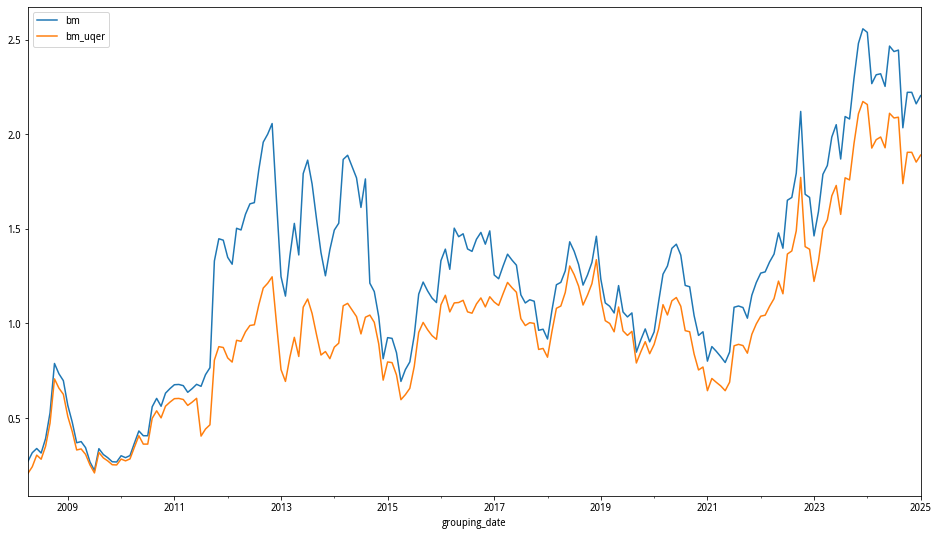

In [194]:
ret_df.loc[ret_df['secID']=='000001.XSHE',['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

grouping_date        bm   bm_uqer
13334       2013-09  0.569804  0.196302
13335       2013-10  0.961887  0.391481
13336       2013-11  0.971725  0.395476
13337       2013-12  0.931106  0.378946
13338       2014-01  0.993498  0.404351
13339       2014-02  1.195566  0.486594
13340       2014-03  1.061676  0.432096
13341       2014-04  1.185267  0.482393
13342       2014-05  1.175061  0.478240
13343       2014-06  1.062497  0.431202
...             ...       ...       ...
13461       2024-04  0.361313  0.354572
13462       2024-05  0.389270  0.381869
13463       2024-06  0.390550  0.383142
13464       2024-07  0.393691  0.387312
13465       2024-08  0.370364  0.364352
13466       2024-09  0.314860  0.283390
13467       2024-10  0.424401  0.382541
13468       2024-11  0.432178  0.389045
13469       2024-12  0.403050  0.362753
13470       2025-01  0.410272  0.369263

[137 rows x 3 columns]

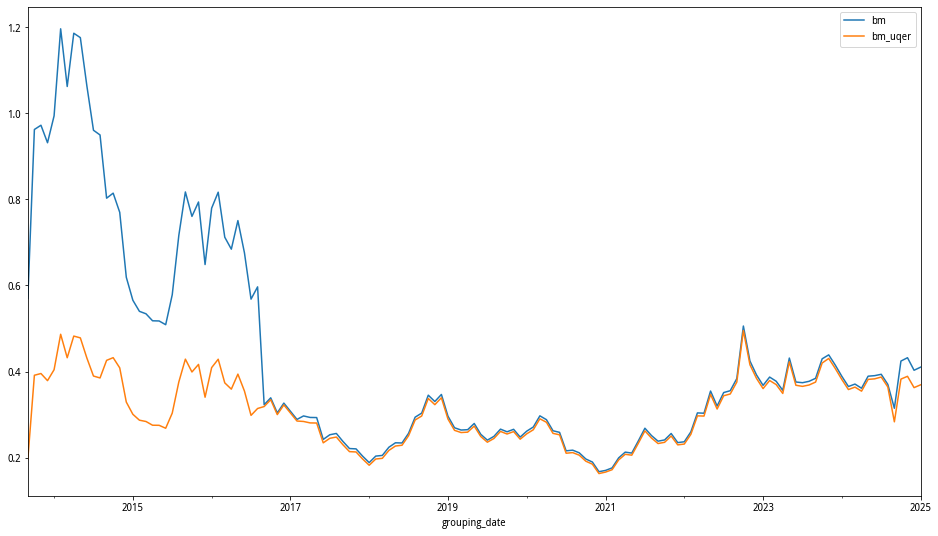

In [195]:
sample_id = np.random.choice(ret_df['secID'].unique(),1)
display(ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']])
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff55c067190>,
      dtype=object)

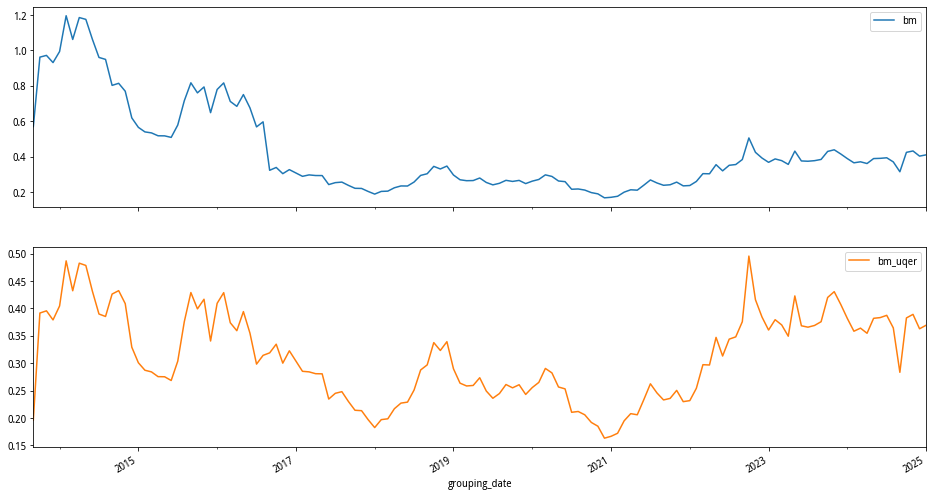

In [196]:
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot(subplots=True)

In [197]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm_uqer'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm_uqer'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm_uqer']) & (ret_df_q['bm_uqer'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm_uqer'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.000755  0.006287  0.008066  0.009590  0.010874  0.011532  0.011324   
t-value  0.118962  0.967509  1.203991  1.488412  1.647019  1.795274  1.739060   

               p8        p9       p10    p10-p1  
mean     0.011776  0.011783  0.010721  0.009966  
t-value  1.826312  1.835725  1.692520  2.832128

# Double Sorting on Size and BM

In [198]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_bm = dict()
keys = ['q_bm_1','q_bm_2']
values = [0.3, 0.7]
q_bm.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['grouping_date'])['size'].quantile(value)

q_bm_df = pd.DataFrame()
for key, value in q_bm.items():
    q_bm_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='grouping_date')
ret_df_q = pd.merge(ret_df_q, q_bm_df, on='grouping_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]

portfolios_bm = dict()
portfolios_bm['bm1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q_bm_1'],
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm2'] = ret_df_q.loc[(ret_df_q['bm'] >= ret_df_q['q_bm_1']) & \
                                           (ret_df_q['bm'] <= ret_df_q['q_bm_2']),
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm3'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q_bm_2'],
                                           ['secID','grouping_date','ret_date','exret','bm']]

portfolios = dict()
for bm_group in portfolios_bm.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{bm_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_bm[bm_group][['secID','ret_date','bm']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有bm和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['bm1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(202,)
(202,)
(202,)
(202,)
(202,)
(202,)


bm1_size1  bm1_size2  bm2_size1  bm2_size2  bm3_size1  bm3_size2
ret_mean   0.010346   0.001183   0.015280   0.004153   0.018916   0.004372
t_values   1.493507   0.190115   2.226264   0.666931   2.514209   0.725863

# Fama MacBeth regression

In [199]:
# ret_df[(ret_df['ret_date'] >= '2008-02') & (ret_df['secID'] == '000001.XSHE')]

In [200]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret100'], X=df_.loc[:,['beta','size','bm']])
    return np.insert(reg.coef_, 0, reg.intercept_)

temp = ret_df.groupby('ret_date').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef','size_coef', 'bm_coef']
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef   bm_coef
ret_mean   9.514713   0.316125  -0.412191  0.020472
t_values   2.881120   0.926938  -2.972742  0.405368

In [201]:
portfolios

{'bm1_size1':              secID grouping_date ret_date     exret       size        mktcap  \
 0      000014.XSHE       2008-04  2008-05  0.285851  21.064186  1.406241e+09   
 1      000019.XSHE       2008-04  2008-05 -0.099410  20.835595  1.118882e+09   
 2      000028.XSHE       2008-04  2008-05  0.003525  21.411577  1.990351e+09   
 3      000049.XSHE       2008-04  2008-05  0.000660  20.182470  5.822848e+08   
 4      000056.XSHE       2008-04  2008-05  0.059926  20.705572  9.824619e+08   
 5      000411.XSHE       2008-04  2008-05  0.028104  20.589655  8.749305e+08   
 6      000415.XSHE       2008-04  2008-05 -0.088174  21.297845  1.776383e+09   
 7      000421.XSHE       2008-04  2008-05 -0.041262  21.173249  1.568286e+09   
 8      000502.XSHE       2008-04  2008-05 -0.056025  20.652852  9.320083e+08   
 9      000504.XSHE       2008-04  2008-05 -0.025740  21.063705  1.405565e+09   
 ...            ...           ...      ...       ...        ...           ...   
 70256  688636.

# Fama French 3 factors

Fama-French 3 factors 的构建：

- Market return 就是 CAPM 里面的市场收益率
- 另外还有 SMB，HML，也即 Small-Minus-Big, High-Minus-Low

构建方法：

- mktcap1 也叫做 Small, mktcap2 Big. bm1 Low, bm2 Medium, bm3 High. 
- 因此对应的，我们的
    - bm1_mktcap1: SL
    - bm2_mktcap1: SM
    - bm3_mktcap1: SH
    - bm1_mktcap2: BL
    - bm2_mktcap2: BM
    - bm3_mktcap2: BH
- 在 Fama French (1993) 的构建里，mktcap 是在t年6月形成并保持到t+1年5月不变。bm和我们这里的构建一样，t年6月按照t-1年的BM ratio构建，保持到t+1年5月不变。
- Fama French 计算了这6组资产组合每一年从7月到下一年6月(资产形成期的第二个月的收益率)的 value-weighted excess return。weight 是t年6月的mktcap占所在portfolio 总的 mktcap 的比重。
- SMB: (SL+SM+SH)/3 - (BL+BM+BH)/3。这样构建的意思是把BM的影响平均掉。
- HML: (SH+BH)/2 - (SL+BL)/2

这里我们还是按照mktcap组合的构建日期，不改成和 Fama-French (1993) 原文一样的日期(t年6月)

In [202]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcapsum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcapsum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['bm1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"bm1_size1": "SL",
                                    "bm2_size1": "SM",
                                    "bm3_size1": "SH",
                                    "bm1_size2": "BL",
                                    "bm2_size2": "BM",
                                    "bm3_size2": "BH"},
                          inplace=True) # vw: value weighted

In [203]:
portfolios_vwret_df

SL        BL        SM        BM        SH        BH
ret_date                                                            
2008-05  -0.007284 -0.093577 -0.021644 -0.083619 -0.031219 -0.080907
2008-06  -0.255728 -0.216611 -0.266144 -0.233029 -0.250379 -0.227270
2008-07   0.102245  0.016148  0.103231  0.014999  0.121348  0.023211
2008-08  -0.244917 -0.197939 -0.226835 -0.148665 -0.226308 -0.147940
2008-09  -0.097522 -0.101487 -0.084565 -0.008817 -0.085767 -0.050331
2008-10  -0.269919 -0.252138 -0.241156 -0.267498 -0.249338 -0.271709
2008-11   0.204277  0.105977  0.214681  0.115202  0.212281  0.136421
2008-12   0.085073  0.012350  0.085156  0.023353  0.088594 -0.041147
2009-01   0.150153  0.109005  0.163256  0.153720  0.170672  0.117782
2009-02   0.071565  0.041163  0.077957  0.055364  0.106767  0.062305
...            ...       ...       ...       ...       ...       ...
2024-05  -0.024621 -0.028705 -0.008048 -0.003480 -0.001761  0.009001
2024-06  -0.099800 -0.045947 -0.091276 -0.048807 -0.097653 -0.019397
2024-07   0.010875 -0.014399  0.001214 -0.016881  0.010684  0.028976
2024-08  -0.021947 -0.046669 -0.031756 -0.037900 -0.039994 -0.021551
2024-09   0.249538  0.217921  0.228211  0.204215  0.226664  0.162212
2024-10   0.137455 -0.007024  0.086313 -0.002189  0.043289 -0.019071
2024-11   0.066066  0.003194  0.069233 -0.002570  0.081645  0.012186
2024-12  -0.065450 -0.024252 -0.048466 -0.015082 -0.042595  0.027965
2025-01  -0.025295 -0.025044 -0.009288 -0.028705 -0.016838 -0.031690
2025-02   0.097486  0.052045  0.082731  0.024409  0.068195  0.001693

[202 rows x 6 columns]

In [204]:
SMB = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 - \
      (portfolios_vwret_df['BL'] + portfolios_vwret_df['BM'] + portfolios_vwret_df['BH']) / 3 

HML = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 - \
      (portfolios_vwret_df['SL'] + portfolios_vwret_df['BL']) / 2 

factors_df = pd.DataFrame(np.vstack([SMB,HML])).T
factors_df.columns = ['SMB','HML']
factors_df.index = SMB.index

In [205]:
factors_df

SMB       HML
ret_date                    
2008-05   0.065986 -0.005633
2008-06  -0.031780 -0.002655
2008-07   0.090822  0.013083
2008-08  -0.067838  0.034304
2008-09  -0.035740  0.031455
2008-10   0.010311  0.000505
2008-11   0.091213  0.019224
2008-12   0.088089 -0.024988
2009-01   0.034524  0.014648
2009-02   0.032486  0.028171
...            ...       ...
2024-05  -0.003749  0.030283
2024-06  -0.058193  0.014349
2024-07   0.008359  0.021592
2024-08   0.004141  0.003535
2024-09   0.040022 -0.039292
2024-10   0.098447 -0.053106
2024-11   0.068044  0.012286
2024-12  -0.048381  0.037536
2025-01   0.011339  0.000906
2025-02   0.056755 -0.039821

[202 rows x 2 columns]

百度百科：中证800指数是由中证指数有限公司编制，其成份股是由中证500和沪深300成份股一起构成，中证800指数综合反映沪深证券市场内大中市值公司的整体状况。

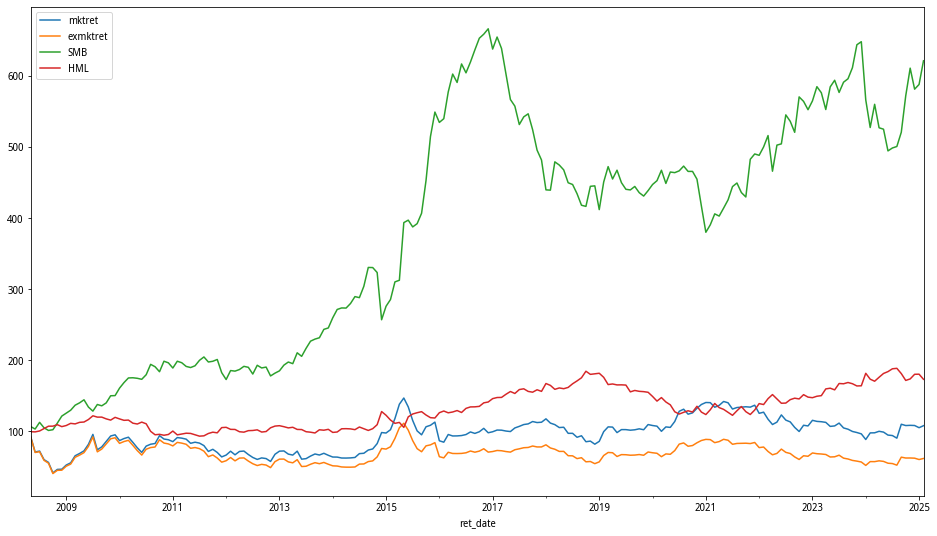

In [206]:
# index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')

index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1

index_df = pd.merge(index_df,rf,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

index_df.drop(['ym','rf','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)

index_df.dropna(inplace=True)

factors_df = pd.merge(index_df, factors_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

((1 + factors_df).cumprod()*100).plot()

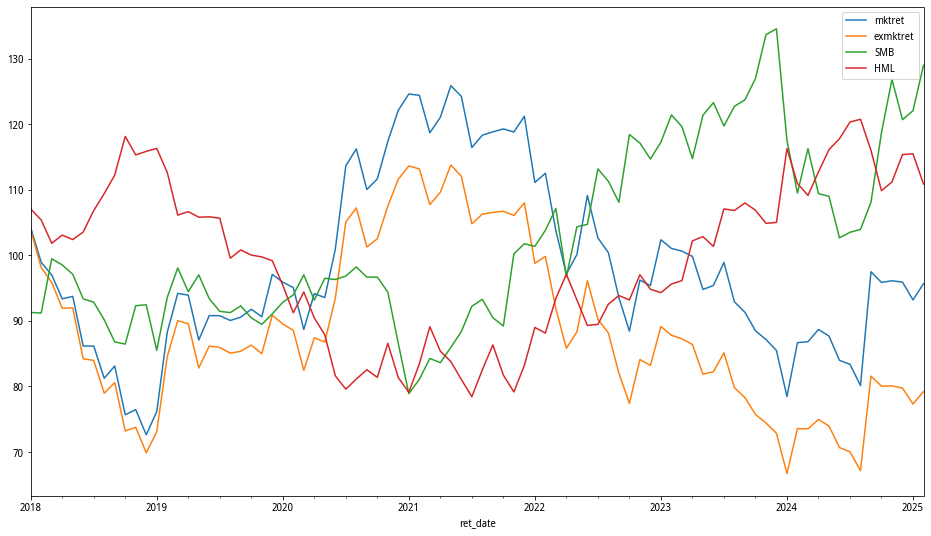

In [207]:
((1 + factors_df.loc['2018':]).cumprod()*100).plot()

In [208]:
factors_df

mktret  exmktret       SMB       HML
ret_date                                          
2008-05-31 -0.077055 -0.080798  0.065986 -0.005633
2008-06-30 -0.232282 -0.236014 -0.031780 -0.002655
2008-07-31  0.018654  0.014972  0.090822  0.013083
2008-08-31 -0.166459 -0.170063 -0.067838  0.034304
2008-09-30 -0.064322 -0.067913 -0.035740  0.031455
2008-10-31 -0.260513 -0.264035  0.010311  0.000505
2008-11-30  0.115286  0.112223  0.091213  0.019224
2008-12-31  0.005625  0.003717  0.088089 -0.024988
2009-01-31  0.125612  0.124356  0.034524  0.014648
2009-02-28  0.058710  0.057622  0.032486  0.028171
...              ...       ...       ...       ...
2024-05-31 -0.011353 -0.013421 -0.003749  0.030283
2024-06-30 -0.042265 -0.044333 -0.058193  0.014349
2024-07-31 -0.007093 -0.009161  0.008359  0.021592
2024-08-31 -0.038931 -0.040999  0.004141  0.003535
2024-09-30  0.216653  0.214585  0.040022 -0.039292
2024-10-31 -0.016745 -0.018813  0.098447 -0.053106
2024-11-30  0.002654  0.000586  0.068044  0.012286
2024-12-31 -0.002120 -0.004188 -0.048381  0.037536
2025-01-31 -0.028387 -0.030455  0.011339  0.000906
2025-02-28  0.026599  0.024531  0.056755 -0.039821

[202 rows x 4 columns]

In [209]:
factors_df.to_csv('./output_data/factors/ff3.csv')

## Long-only factors

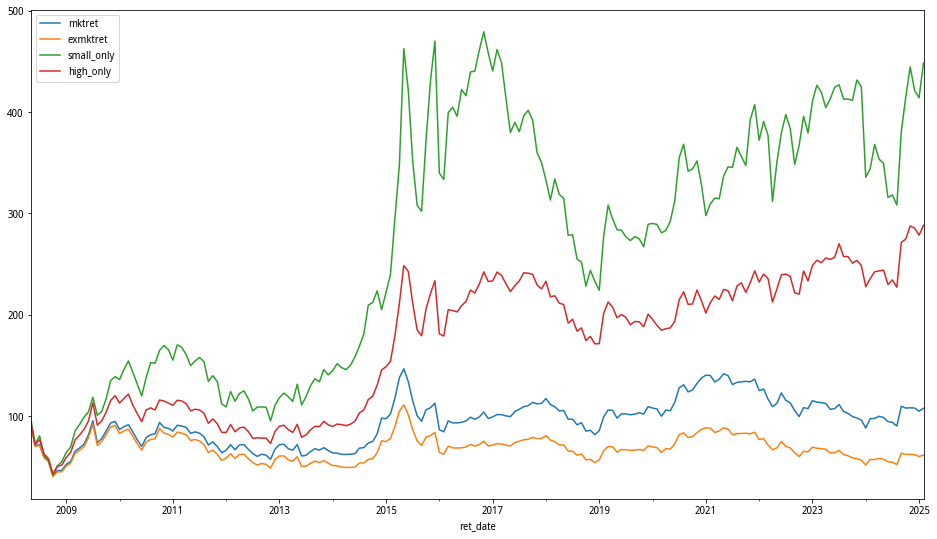

In [210]:
small_only = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 

high_only = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 

factors_long_df = pd.DataFrame(np.vstack([small_only,high_only])).T
factors_long_df.columns = ['small_only','high_only']
factors_long_df.index = small_only.index

factors_long_df = pd.merge(index_df, factors_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

((1 + factors_long_df).cumprod()*100).plot()

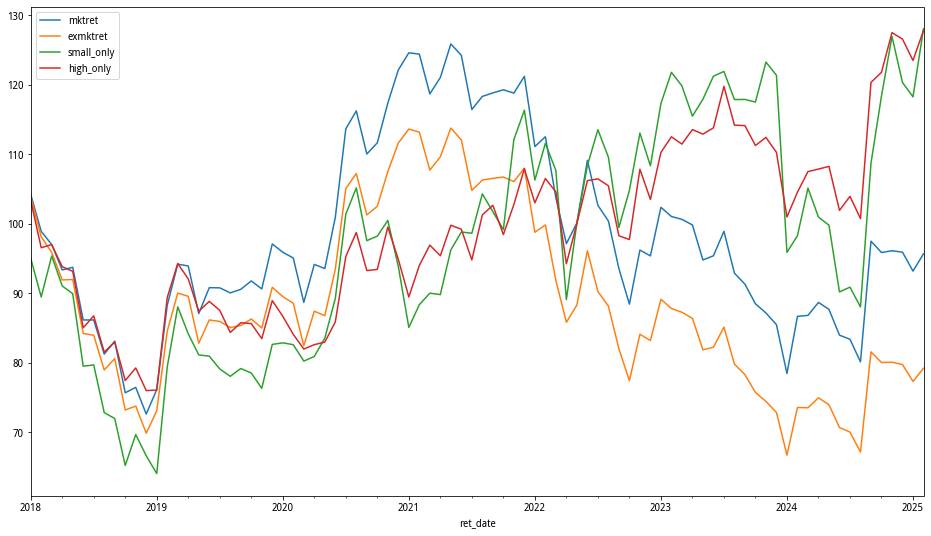

In [211]:
((1 + factors_long_df.loc['2018':]).cumprod()*100).plot()

In [212]:
factors_long_df

mktret  exmktret  small_only  high_only
ret_date                                             
2008-05-31 -0.077055 -0.080798   -0.020049  -0.056063
2008-06-30 -0.232282 -0.236014   -0.257417  -0.238824
2008-07-31  0.018654  0.014972    0.108941   0.072280
2008-08-31 -0.166459 -0.170063   -0.232686  -0.187124
2008-09-30 -0.064322 -0.067913   -0.089285  -0.068049
2008-10-31 -0.260513 -0.264035   -0.253471  -0.260523
2008-11-30  0.115286  0.112223    0.210413   0.174351
2008-12-31  0.005625  0.003717    0.086274   0.023723
2009-01-31  0.125612  0.124356    0.161360   0.144227
2009-02-28  0.058710  0.057622    0.085430   0.084536
...              ...       ...         ...        ...
2024-05-31 -0.011353 -0.013421   -0.011477   0.003620
2024-06-30 -0.042265 -0.044333   -0.096243  -0.058525
2024-07-31 -0.007093 -0.009161    0.007591   0.019830
2024-08-31 -0.038931 -0.040999   -0.031232  -0.030772
2024-09-30  0.216653  0.214585    0.234804   0.194438
2024-10-31 -0.016745 -0.018813    0.089019   0.012109
2024-11-30  0.002654  0.000586    0.072314   0.046916
2024-12-31 -0.002120 -0.004188   -0.052170  -0.007315
2025-01-31 -0.028387 -0.030455   -0.017141  -0.024264
2025-02-28  0.026599  0.024531    0.082804   0.034944

[202 rows x 4 columns]

In [213]:
factors_long_df.to_csv('./output_data/factors/ff3_long_only.csv')